# Setup

In [1]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy
# %pip install umap-learn
# %pip install ipywidgets


In [2]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [3]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pydicom
from tqdm.notebook import tqdm
import psutil
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')  # Change sharing strategy to avoid shared memory issues

def collect_files(base_dir):
    """
    Recursively collects DICOM files from specific folders, excluding "br_raw" files.
    Now includes validation counter for quality assurance.
    """
    included_files = []
    excluded_files = []
    total_files_checked = 0

    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        total_files_checked += 1
                        full_path = os.path.join(root, file)
                        
                        # Maintain critical "br_raw" exclusion
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))

    logging.info(f"Total files checked: {total_files_checked}")
    logging.info(f"Files included: {len(included_files)}")
    logging.info(f"Files excluded: {len(excluded_files)}")

    return included_files, excluded_files

class DaTScanDataset(Dataset):
    """
    Memory-optimized dataset implementation with efficient file handling.
    """
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        # Calculate statistics only once during initialization
        self._calculate_dataset_statistics()

    def _calculate_dataset_statistics(self):
        """
        Optimized statistics calculation using batched processing.
        """
        stats_list = []
        batch_size = 50  # Process files in batches

        for i in range(0, len(self.df), batch_size):
            batch = self.df.iloc[i:min(i+batch_size, len(self.df))]
            batch_stats = []

            for _, row in batch.iterrows():
                try:
                    volume, _ = load_dicom(row["file_path"])
                    batch_stats.append({
                        'min': volume.min(),
                        'max': volume.max()
                    })
                except Exception as e:
                    logging.warning(f"Error processing file {row['file_path']}: {e}")

            if batch_stats:
                min_vals = [stat['min'] for stat in batch_stats]
                max_vals = [stat['max'] for stat in batch_stats]
                stats_list.append({
                    'min': min(min_vals),
                    'max': max(max_vals)
                })

            # Single garbage collection per batch
            if i % (batch_size * 5) == 0:
                torch.cuda.empty_cache()

        if stats_list:
            self.stats = {
                'min': min(stat['min'] for stat in stats_list),
                'max': max(stat['max'] for stat in stats_list)
            }
        else:
            self.stats = {'min': 0, 'max': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            file_path = self.df.iloc[idx]["file_path"]
            label = self.df.iloc[idx]["label"]
            
            # Load and process volume efficiently
            volume, _ = load_dicom(file_path)
            volume = self._process_volume(volume)
            
            # Convert to tensor without copying if possible
            volume_tensor = torch.from_numpy(volume).float()
            
            # Release memory explicitly
            del volume
            
            return {
                "volume": volume_tensor,
                "label": label,
                "path": file_path
            }
            
        except Exception as e:
            logging.error(f"Error loading file {file_path}: {str(e)}")
            raise

    def _process_volume(self, volume):
        """
        Efficient volume processing without excessive memory operations.
        """
        # Normalize
        volume = np.clip(volume, a_min=0, a_max=None)
        vol_min, vol_max = volume.min(), volume.max()
        if vol_max > vol_min:
            volume = (volume - vol_min) / (vol_max - vol_min)
        
        # Add channel dimension
        volume = np.expand_dims(volume, axis=0)
        return volume

def create_dataloaders(df, batch_size=4, train_split=0.8):
    """
    Create optimized DataLoaders with parallel processing and memory management.
    """
    # Check system resources
    cpu_count = psutil.cpu_count(logical=False)  # Physical CPU cores
    memory_gb = psutil.virtual_memory().total / (1024**3)
    
    # Adjust workers based on system resources
    num_workers = min(cpu_count - 1, 4)  # Leave one core free, max 4 workers
    if memory_gb < 16:  # If less than 16GB RAM
        num_workers = 2
    
    print(f"System configuration:")
    print(f"- CPU cores: {cpu_count}")
    print(f"- Memory: {memory_gb:.1f}GB")
    print(f"- Using {num_workers} workers")
    from sklearn.model_selection import train_test_split

    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    # Create datasets
    train_dataset = DaTScanDataset(train_df)
    val_dataset = DaTScanDataset(val_df)

    # Configure optimized DataLoaders
    loader_args = {
        'num_workers': num_workers,
        'pin_memory': True,
        'persistent_workers': True,
        'prefetch_factor': 2,
        'timeout': 60  # Add timeout to avoid hanging
    }

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        **loader_args
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        **loader_args
    )

    return train_loader, val_loader

def load_dicom(file_path):
    """
    Optimized DICOM loading function.
    """
    try:
        ds = pydicom.dcmread(file_path)
        pixel_array = ds.pixel_array.astype(np.float32)
        
        if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
            pixel_array = pixel_array * ds.RescaleSlope + ds.RescaleIntercept
            
        return pixel_array, ds
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")



## Data Ingestion

In [4]:
# Cell 4: Data Ingestion Pipeline
# Define the base directory containing the "Images" folder
base_dir = "Images"

# Use existing CSV if available, otherwise collect files
csv_path = "validated_file_paths.csv"
if os.path.exists(csv_path):
    print("Loading existing validated file paths...")
    df = pd.read_csv(csv_path)
else:
    print("Collecting and validating files...")
    included_files, excluded_files = collect_files(base_dir)
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    
    # Validate no "br_raw" files are included
    if df["file_path"].str.contains("br_raw").any():
        raise ValueError("Validation failed: 'br_raw' files detected!")
        
    # Save validated paths
    df.to_csv(csv_path, index=False)

print(f"Total files: {len(df)}")
print("\nLabel distribution:")
print(df["label"].value_counts())

Loading existing validated file paths...
Total files: 2986

Label distribution:
label
PD         2555
Control     294
SWEDD       137
Name: count, dtype: int64


In [7]:
# Cell 5: Execute Data Ingestion Pipeline

def generate_dataframe(included_files):
    """
    Generate a pandas DataFrame from a list of tuples containing file paths and labels.
    
    Args:
        included_files (list): List of tuples where each tuple contains (file_path, label)
        
    Returns:
        pd.DataFrame: DataFrame with columns 'file_path' and 'label'
        
    Raises:
        ValueError: If input list is empty or malformed
    """
    if not included_files:
        raise ValueError("Input list is empty")
    
    try:
        # Verify the structure of the first item
        if not isinstance(included_files[0], (tuple, list)) or len(included_files[0]) != 2:
            raise ValueError("Input list items must be tuples/lists with (file_path, label)")
        
        # Create DataFrame
        df = pd.DataFrame(included_files, columns=["file_path", "label"])
        
        # Validate DataFrame structure
        if df.empty:
            raise ValueError("Generated DataFrame is empty")
        
        if not all(df["file_path"].apply(lambda x: isinstance(x, str))):
            raise ValueError("All file paths must be strings")
            
        # Verify no "br_raw" files are included (as per project requirements)
        if df["file_path"].str.contains("br_raw").any():
            raise ValueError("Found 'br_raw' files in the dataset which should be excluded")
        
        # Print basic statistics
        print(f"Generated DataFrame with {len(df)} rows")
        print("\nLabel distribution:")
        print(df["label"].value_counts())
        
        return df
    
    except Exception as e:
        raise ValueError(f"Error generating DataFrame: {str(e)}")

def save_qa_report(total_files, included_count, excluded_count):
    """
    Generate and save a Quality Assurance report for the data ingestion process.
    
    Args:
        total_files (int): Total number of files processed
        included_count (int): Number of files included in the dataset
        excluded_count (int): Number of files excluded from the dataset
    
    Returns:
        None: Saves the report as a CSV file
    """
    import pandas as pd
    from datetime import datetime
    
    # Create report data
    report_data = {
        'Metric': [
            'Total Files Processed',
            'Files Included',
            'Files Excluded',
            'Inclusion Rate (%)',
            'Exclusion Rate (%)',
            'Report Generation Time'
        ],
        'Value': [
            total_files,
            included_count,
            excluded_count,
            round((included_count / total_files) * 100, 2) if total_files > 0 else 0,
            round((excluded_count / total_files) * 100, 2) if total_files > 0 else 0,
            datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ]
    }
    
    # Create DataFrame
    report_df = pd.DataFrame(report_data)
    
    try:
        # Save report
        report_filename = "data_ingestion_QA_report.csv"
        report_df.to_csv(report_filename, index=False)
        
        # Print summary
        print("\nQA Report Summary:")
        print(f"Total files processed: {total_files}")
        print(f"Files included: {included_count}")
        print(f"Files excluded: {excluded_count}")
        print(f"Inclusion rate: {report_data['Value'][3]}%")
        print(f"Exclusion rate: {report_data['Value'][4]}%")
        print(f"\nDetailed report saved as: {report_filename}")
        
    except Exception as e:
        print(f"Error saving QA report: {str(e)}")
        raise

def validate_qa_metrics(total_files, included_count, excluded_count):
    """
    Validate QA metrics for consistency.
    
    Args:
        total_files (int): Total number of files processed
        included_count (int): Number of files included
        excluded_count (int): Number of files excluded
    
    Returns:
        bool: True if metrics are valid, raises ValueError otherwise
    """
    if total_files < 0 or included_count < 0 or excluded_count < 0:
        raise ValueError("File counts cannot be negative")
        
    if included_count + excluded_count != total_files:
        raise ValueError(
            f"Sum of included ({included_count}) and excluded ({excluded_count}) "
            f"files does not match total files ({total_files})"
        )
        
    if total_files == 0:
        raise ValueError("No files were processed")
        
    return True


# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")

Generated DataFrame with 2986 rows

Label distribution:
label
PD         2555
Control     294
SWEDD       137
Name: count, dtype: int64
Validated file paths saved to validated_file_paths.csv

QA Report Summary:
Total files processed: 3879
Files included: 2986
Files excluded: 893
Inclusion rate: 76.98%
Exclusion rate: 23.02%

Detailed report saved as: data_ingestion_QA_report.csv
QA report generated and saved as data_ingestion_QA_report.csv


## Data Visualization

Loading file for group PD: Images/PPMI_Images_PD/3564/Reconstructed_DaTSCAN/2011-08-24_12_00_54.0/I339560/PPMI_3564_NM_Reconstructed_DaTSCAN_Br_20121011135013715_1_S124351_I339560.dcm
Loading file for group SWEDD: Images/PPMI_Images_SWEDD/3356/Reconstructed_DaTSCAN/2013-03-27_13_54_26.0/I419247/PPMI_3356_NM_Reconstructed_DaTSCAN_Br_20140408100449966_1_S215427_I419247.dcm
Loading file for group Control: Images/PPMI_Images_Cont/3576/Reconstructed_DaTSCAN/2011-09-22_15_22_49.0/I338785/PPMI_3576_NM_Reconstructed_DaTSCAN_Br_20121008153803846_1_S127556_I338785.dcm


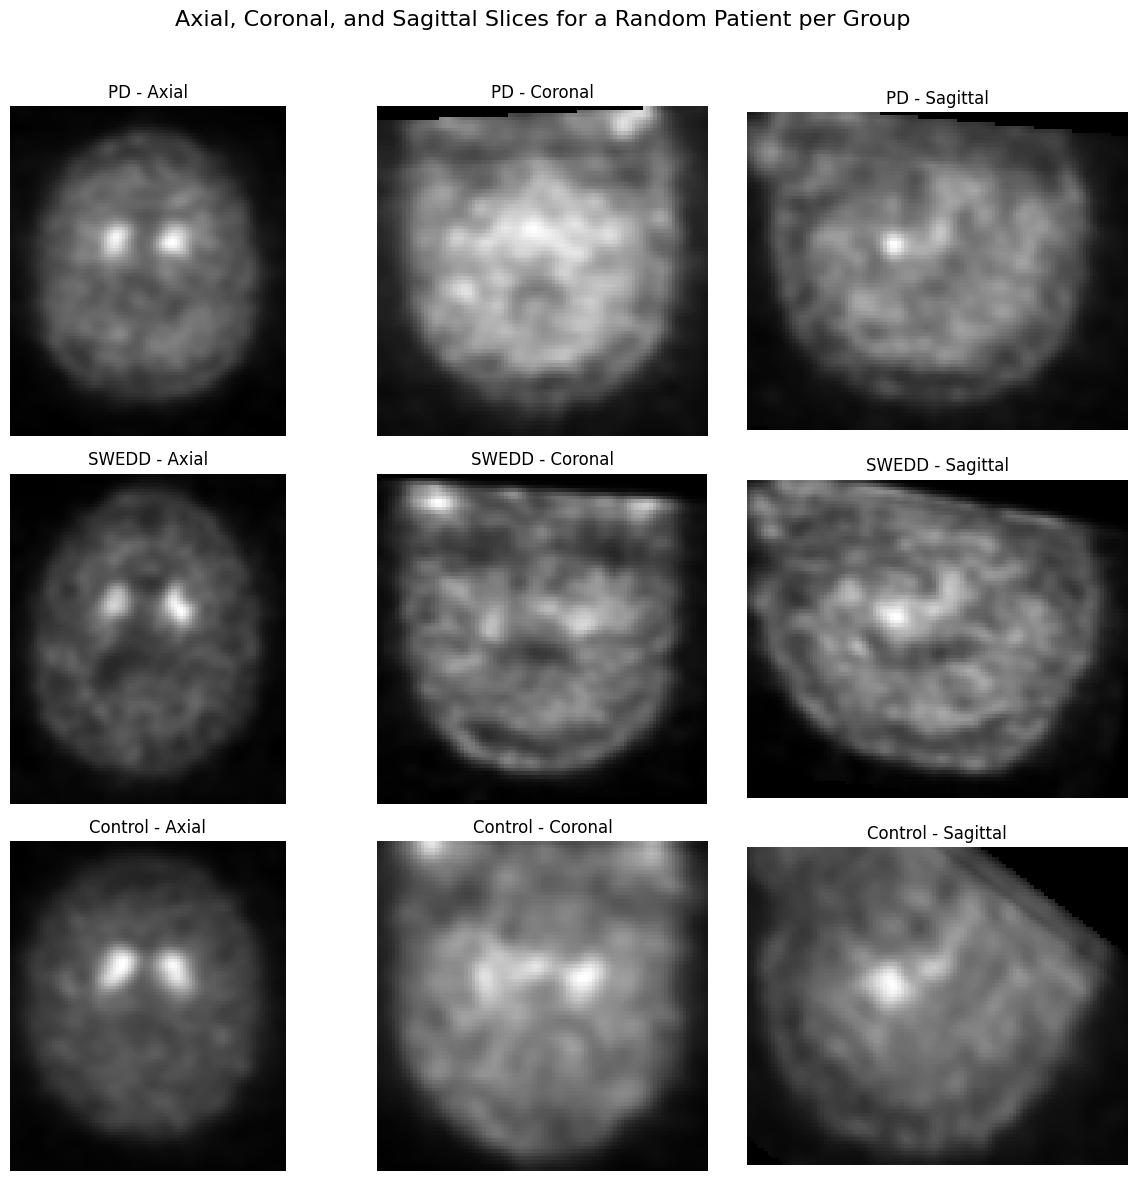

In [8]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}

# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue

    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")

    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)

    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")

    axial, coronal, sagittal = extract_slices(volume)

    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")

    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")

    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Data Preprocessing

### Intensity Normalization and Volume Preprocessing

In [9]:
# Cell 7: Data Preprocessing – Intensity Normalization & Volume Processing

import numpy as np

def intensity_normalization(volume):
    """
    Normalizes intensity values:
    - Truncates negative values (sets them to 0)
    - Applies min-max scaling to bring values between 0 and 1 per volume.

    :param volume: Input 3D volume as a numpy array.
    :return: Normalized volume.
    """
    volume = np.clip(volume, a_min=0, a_max=None)
    vol_min, vol_max = volume.min(), volume.max()
    if vol_max > vol_min:
        volume = (volume - vol_min) / (vol_max - vol_min)
    else:
        volume = volume - vol_min  # volume is constant
    return volume

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping while preserving aspect ratio.

    :param volume: Input 3D volume (numpy array) with shape (d, h, w).
    :param target_shape: Desired output shape (d_out, h_out, w_out).
    :return: Resized volume with shape target_shape.
    """
    current_shape = volume.shape
    resized = volume.copy()

    # For each dimension, either pad or crop to the target size
    for i in range(3):
        current = resized.shape[i]
        target = target_shape[i]
        if current < target:
            # Calculate padding sizes
            pad_total = target - current
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[i] = (pad_before, pad_after)
            resized = np.pad(resized, pad_width=pad_width, mode="constant", constant_values=0)
        elif current > target:
            # Center crop
            start = (current - target) // 2
            end = start + target
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            elif i == 2:
                resized = resized[:, :, start:end]
    return resized

# Example usage (for testing on one volume):
volume, _ = load_dicom(random_file)  # random_file selected previously
norm_vol = intensity_normalization(volume)
resized_vol = resize_volume(norm_vol)
print("Original shape:", volume.shape, "Resized shape:", resized_vol.shape)

Original shape: (91, 109, 91) Resized shape: (128, 128, 128)


### Brain Masking

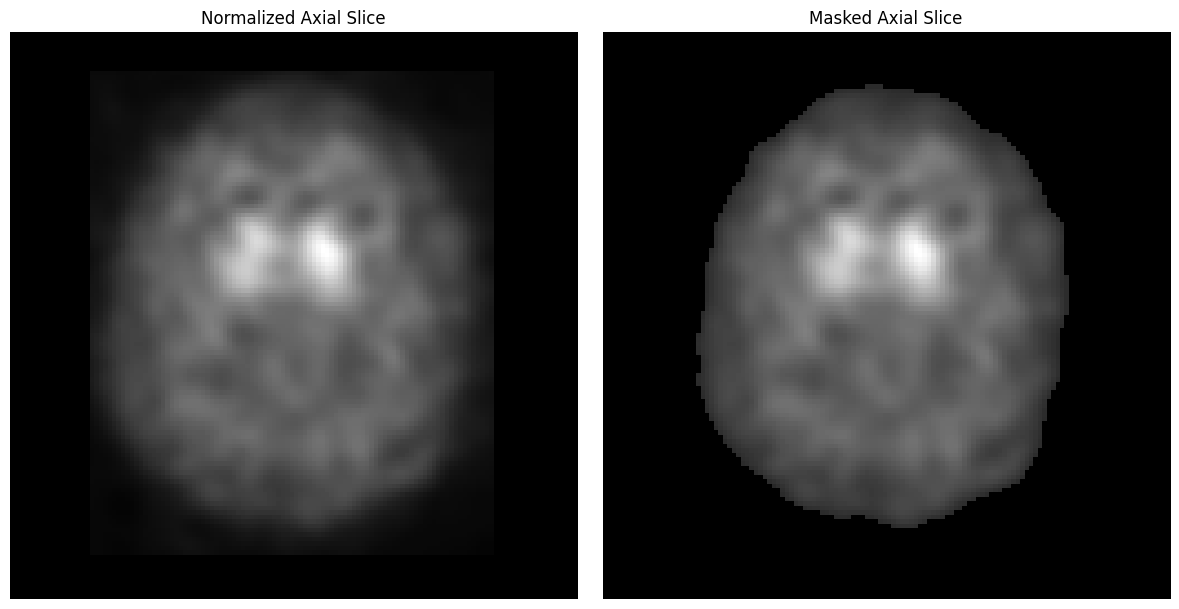

In [ ]:
# Cell 8: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.

    Args:
        volume: Input 3D volume as numpy array with shape (d, h, w)
        target_shape: Desired output shape as tuple (d_new, h_new, w_new)

    Returns:
        Resized volume with shape target_shape
    """
    def get_pad_amounts(current_size, target_size):
        """Helper to calculate padding amounts"""
        if current_size >= target_size:
            return 0, 0
        diff = target_size - current_size
        pad_before = diff // 2
        pad_after = diff - pad_before
        return pad_before, pad_after

    current_shape = volume.shape
    resized = volume.copy()

    # Calculate padding/cropping for each dimension
    pads = [get_pad_amounts(current_shape[i], target_shape[i]) for i in range(3)]

    # Apply padding if needed
    if any(sum(p) > 0 for p in pads):
        resized = np.pad(
            resized,
            pad_width=pads,
            mode="constant",
            constant_values=0
        )

    # Apply cropping if needed
    for i in range(3):
        if current_shape[i] > target_shape[i]:
            # Calculate slicing indices
            start = (current_shape[i] - target_shape[i]) // 2
            end = start + target_shape[i]
            # Apply slice
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            else:
                resized = resized[:, :, start:end]

    return resized

def process_volume(volume, target_shape=(128, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling)
    2. Resizing to target_shape
    3. Generating a brain mask via Otsu thresholding and morphological closing

    Args:
        volume: Input 3D volume
        target_shape: Desired output shape (depth, height, width)

    Returns:
        norm_vol: Normalized and resized volume
        mask: Brain mask
        masked_vol: Masked volume
    """
    # 1. Intensity normalization
    volume = np.clip(volume, a_min=0, a_max=None)
    vmin, vmax = volume.min(), volume.max()
    if vmax > vmin:
        norm_vol = (volume - vmin) / (vmax - vmin)
    else:
        norm_vol = volume - vmin

    # 2. Resize the normalized volume
    norm_vol = resize_volume(norm_vol, target_shape=target_shape)

    # 3. Compute brain mask
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))
    masked_vol = norm_vol * mask

    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(128,128,128))

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


## Dataloader Creation (with Shape Validation)

In [ ]:
# Cell 9: Create DataLoaders with robust testing
import time
import psutil
import gc
from torch.utils.data import DataLoader

def test_dataloader_config(df, batch_size, num_workers):
    """Test if a DataLoader configuration works."""
    try:
        # Create a small subset for testing
        test_df = df.iloc[:100]
        dataset = DaTScanDataset(test_df)
        
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=True if num_workers > 0 else False
        )
        
        # Try to load one batch
        next(iter(loader))
        return True
    except Exception as e:
        print(f"Configuration failed: batch_size={batch_size}, num_workers={num_workers}")
        print(f"Error: {str(e)}")
        return False

# Clean up before starting
gc.collect()
torch.cuda.empty_cache()

print("Testing DataLoader configurations...")

# Test configurations from most to least demanding
configs = [
    {"batch_size": 4, "num_workers": 2},
    {"batch_size": 4, "num_workers": 1},
    {"batch_size": 2, "num_workers": 1},
    {"batch_size": 4, "num_workers": 0},  # Fallback to single process
]

working_config = None
for config in configs:
    print(f"\nTrying configuration: {config}")
    if test_dataloader_config(df, **config):
        working_config = config
        print("Configuration successful!")
        break
    gc.collect()
    torch.cuda.empty_cache()

if working_config is None:
    raise RuntimeError("Could not find a working DataLoader configuration")

print(f"\nCreating dataloaders with working configuration: {working_config}")
train_loader, val_loader = create_dataloaders(df, batch_size=working_config['batch_size'])

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Test actual loading speed with the working configuration
print("\nTesting batch loading speed...")
start_time = time.time()
batches_loaded = 0

try:
    for i, batch in enumerate(train_loader):
        if i == 0:
            print("First batch loaded successfully!")
            print(f"Batch shape: {batch['volume'].shape}")
        batches_loaded += 1
        if i == 4:  # Test with 5 batches
            break
    
    end_time = time.time()
    print(f"Successfully loaded {batches_loaded} batches")
    print(f"Average time per batch: {(end_time - start_time)/batches_loaded:.2f} seconds")
except Exception as e:
    print(f"Error during batch loading: {str(e)}")

Testing DataLoader configurations...

Trying configuration: {'batch_size': 4, 'num_workers': 2}
Configuration successful!

Creating dataloaders with working configuration: {'batch_size': 4, 'num_workers': 2}
System configuration:
- CPU cores: 8
- Memory: 15.1GB
- Using 2 workers
Number of training batches: 597
Number of validation batches: 150

Testing batch loading speed...
First batch loaded successfully!
Batch shape: torch.Size([4, 1, 91, 109, 91])
Successfully loaded 5 batches
Average time per batch: 0.06 seconds


# Exploratory Data Analysis (EDA)

Creating stratified dataloaders...

Dataset split statistics:
Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64
Starting Exploratory Data Analysis...

Analyzing training dataset...
Analyzing dataset statistics...


Computing statistics:   0%|          | 0/1194 [00:00<?, ?it/s]


Plotting intensity distributions...


/tmp/ipykernel_57723/672757701.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
/tmp/ipykernel_57723/672757701.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')


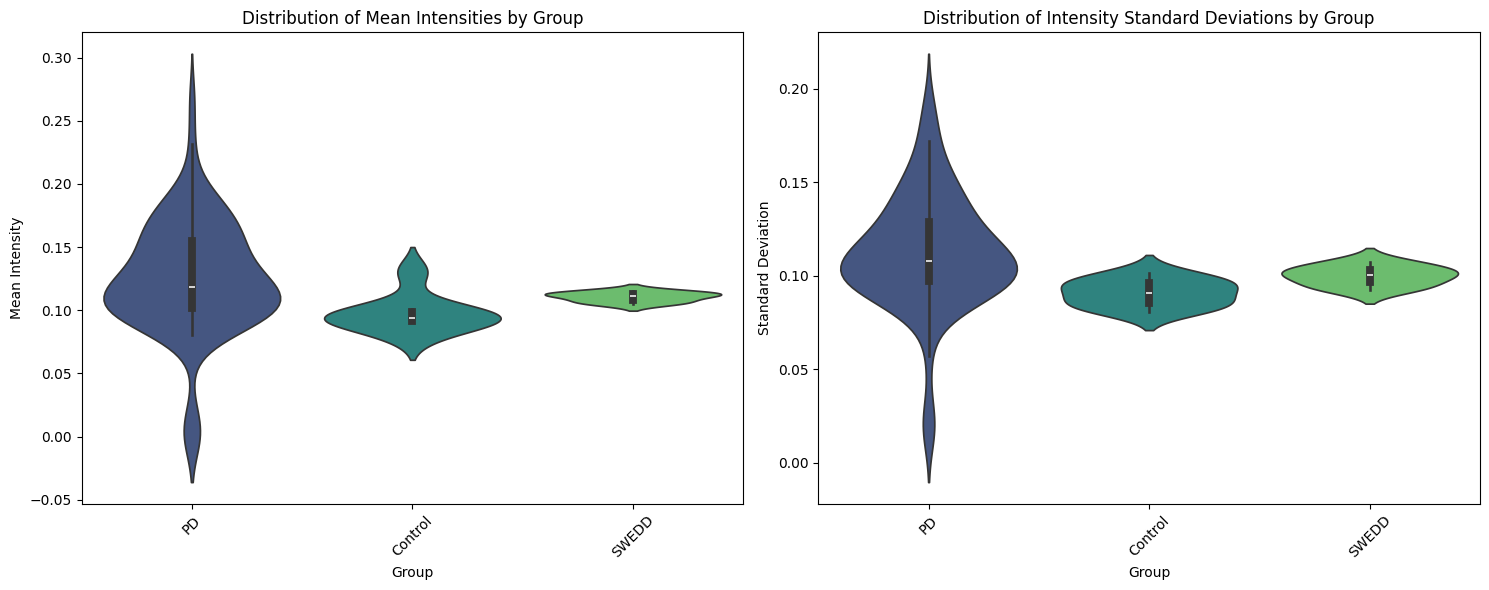

/tmp/ipykernel_57723/672757701.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=stats_df, x='label', palette='viridis')



Plotting group statistics...


/tmp/ipykernel_57723/672757701.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
/tmp/ipykernel_57723/672757701.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')


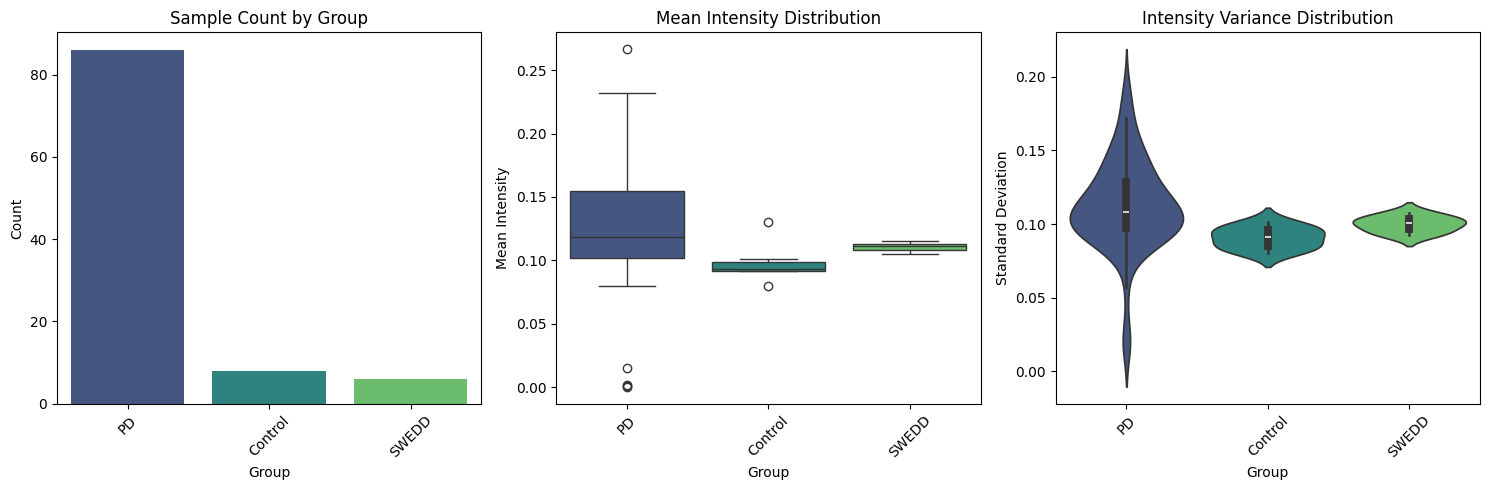


Analyzing spatial patterns...


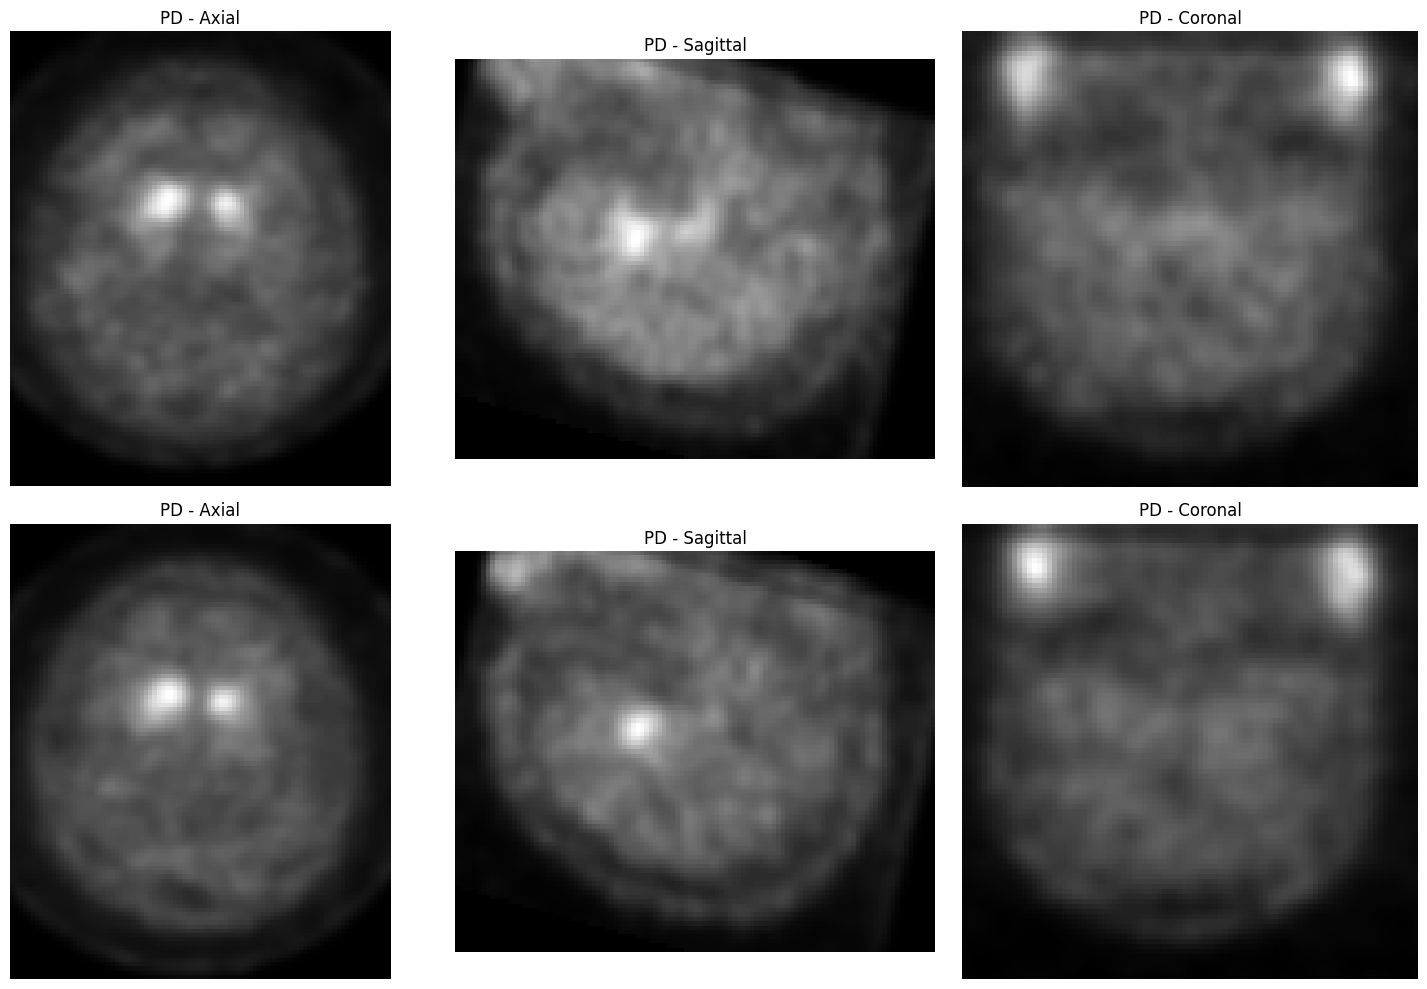


Summary Statistics by Group:
          mean           std        median         min       max     
          mean    std   mean    std   mean    std mean  std mean  std
label                                                                
Control  0.098  0.015  0.091  0.007  0.074  0.029  0.0  0.0  1.0  0.0
PD       0.126  0.045  0.112  0.031  0.097  0.055  0.0  0.0  1.0  0.0
SWEDD    0.111  0.004  0.100  0.005  0.083  0.015  0.0  0.0  1.0  0.0

EDA completed!


In [ ]:
# Cell 10: Comprehensive EDA Implementation with Stratified Split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split

# First, let's implement proper stratified splitting
def create_stratified_dataloaders(df, batch_size=2, train_split=0.8):
    """
    Create train and validation dataloaders with stratified splitting to maintain class distributions
    """
    # Perform stratified split
    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    print("\nDataset split statistics:")
    print("Training set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())

    # Create datasets
    train_dataset = DaTScanDataset(train_df)
    val_dataset = DaTScanDataset(val_df)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader

def analyze_dataset_statistics(dataloader, num_batches=None):
    """
    Analyzes dataset statistics with memory-efficient batch processing
    Returns: Dictionary of statistical measures
    """
    print("Analyzing dataset statistics...")
    stats = defaultdict(list)

    try:
        for i, batch in enumerate(tqdm(dataloader, desc="Computing statistics")):
            if num_batches and i >= num_batches:
                break

            volumes = batch['volume']
            labels = batch['label']

            # Per-volume statistics
            for vol_idx, (volume, label) in enumerate(zip(volumes, labels)):
                vol_data = volume.numpy().flatten()

                stats['mean'].append(np.mean(vol_data))
                stats['std'].append(np.std(vol_data))
                stats['median'].append(np.median(vol_data))
                stats['min'].append(np.min(vol_data))
                stats['max'].append(np.max(vol_data))
                stats['label'].append(label)

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during statistical analysis: {str(e)}")
        import traceback
        traceback.print_exc()

    return pd.DataFrame(stats)

def plot_intensity_distributions(stats_df):
    """
    Creates violin plots of intensity distributions by group
    """
    plt.figure(figsize=(15, 6))

    # Plot intensity distributions
    plt.subplot(1, 2, 1)
    sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Distribution of Intensity Standard Deviations by Group')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_group_statistics(stats_df):
    """
    Plots statistical summaries by group
    """
    plt.figure(figsize=(15, 5))

    # Group counts
    plt.subplot(1, 3, 1)
    sns.countplot(data=stats_df, x='label', palette='viridis')
    plt.title('Sample Count by Group')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Box plots
    plt.subplot(1, 3, 2)
    sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    # Violin plots for variance
    plt.subplot(1, 3, 3)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Intensity Variance Distribution')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def analyze_spatial_patterns(dataloader, num_samples_per_group=2):
    """
    Analyzes spatial patterns in the volumes, ensuring samples from each group
    """
    # Collect samples per group
    samples = defaultdict(list)

    print("Collecting samples for spatial analysis...")
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']

        for volume, label in zip(volumes, labels):
            if len(samples[label]) < num_samples_per_group:
                samples[label].append(volume)

        # Check if we have enough samples from each group
        if all(len(v) >= num_samples_per_group for v in samples.values()):
            break

    # Plot samples
    total_samples = len(samples) * num_samples_per_group
    plt.figure(figsize=(15, 5 * total_samples))

    plot_idx = 1
    for label in samples:
        for volume in samples[label]:
            # Get middle slices
            vol_data = volume.squeeze().numpy()
            axial = vol_data[vol_data.shape[0]//2, :, :]
            sagittal = vol_data[:, :, vol_data.shape[2]//2]
            coronal = vol_data[:, vol_data.shape[1]//2, :]

            # Plot
            plt.subplot(total_samples, 3, plot_idx)
            plt.imshow(axial, cmap='gray')
            plt.title(f'{label} - Axial')
            plt.axis('off')

            plt.subplot(total_samples, 3, plot_idx + 1)
            plt.imshow(sagittal, cmap='gray')
            plt.title(f'{label} - Sagittal')
            plt.axis('off')

            plt.subplot(total_samples, 3, plot_idx + 2)
            plt.imshow(coronal, cmap='gray')
            plt.title(f'{label} - Coronal')
            plt.axis('off')

            plot_idx += 3

    plt.tight_layout()
    plt.show()

# Create new stratified dataloaders
print("Creating stratified dataloaders...")
train_loader, val_loader = create_stratified_dataloaders(df, batch_size=2)

# Run the EDA
print("Starting Exploratory Data Analysis...")

# Analyze training dataset statistics
print("\nAnalyzing training dataset...")
train_stats = analyze_dataset_statistics(train_loader, num_batches=50)

# Plot distributions
print("\nPlotting intensity distributions...")
plot_intensity_distributions(train_stats)

# Plot group statistics
print("\nPlotting group statistics...")
plot_group_statistics(train_stats)

# Analyze spatial patterns
print("\nAnalyzing spatial patterns...")
analyze_spatial_patterns(train_loader, num_samples_per_group=2)

# Print summary statistics
print("\nSummary Statistics by Group:")
summary_stats = train_stats.groupby('label').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'median': ['mean', 'std'],
    'min': ['mean', 'std'],
    'max': ['mean', 'std']
}).round(3)
print(summary_stats)

# Memory cleanup
gc.collect()
torch.cuda.empty_cache()
print("\nEDA completed!")

### Slice Intensity Variance Analysis

In [13]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")

    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}

    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']

            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()

                if sample_counts[label] >= num_samples_per_group:
                    continue

                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape

                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]

                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)

                sample_counts[label] += 1

            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0)
            for view, variances in group_variances[group].items()
        }

    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, view in enumerate(views):
        ax = axes[idx]

        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)

        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   0%|          | 0/1194 [00:00<?, ?it/s]


Plotting slice-wise variance analysis...


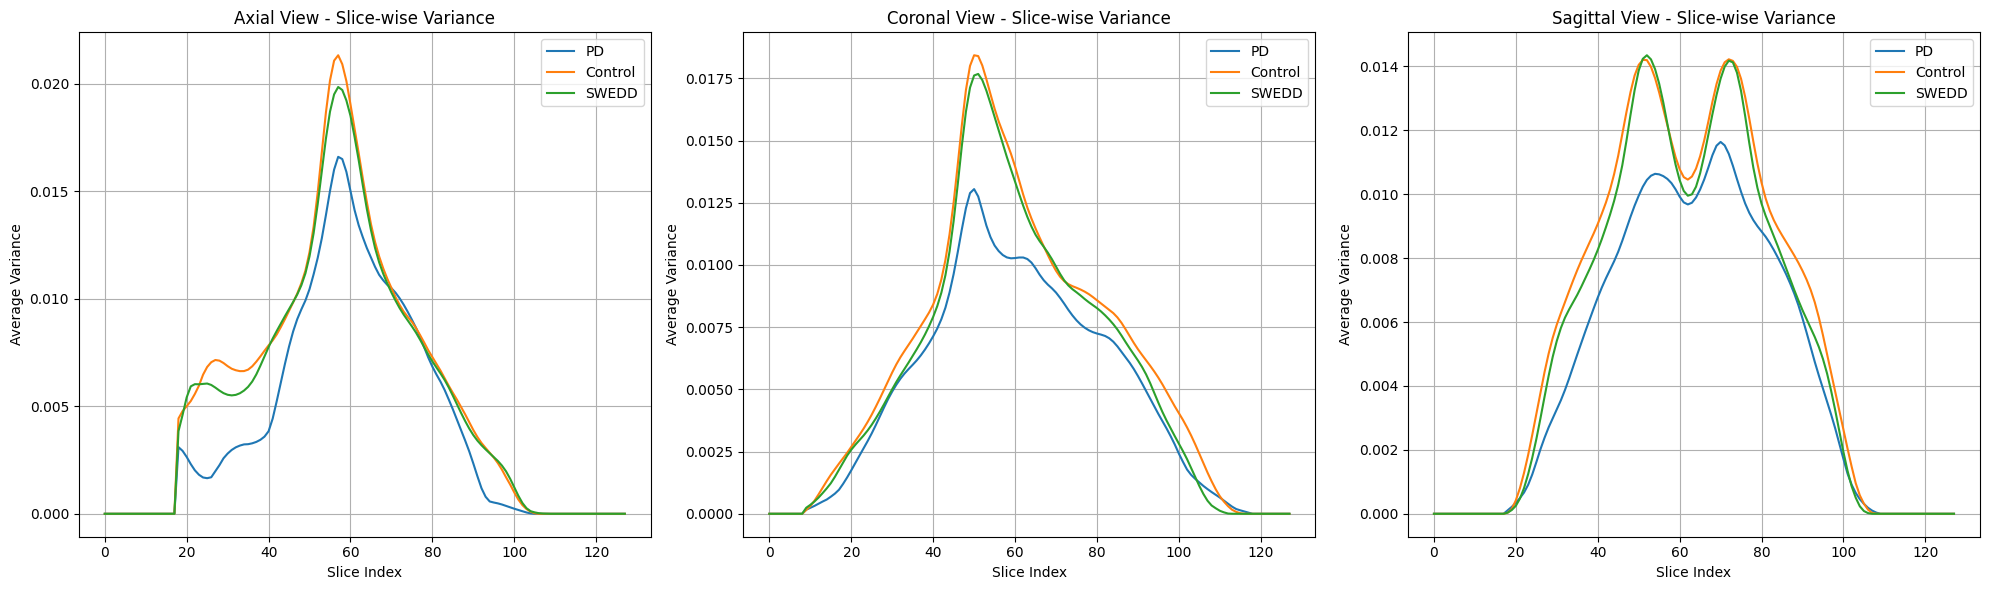

In [14]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)

# Model Phase

In [ ]:
# # Memory and Batch Size Optimization test control

# def test_batch_memory_limits(data_loader, start_size=8, max_size=48, step=8):
#     """
#     Tests different batch sizes to find the optimal one that maximizes GPU utilization
#     while avoiding out-of-memory errors.
#     """
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     memory_stats = {}
#     optimal_batch_size = start_size

#     print("Starting batch size optimization test...")
#     print(f"Testing batch sizes from {start_size} to {max_size} in steps of {step}")
#     print("\nYour GPU: NVIDIA RTX 4070 Ti (12GB)")
#     print("Current test will estimate memory headroom for both training and inference\n")

#     # Get a single batch from the data loader to understand the data shape
#     sample_batch = next(iter(data_loader))
#     sample_volume = sample_batch['volume']
#     volume_shape = sample_volume.shape[1:]
#     print(f"Volume shape (excluding batch dimension): {volume_shape}")

#     for batch_size in range(start_size, max_size + step, step):
#         try:
#             print(f"\nTesting batch size: {batch_size}")

#             # Create a dummy batch with gradient tracking
#             dummy_data = torch.randn(batch_size, *volume_shape, device=device, requires_grad=True)

#             # Simulate model operations (more intensive to better represent real usage)
#             conv_weight1 = torch.randn(32, 1, 3, 3, 3, device=device, requires_grad=True)
#             conv_weight2 = torch.randn(64, 32, 3, 3, 3, device=device, requires_grad=True)

#             # Forward operations (more complex to better simulate real model)
#             conv1 = torch.nn.functional.conv3d(dummy_data, conv_weight1, padding=1)
#             act1 = torch.nn.functional.relu(conv1)
#             pool1 = torch.nn.functional.max_pool3d(act1, kernel_size=2)

#             conv2 = torch.nn.functional.conv3d(pool1, conv_weight2, padding=1)
#             act2 = torch.nn.functional.relu(conv2)
#             pool2 = torch.nn.functional.max_pool3d(act2, kernel_size=2)

#             loss = pool2.mean()
#             loss.backward()

#             # Get memory statistics
#             allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
#             reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # MB
#             max_memory = 12 * 1024  # 12GB for RTX 4070 Ti
#             memory_usage_percent = (reserved / max_memory) * 100

#             memory_stats[batch_size] = {
#                 'allocated': allocated,
#                 'reserved': reserved,
#                 'usage_percent': memory_usage_percent
#             }

#             print(f"GPU Memory Allocated: {allocated:.2f} MB")
#             print(f"GPU Memory Reserved: {reserved:.2f} MB")
#             print(f"Total GPU Memory Usage: {memory_usage_percent:.1f}%")

#             # Estimate training headroom
#             headroom = max_memory - reserved
#             print(f"Estimated memory headroom: {headroom:.2f} MB")

#             # Update optimal batch size
#             optimal_batch_size = batch_size

#             # Clean up
#             del dummy_data, conv_weight1, conv_weight2, conv1, conv2, act1, act2, pool1, pool2, loss
#             torch.cuda.empty_cache()

#             # If we're using more than 70% of GPU memory, stop testing
#             if memory_usage_percent > 70:
#                 print("\nReaching high memory usage, stopping tests for safety")
#                 break

#         except RuntimeError as e:
#             if "out of memory" in str(e):
#                 print(f"\nOut of memory at batch size {batch_size}")
#                 print(f"Last successful batch size was {optimal_batch_size}")
#                 break
#             else:
#                 print(f"Unexpected error: {str(e)}")
#                 break

#     # Calculate recommended values based on memory usage pattern
#     recommended_batch_size = int(optimal_batch_size * 0.8)  # 80% of max for safety
#     recommended_accum_steps = 2 if recommended_batch_size >= 16 else 4

#     print("\nBatch Size Optimization Results:")
#     print(f"Maximum tested batch size: {optimal_batch_size}")
#     print(f"Recommended batch size for training: {recommended_batch_size}")
#     print(f"Recommended accumulation steps: {recommended_accum_steps}")
#     print("\nRecommended training configuration:")
#     print(f"config = TrainingConfig(")
#     print(f"    batch_size={recommended_batch_size},")
#     print(f"    accumulation_steps={recommended_accum_steps},")
#     print(f"    use_mixed_precision=True,")
#     print(f"    num_workers=4,")
#     print(f"    pin_memory=True")
#     print(f")")

#     return recommended_batch_size, memory_stats

# # Example usage
# if __name__ == "__main__":
#     try:
#         print("\nTesting optimal batch size configuration...")
#         optimal_batch_size, memory_stats = test_batch_memory_limits(train_loader)
#     except Exception as e:
#         print(f"Error during batch size testing: {str(e)}")
#         print("Using default conservative values:")
#         print("batch_size = 8")
#         print("accumulation_steps = 4")


Testing optimal batch size configuration...
Starting batch size optimization test...
Testing batch sizes from 8 to 48 in steps of 8

Your GPU: NVIDIA RTX 4070 Ti (12GB)
Current test will estimate memory headroom for both training and inference

Volume shape (excluding batch dimension): torch.Size([1, 128, 128, 128])

Testing batch size: 8
GPU Memory Allocated: 5568.43 MB
GPU Memory Reserved: 9862.00 MB
Total GPU Memory Usage: 80.3%
Estimated memory headroom: 2426.00 MB

Reaching high memory usage, stopping tests for safety

Batch Size Optimization Results:
Maximum tested batch size: 8
Recommended batch size for training: 6
Recommended accumulation steps: 4

Recommended training configuration:
config = TrainingConfig(
    batch_size=6,
    accumulation_steps=4,
    use_mixed_precision=True,
    num_workers=4,
    pin_memory=True
)


## 1. Autoencoder

### Model Setup

In [11]:
# Cell 11: Base Autoencoder Implementation with Memory Optimization
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

import torch.cuda.amp as amp

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder with mixed precision support."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        # Enable CUDA benchmarking for optimal convolution algorithms
        torch.backends.cudnn.benchmark = True

    def forward(self, x):
        # Forward pass remains the same for compatibility
        z, skip_connections = self.encoder(x)
        reconstruction = self.decoder(z, skip_connections)
        return reconstruction

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU activation."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    """3D Encoder network optimized for 128³ input volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )

        # Project to latent space
        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        # Track shapes for debugging
        if self.training:
            print(f"Input shape: {x.shape}")

        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent space
        flat = torch.flatten(d4, start_dim=1)
        z = self.fc(flat)

        if self.training:
            print(f"Latent shape: {z.shape}")

        return z, (d1, d2, d3, d4)

class Decoder(nn.Module):
    """3D Decoder network optimized for 128³ output volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path with skip connections
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),   # 16 -> 32
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),    # 32 -> 64
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 64 -> 128
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z, skip_connections):
        if self.training:
            print(f"Decoder input shape: {z.shape}")

        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8, 8)

        # Unpack skip connections
        d1, d2, d3, d4 = skip_connections

        # Upsampling with skip connections
        x = self.up1(x + d4)
        x = self.up2(x + d3)
        x = self.up3(x + d2)
        x = self.up4(x + d1)

        # Final convolution with sigmoid activation
        x = torch.sigmoid(self.final_conv(x))

        if self.training:
            print(f"Output shape: {x.shape}")

        return x

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder for 128³ medical volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z, skip_connections = self.encoder(x)
        reconstruction = self.decoder(z, skip_connections)
        return reconstruction

    def encode(self, x):
        """Encode input to latent space"""
        z, _ = self.encoder(x)
        return z

    def decode(self, z):
        """Decode from latent space (for generation)"""
        batch_size = z.size(0)
        device = z.device
        dummy_skips = (
            torch.zeros(batch_size, 32, 64, 64, 64, device=device),
            torch.zeros(batch_size, 64, 32, 32, 32, device=device),
            torch.zeros(batch_size, 128, 16, 16, 16, device=device),
            torch.zeros(batch_size, 256, 8, 8, 8, device=device)
        )
        return self.decoder(z, dummy_skips)

def test_autoencoder(batch_size=2):
    """Test the autoencoder with dummy data and verify memory usage."""
    print("\nTesting Autoencoder Architecture...")

    try:
        # Create model and move to GPU
        model = BaseAutoencoder()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Print model summary
        print("\nModel Architecture:")
        print(model)

        # Create dummy input (128³ volume)
        dummy_input = torch.randn(batch_size, 1, 128, 128, 128, device=device)

        # Print initial memory usage
        print("\nInitial GPU Memory Usage:")
        print_gpu_memory_stats()

        # Test forward pass
        print("\nTesting forward pass...")
        with torch.no_grad():
            output = model(dummy_input)

        # Print output shape and final memory usage
        print(f"\nOutput shape: {output.shape}")
        print("\nFinal GPU Memory Usage:")
        print_gpu_memory_stats()

        # Verify shapes
        assert output.shape == dummy_input.shape, f"Shape mismatch: {output.shape} vs {dummy_input.shape}"

        # Clean up
        del model, dummy_input, output
        torch.cuda.empty_cache()

        print("\nAutoencoder test completed successfully!")

    except Exception as e:
        print(f"Error testing autoencoder: {str(e)}")
        import traceback
        traceback.print_exc()

# Run test if this cell is executed
if __name__ == "__main__":
    test_autoencoder()


Testing Autoencoder Architecture...

Model Architecture:
BaseAutoencoder(
  (encoder): Encoder(
    (init_conv): ConvBlock(
      (block): Sequential(
        (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (down1): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )


Traceback (most recent call last):
  File "/tmp/ipykernel_57723/3500572160.py", line 195, in test_autoencoder
    print_gpu_memory_stats()
    ^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'print_gpu_memory_stats' is not defined


In [12]:
# Cell 12: Training Utilities and Configuration
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TrainingConfig:
    """Training configuration optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.batch_size = kwargs.get('batch_size', 8)  # Increased from 2 to 8
        self.accumulation_steps = kwargs.get('accumulation_steps', 4)  # New: gradient accumulation
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 10)
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'autoencoder')
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)  # Enable by default
        self.num_workers = kwargs.get('num_workers', 4)  # Optimize data loading
        self.pin_memory = kwargs.get('pin_memory', True)  # Faster data transfer to GPU

        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class EarlyStopping:
    """Early stopping handler with patience"""
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.should_stop

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses):
        """Save model checkpoint and training metadata"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, self.checkpoint_path)

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer, scheduler):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            return None

        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }

def print_gpu_memory_stats():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")

In [13]:
# Cell 13: Training Loop Implementation
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train_autoencoder(model, train_loader, val_loader, config=None):
    """GPU-optimized training loop with mixed precision and gradient accumulation"""
    if config is None:
        config = TrainingConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize training components
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)

    # Load checkpoint if available
    start_epoch = 0
    train_losses = []
    val_losses = []
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, config.epochs):
            model.train()
            epoch_loss = 0
            optimizer.zero_grad()  # Zero gradients at epoch start

            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')

            for batch_idx, batch in enumerate(train_pbar):
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)

                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps

                    # Mixed precision backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    epoch_loss += loss.item() * config.accumulation_steps
                    train_pbar.set_postfix({'loss': loss.item() * config.accumulation_steps})

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Adjusting batch size...")
                        torch.cuda.empty_cache()
                        continue
                    raise e

                # Clean up
                del volumes, reconstructed, loss
                torch.cuda.empty_cache()

            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            val_loss = 0
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Val]')

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        val_loss += loss.item()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'reconstructed' in locals():
                                del reconstructed
                            if 'loss' in locals():
                                del loss
                            torch.cuda.empty_cache()
                            continue
                        else:
                            raise e

                    # Clean up
                    del volumes, reconstructed, loss
                    torch.cuda.empty_cache()

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save checkpoint
            checkpoint_handler.save(
                model, optimizer, scheduler,
                epoch, train_losses, val_losses
            )

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{config.epochs}")
            print(f"Train Loss: {avg_train_loss:.6f}")
            print(f"Val Loss: {avg_val_loss:.6f}")
            print_gpu_memory_stats()

            # Early stopping check
            if early_stopping(avg_val_loss):
                print("\nEarly stopping triggered!")
                break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

        return train_losses, val_losses

### Training

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_57723/3594948651.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=config.use_mixed_precision)
/tmp/ipykernel_57723/1781335604.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

Resuming training from epoch 69


Epoch 70/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Input shape: torch.Size([2, 1, 91, 109, 91])


/tmp/ipykernel_57723/3594948651.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=config.use_mixed_precision):


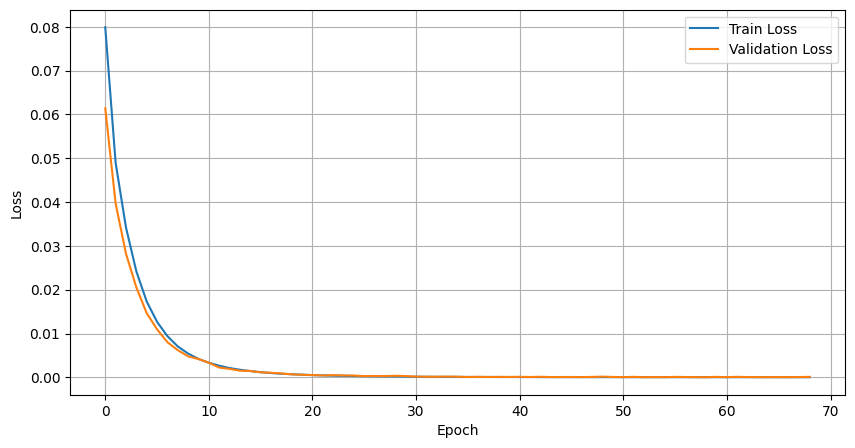

In [14]:
# TRAINING
if __name__ == "__main__":
    try:
        model = BaseAutoencoder()
        config = TrainingConfig(
            learning_rate=1e-4,
            batch_size=16,  # Increased batch size
            accumulation_steps=2,  # Gradient accumulation
            epochs=100,
            use_mixed_precision=True,
            num_workers=8,
            pin_memory=True
        )

        train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, config)

    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

### Evaluation and Result Visualization

/tmp/ipykernel_57723/4244724008.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


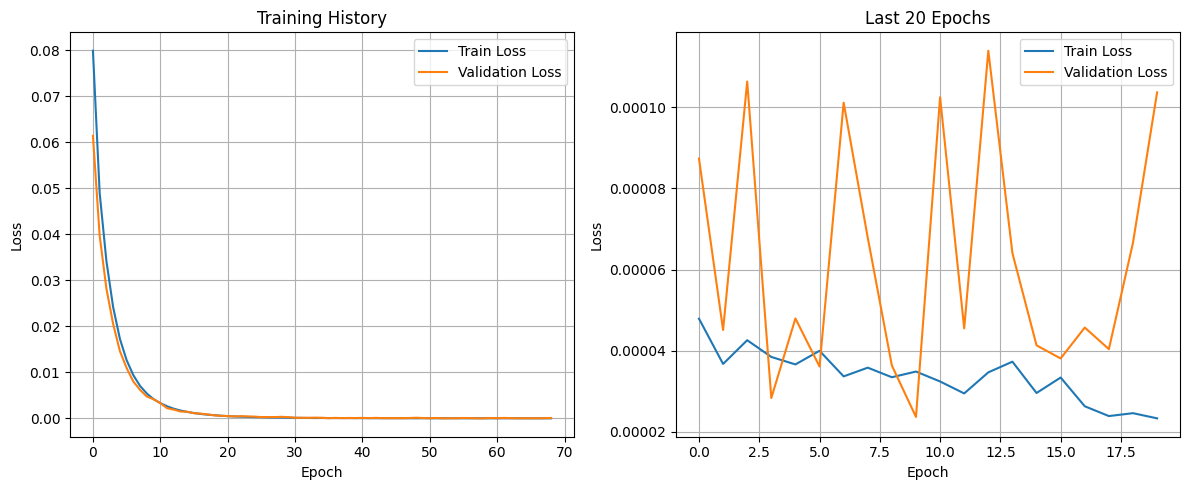

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x64512 and 131072x256)

In [15]:
# Cell 14: Model Evaluation and Visualization
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from pathlib import Path

def load_checkpoint_for_evaluation(checkpoint_dir, model_name):
    """Load model and training history for evaluation"""
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"

    # Load model
    model = BaseAutoencoder()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load training history
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, metadata

def plot_training_history(metadata):
    """Plot training and validation losses"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metadata['train_losses'], label='Train Loss')
    plt.plot(metadata['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)

    # Plot recent epochs in detail
    recent_epochs = 20
    if len(metadata['train_losses']) > recent_epochs:
        plt.subplot(1, 2, 2)
        plt.plot(metadata['train_losses'][-recent_epochs:], label='Train Loss')
        plt.plot(metadata['val_losses'][-recent_epochs:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Last {recent_epochs} Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, val_loader, num_samples=3):
    """Visualize original vs reconstructed volumes"""
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            # Process num_samples samples
            for idx in range(min(num_samples, volumes.shape[0])):
                fig = plt.figure(figsize=(15, 5))

                # Get middle slices
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_vol = reconstructed[idx, 0].cpu().numpy()

                # Plot axial, sagittal, and coronal views
                views = ['Axial', 'Sagittal', 'Coronal']
                slices_orig = [
                    orig_vol[orig_vol.shape[0]//2, :, :],
                    orig_vol[:, orig_vol.shape[1]//2, :],
                    orig_vol[:, :, orig_vol.shape[2]//2]
                ]
                slices_recon = [
                    recon_vol[recon_vol.shape[0]//2, :, :],
                    recon_vol[:, recon_vol.shape[1]//2, :],
                    recon_vol[:, :, recon_vol.shape[2]//2]
                ]

                for i, (view, orig_slice, recon_slice) in enumerate(zip(views, slices_orig, slices_recon)):
                    # Original
                    plt.subplot(2, 3, i+1)
                    plt.imshow(orig_slice, cmap='gray')
                    plt.title(f'Original {view}')
                    plt.axis('off')

                    # Reconstructed
                    plt.subplot(2, 3, i+4)
                    plt.imshow(recon_slice, cmap='gray')
                    plt.title(f'Reconstructed {view}')
                    plt.axis('off')

                plt.suptitle(f'Sample {idx+1} - Original vs Reconstructed', y=1.02)
                plt.tight_layout()
                plt.show()

            break  # Only process first batch

def compute_metrics(model, val_loader):
    """Compute quantitative metrics on validation set"""
    device = next(model.parameters()).device
    mse_criterion = nn.MSELoss()

    total_mse = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            mse = mse_criterion(reconstructed, volumes).item()
            total_mse += mse * volumes.shape[0]
            total_samples += volumes.shape[0]

    avg_mse = total_mse / total_samples
    print(f"\nValidation Metrics:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"RMSE: {np.sqrt(avg_mse):.6f}")

# Example usage
if __name__ == "__main__":
    # Load latest checkpoint
    model, metadata = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Plot training history
    plot_training_history(metadata)

    # Visualize reconstructions
    visualize_reconstructions(model, val_loader)

    # Compute metrics
    compute_metrics(model, val_loader)

### Latent Space Analysis

In [16]:
# Cell 15: Latent Space Analysis
import torch
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_latent_representations(model, dataloader, device):
    """
    Extract latent representations and corresponding labels for all samples
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting latent representations"):
            volumes = batch['volume'].to(device)
            # Get latent vectors using the encode method
            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch['label'])

            # Clean up memory
            del volumes, z
            torch.cuda.empty_cache()

    return np.vstack(latent_vectors), np.array(labels)

def visualize_latent_space(latent_vectors, labels, method='tsne'):
    """
    Visualize latent space using t-SNE or PCA
    """
    plt.figure(figsize=(12, 8))

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        title = 't-SNE Visualization of Latent Space'
    else:
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Space'

    # Reduce dimensionality
    reduced_vecs = reducer.fit_transform(latent_vectors)

    # Create scatter plot
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(reduced_vecs[mask, 0], reduced_vecs[mask, 1],
                   label=label, color=color, alpha=0.6)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return reduced_vecs

def analyze_latent_dimensions(latent_vectors, labels):
    """
    Analyze the distribution of values in each latent dimension
    """
    plt.figure(figsize=(15, 6))

    # Plot distribution of latent values per group
    unique_labels = np.unique(labels)

    # Compute mean activation per dimension for each group
    mean_activations = defaultdict(list)
    for label in unique_labels:
        mask = labels == label
        mean_activations[label] = np.mean(latent_vectors[mask], axis=0)

    # Plot heatmap of mean activations
    activation_matrix = np.vstack([mean_activations[label] for label in unique_labels])
    plt.subplot(1, 2, 1)
    sns.heatmap(activation_matrix, xticklabels=False, yticklabels=unique_labels)
    plt.title('Mean Latent Dimension Activation by Group')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Group')

    # Plot top discriminative dimensions
    variance_ratio = np.var(activation_matrix, axis=0)
    top_dims = np.argsort(variance_ratio)[-5:]  # Top 5 dimensions

    plt.subplot(1, 2, 2)
    for label in unique_labels:
        mask = labels == label
        plt.boxplot([latent_vectors[mask, dim] for dim in top_dims],
                   positions=np.arange(len(top_dims)) + (unique_labels == label).nonzero()[0][0] * 0.3,
                   widths=0.2, label=label)

    plt.title('Distribution of Top 5 Discriminative Dimensions')
    plt.xlabel('Dimension Index')
    plt.ylabel('Activation')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    # Load model and move to device
    model, _ = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Extract latent representations
    latent_vecs, labels = extract_latent_representations(model, val_loader, device)

    # Visualize using t-SNE and PCA
    print("Generating t-SNE visualization...")
    tsne_coords = visualize_latent_space(latent_vecs, labels, method='tsne')

    print("\nGenerating PCA visualization...")
    pca_coords = visualize_latent_space(latent_vecs, labels, method='pca')

    # Analyze latent dimensions
    print("\nAnalyzing latent dimensions...")
    analyze_latent_dimensions(latent_vecs, labels)

/tmp/ipykernel_57723/4244724008.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Extracting latent representations:   0%|          | 0/299 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x64512 and 131072x256)

Analyzing reconstruction quality by region...


Analyzing reconstruction quality:   0%|          | 0/299 [00:00<?, ?it/s]

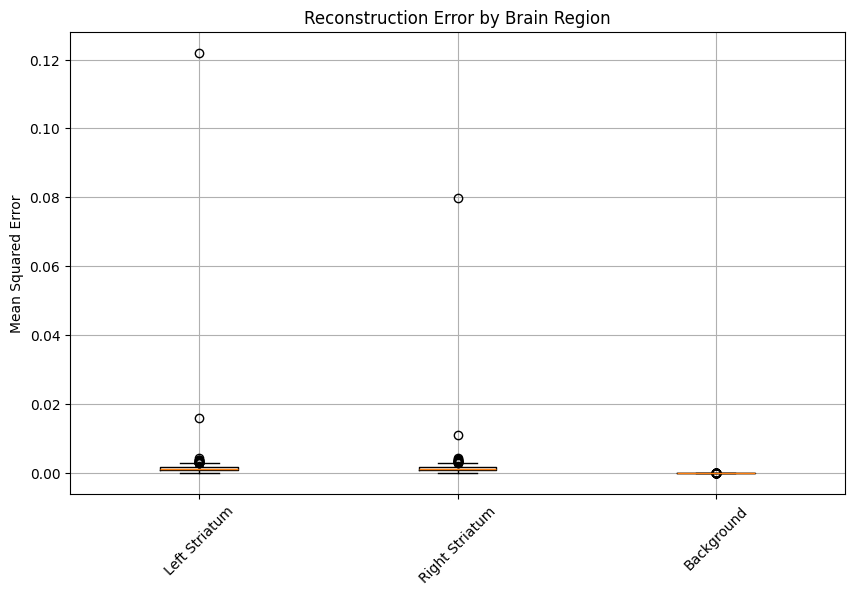


Reconstruction Error Statistics by Region:

Left Striatum:
Mean MSE: 0.001398
Std MSE: 0.005021
Min MSE: 0.000001
Max MSE: 0.121957

Right Striatum:
Mean MSE: 0.001336
Std MSE: 0.003308
Min MSE: 0.000001
Max MSE: 0.079648

Background:
Mean MSE: 0.000001
Std MSE: 0.000000
Min MSE: 0.000001
Max MSE: 0.000002


In [ ]:
# Cell 16: Region-based Reconstruction Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def analyze_reconstruction_quality_by_region(model, dataloader, device):
    """
    Analyze reconstruction quality in different brain regions
    """
    model.eval()
    region_errors = defaultdict(list)

    # Define regions of interest (approximate coordinates for DaTSCAN)
    regions = {
        'Left Striatum': (slice(54, 74), slice(54, 74), slice(44, 64)),
        'Right Striatum': (slice(54, 74), slice(54, 74), slice(64, 84)),
        'Background': (slice(0, 20), slice(0, 20), slice(0, 20))
    }

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing reconstruction quality"):
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            # Calculate error for each region
            for vol_idx in range(volumes.shape[0]):
                orig = volumes[vol_idx, 0].cpu().numpy()
                recon = reconstructed[vol_idx, 0].cpu().numpy()

                for region_name, coords in regions.items():
                    orig_region = orig[coords]
                    recon_region = recon[coords]
                    mse = np.mean((orig_region - recon_region) ** 2)
                    region_errors[region_name].append(mse)

            # Clean up
            del volumes, reconstructed
            torch.cuda.empty_cache()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.boxplot([region_errors[region] for region in regions.keys()],
                labels=regions.keys())
    plt.title('Reconstruction Error by Brain Region')
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Print summary statistics
    print("\nReconstruction Error Statistics by Region:")
    for region in regions.keys():
        errors = region_errors[region]
        print(f"\n{region}:")
        print(f"Mean MSE: {np.mean(errors):.6f}")
        print(f"Std MSE: {np.std(errors):.6f}")
        print(f"Min MSE: {np.min(errors):.6f}")
        print(f"Max MSE: {np.max(errors):.6f}")

# Run the analysis
if __name__ == "__main__":
    print("Analyzing reconstruction quality by region...")
    analyze_reconstruction_quality_by_region(model, val_loader, device)

Analyzing latent space clinical correlations...


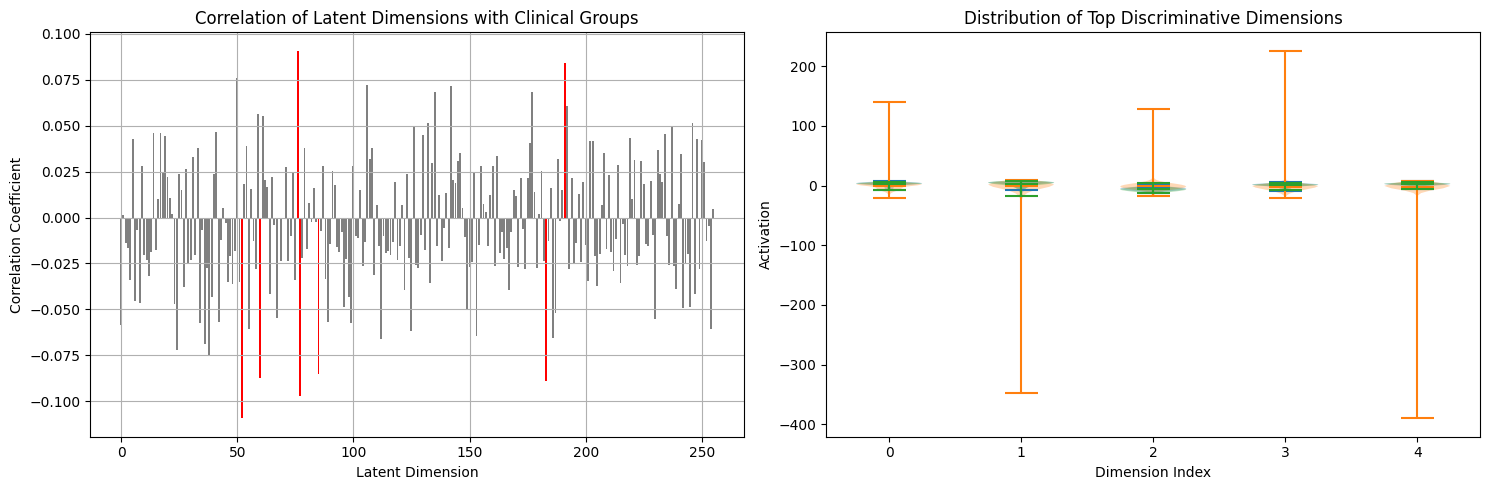


Top 5 Most Discriminative Dimensions:

Dimension 60:
Correlation: -0.087
P-value: 3.312e-02

Dimension 183:
Correlation: -0.089
P-value: 2.991e-02

Dimension 76:
Correlation: 0.091
P-value: 2.646e-02

Dimension 77:
Correlation: -0.097
P-value: 1.745e-02

Dimension 52:
Correlation: -0.109
P-value: 7.482e-03


In [ ]:
# Cell 17: Latent Space Clinical Correlation
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_latent_clinical_correlation(latent_vectors, labels):
    """
    Analyze correlation between latent dimensions and clinical groups
    """
    # Convert labels to numeric for correlation analysis
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    numeric_labels = np.array([label_mapping[label] for label in labels])

    # Calculate correlation between each latent dimension and the clinical groups
    correlations = []
    p_values = []

    for dim_idx in range(latent_vectors.shape[1]):
        corr, p_val = spearmanr(latent_vectors[:, dim_idx], numeric_labels)
        correlations.append(corr)
        p_values.append(p_val)

    # Plot correlation heatmap
    plt.figure(figsize=(15, 5))

    # Plot correlations
    plt.subplot(1, 2, 1)
    significant_dims = np.array(p_values) < 0.05
    plt.bar(range(len(correlations)), correlations,
            color=['red' if sig else 'gray' for sig in significant_dims])
    plt.title('Correlation of Latent Dimensions with Clinical Groups')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)

    # Plot most discriminative dimensions
    top_dims = np.argsort(np.abs(correlations))[-5:]
    plt.subplot(1, 2, 2)
    for label in np.unique(labels):
        mask = labels == label
        values = latent_vectors[mask][:, top_dims]
        plt.violinplot(values, positions=range(len(top_dims)),
                      showmeans=True, showextrema=True)

    plt.title('Distribution of Top Discriminative Dimensions')
    plt.xlabel('Dimension Index')
    plt.ylabel('Activation')
    plt.tight_layout()
    plt.show()

    # Print summary of most significant dimensions
    print("\nTop 5 Most Discriminative Dimensions:")
    for dim_idx in top_dims:
        print(f"\nDimension {dim_idx}:")
        print(f"Correlation: {correlations[dim_idx]:.3f}")
        print(f"P-value: {p_values[dim_idx]:.3e}")

# Run the analysis
if __name__ == "__main__":
    print("Analyzing latent space clinical correlations...")
    analyze_latent_clinical_correlation(latent_vecs, labels)

### Synthetic Brain Generation

In [ ]:
# Cell 18: Synthetic Brain Generation
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_synthetic_brain(model, dataloader, condition='PD', num_samples=5):
    """
    Generate synthetic brain scans by manipulating the latent space

    Args:
        model: Trained autoencoder model
        dataloader: DataLoader containing the validation set
        condition: Target condition ('PD', 'Control', or 'SWEDD')
        num_samples: Number of synthetic samples to generate
    """
    device = next(model.parameters()).device
    model.eval()

    # First, get latent representations of real brains
    print("Extracting latent representations...")
    latent_vectors = []
    conditions = []

    with torch.no_grad():
        for batch in dataloader:
            volumes = batch['volume'].to(device)
            labels = batch['label']

            # Get latent vectors
            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            conditions.extend(labels)

            del volumes, z
            torch.cuda.empty_cache()

    latent_vectors = np.vstack(latent_vectors)
    conditions = np.array(conditions)

    # Calculate mean and covariance of latent vectors for target condition
    target_mask = conditions == condition
    target_vectors = latent_vectors[target_mask]
    latent_mean = np.mean(target_vectors, axis=0)
    latent_cov = np.cov(target_vectors.T)

    # Generate new latent vectors by sampling from learned distribution
    print(f"\nGenerating synthetic {condition} brains...")
    synthetic_vectors = np.random.multivariate_normal(
        latent_mean,
        latent_cov + 1e-6 * np.eye(latent_cov.shape[0]),  # Add small value to ensure positive definiteness
        size=num_samples
    )

    # Convert to torch tensor and move to device
    synthetic_vectors = torch.tensor(synthetic_vectors, dtype=torch.float32).to(device)

    # Generate synthetic brains using decoder
    with torch.no_grad():
        synthetic_brains = model.decode(synthetic_vectors)

    # Visualize results
    fig = plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        brain = synthetic_brains[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Synthetic {condition} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Synthetic {condition} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Synthetic {condition} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return synthetic_brains

def interpolate_between_conditions(model, dataloader, start_condition='Control', end_condition='PD', steps=5):
    """
    Generate interpolated brains between two conditions
    """
    device = next(model.parameters()).device
    model.eval()

    # Get latent representations
    print("Extracting latent representations...")
    latent_vectors = []
    conditions = []

    with torch.no_grad():
        for batch in dataloader:
            volumes = batch['volume'].to(device)
            labels = batch['label']

            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            conditions.extend(labels)

            del volumes, z
            torch.cuda.empty_cache()

    latent_vectors = np.vstack(latent_vectors)
    conditions = np.array(conditions)

    # Get mean latent vectors for both conditions
    start_mean = np.mean(latent_vectors[conditions == start_condition], axis=0)
    end_mean = np.mean(latent_vectors[conditions == end_condition], axis=0)

    # Create interpolation steps
    alphas = np.linspace(0, 1, steps)
    interpolated_vectors = np.array([
        (1 - alpha) * start_mean + alpha * end_mean
        for alpha in alphas
    ])

    # Generate interpolated brains
    interpolated_vectors = torch.tensor(interpolated_vectors, dtype=torch.float32).to(device)

    with torch.no_grad():
        interpolated_brains = model.decode(interpolated_vectors)

    # Visualize interpolation
    fig = plt.figure(figsize=(15, 3*steps))

    for i in range(steps):
        brain = interpolated_brains[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(steps, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(steps, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(steps, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.suptitle(f'Interpolation from {start_condition} to {end_condition}')
    plt.tight_layout()
    plt.show()

    return interpolated_brains

# Run the generation
if __name__ == "__main__":
    # Load model
    model, _ = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Generate synthetic brains for each condition
    print("\nGenerating synthetic Control brains...")
    synthetic_control = generate_synthetic_brain(model, val_loader, condition='Control')

    print("\nGenerating synthetic PD brains...")
    synthetic_pd = generate_synthetic_brain(model, val_loader, condition='PD')

    print("\nGenerating synthetic SWEDD brains...")
    synthetic_swedd = generate_synthetic_brain(model, val_loader, condition='SWEDD')

    # Generate interpolation between conditions
    print("\nGenerating interpolation from Control to PD...")
    interpolated = interpolate_between_conditions(model, val_loader)


Generating synthetic Control brains...
Extracting latent representations...


KeyboardInterrupt: 

## 2. Variational Autoencoder (VAE)

### Model Setup

In [15]:
# Cell 19: VAE Model Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class VAE(nn.Module):
    """
    3D Variational Autoencoder optimized for 128³ medical volumes with
    memory-efficient implementation for NVIDIA 4070Ti.
    """
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        # Enable CUDNN benchmarking for optimal performance
        torch.backends.cudnn.benchmark = True

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to enable backpropagation through sampling.
        """
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x):
        # Encode input to get mean and variance of latent distribution
        mu, log_var, skip_connections = self.encoder(x)

        # Sample from latent distribution
        z = self.reparameterize(mu, log_var)

        # Decode sampled latent vector
        reconstruction = self.decoder(z, skip_connections)

        return reconstruction, mu, log_var

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class VAEEncoder(nn.Module):
    """3D Encoder network with probabilistic latent space."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )

        # Project to latent parameters
        self.flatten_size = 256 * 8 * 8 * 8
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        # Initial convolution
        x = self.init_conv(x)

        # Downsampling with skip connections
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent parameters
        flat = torch.flatten(d4, start_dim=1)
        mu = self.fc_mu(flat)
        log_var = self.fc_var(flat)

        return mu, log_var, (d1, d2, d3, d4)

class VAEDecoder(nn.Module):
    """3D Decoder network with skip connections."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path with skip connections
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),   # 16 -> 32
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),    # 32 -> 64
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 64 -> 128
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z, skip_connections):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8, 8)

        # Unpack skip connections
        d1, d2, d3, d4 = skip_connections

        # Upsampling with skip connections
        x = self.up1(x + d4)
        x = self.up2(x + d3)
        x = self.up3(x + d2)
        x = self.up4(x + d1)

        # Final convolution with sigmoid activation
        x = torch.sigmoid(self.final_conv(x))

        return x

In [16]:
# Cell 20: VAE Loss Function Implementation
class VAELoss:
    """
    Custom loss function for VAE combining reconstruction loss and KL divergence.
    Implements β-VAE formulation with annealing for better training stability.
    """
    def __init__(self, beta_start=0.0, beta_end=1.0, beta_steps=10000):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_steps = beta_steps
        self.current_step = 0

    def __call__(self, recon_x, x, mu, log_var):
        """
        Compute VAE loss with annealed β-VAE formulation.

        Args:
            recon_x: Reconstructed volume
            x: Original volume
            mu: Mean of latent distribution
            log_var: Log variance of latent distribution
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')

        # KL divergence
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        # Calculate beta for current step
        beta = min(self.beta_end,
                  self.beta_start + (self.beta_end - self.beta_start) *
                  (self.current_step / self.beta_steps))

        # Increment step
        self.current_step += 1

        # Total loss
        total_loss = recon_loss + beta * kl_loss

        return total_loss, recon_loss, kl_loss, beta

In [17]:
# Cell 21: Training Configuration and Utilities
from tqdm.notebook import tqdm
import os
from pathlib import Path
import json
import time

class VAEConfig:
    """Configuration for VAE training."""
    def __init__(self):
        # Model parameters
        self.latent_dim = 256
        self.learning_rate = 1e-4

        # Training parameters
        self.batch_size = 8  # Conservative batch size for 12GB VRAM
        self.epochs = 100
        self.accumulation_steps = 4  # Gradient accumulation for effective batch size of 32

        # Loss parameters
        self.beta_start = 0.0
        self.beta_end = 1.0
        self.beta_steps = 10000

        # Early stopping
        self.patience = 10
        self.min_delta = 1e-6

        # Optimization
        self.use_amp = True  # Automatic mixed precision
        self.num_workers = 4
        self.pin_memory = True

        # Checkpoint configuration
        self.checkpoint_dir = 'checkpoints'
        self.model_name = 'vae'
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses):
        """Save model checkpoint and training metadata"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, self.checkpoint_path)

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer, scheduler):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            return None

        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }


In [18]:
# Cell 22: Training Loop
def train_vae(model, train_loader, val_loader, config=None):
    """Training loop with memory optimization for 4070Ti."""
    if config is None:
        config = VAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = VAELoss(config.beta_start, config.beta_end, config.beta_steps)
    optimizer = create_vae_optimizer(model, config)
    scheduler = create_vae_scheduler(optimizer)
    scaler = torch.cuda.amp.GradScaler(enabled=config.use_amp)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_recon_loss = 0
            train_kl_loss = 0

            train_pbar = tqdm(train_loader,
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False)

            for i, batch in enumerate(train_pbar):
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)

                    # Forward pass with mixed precision
                    with torch.cuda.amp.autocast(enabled=config.use_amp):
                        recon, mu, log_var = model(volumes)
                        loss, recon_l, kl_l, beta = criterion(recon, volumes, mu, log_var)
                        loss = loss / config.accumulation_steps

                    # Backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (i + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track losses
                    train_loss += loss.item() * config.accumulation_steps
                    train_recon_loss += recon_l.item()
                    train_kl_loss += kl_l.item()

                    # Update progress bar
                    train_pbar.set_postfix({
                        'loss': loss.item() * config.accumulation_steps,
                        'recon': recon_l.item(),
                        'kl': kl_l.item(),
                        'beta': beta
                    })

                    # Clean up
                    del volumes, recon, mu, log_var
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {i}. Cleaning up...")
                        if 'volumes' in locals():
                            del volumes
                        if 'recon' in locals():
                            del recon
                        torch.cuda.empty_cache()
                        continue
                    raise e

            # Validation phase
            model.eval()
            val_loss = 0

            val_pbar = tqdm(val_loader,
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        recon, mu, log_var = model(volumes)
                        loss, _, _, _ = criterion(recon, volumes, mu, log_var)
                        val_loss += loss.item()

                        val_pbar.set_postfix({'loss': loss.item()})

                        del volumes, recon, mu, log_var
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'recon' in locals():
                                del recon
                            torch.cuda.empty_cache()
                            continue
                        raise e

            # Calculate average losses
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save checkpoint
            checkpoint_handler.save(
                model, optimizer, scheduler,
                epoch, train_losses, val_losses
            )

            # Early stopping check
            if avg_val_loss < best_val_loss - config.min_delta:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(),
                         os.path.join(config.checkpoint_dir, f'{config.model_name}_best.pth'))
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break

            # Print epoch summary
            print(f"\nEpoch [{epoch+1}/{config.epochs}]")
            print(f"Train Loss: {avg_train_loss:.6f}")
            print(f"Val Loss: {avg_val_loss:.6f}")
            print(f"Beta: {beta:.4f}")
            print_gpu_memory_stats()  # From previous implementation

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

    return train_losses, val_losses

def create_vae_optimizer(model, config):
    """Create optimizer for VAE training."""
    return torch.optim.Adam(model.parameters(), lr=config.learning_rate)

def create_vae_scheduler(optimizer):
    """Create learning rate scheduler for VAE training."""
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

### Training

Resuming training from epoch 52


Epoch 53/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [53/100]
Train Loss: 0.000113
Val Loss: 0.000046
Beta: 0.1193
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 54/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [54/100]
Train Loss: 0.000112
Val Loss: 0.000090
Beta: 0.2686
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 55/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [55/100]
Train Loss: 0.000117
Val Loss: 0.000053
Beta: 0.4179
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 56/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [56/100]
Train Loss: 0.000114
Val Loss: 0.000045
Beta: 0.5672
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 57/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [57/100]
Train Loss: 0.000109
Val Loss: 0.000047
Beta: 0.7165
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 58/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [58/100]
Train Loss: 0.000106
Val Loss: 0.000040
Beta: 0.8658
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 59/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [59/100]
Train Loss: 4588.567946
Val Loss: 0.000051
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 60/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [60/100]
Train Loss: 0.000808
Val Loss: 0.011245
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 61/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [61/100]
Train Loss: 0.010327
Val Loss: 0.001444
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 62/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [62/100]
Train Loss: 0.000351
Val Loss: 0.000626
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 63/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [63/100]
Train Loss: 0.430868
Val Loss: 0.000305
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 64/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [64/100]
Train Loss: 0.007675
Val Loss: 0.000456
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 65/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [65/100]
Train Loss: 0.000297
Val Loss: 0.000282
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 66/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [66/100]
Train Loss: 0.000260
Val Loss: 0.000251
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 67/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch [67/100]
Train Loss: 0.000247
Val Loss: 0.000249
Beta: 1.0000
GPU Memory Allocated: 1638.83 MB
GPU Memory Reserved: 2054.00 MB


Epoch 68/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Early stopping triggered at epoch 68


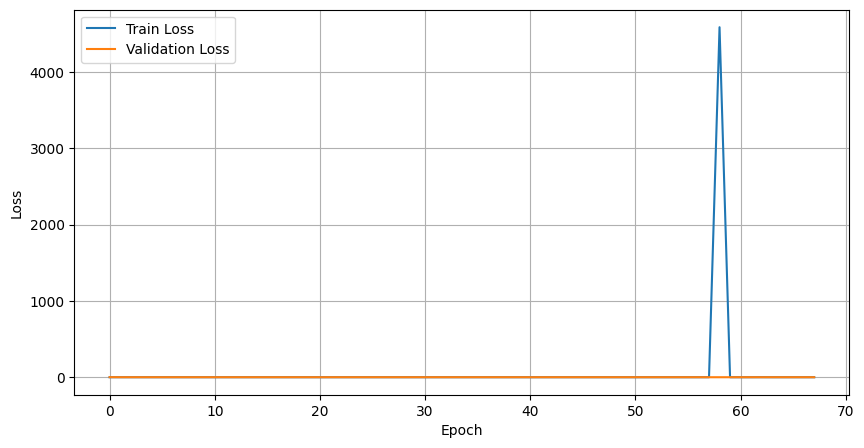

In [ ]:
# TRAINING

if __name__ == "__main__":
    # Initialize model and config
    model = VAE()
    config = VAEConfig()

    # Train model
    train_losses, val_losses = train_vae(model, train_loader, val_loader, config)

In [35]:
# Cell 23: Model Evaluation and Reconstruction Visualization
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def load_trained_vae(checkpoint_dir, model_name='vae'):
    """Load trained VAE model and metadata"""
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"

    # Load model
    model = VAE()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load training history
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, metadata

def visualize_reconstructions(model, val_loader, num_samples=3):
    """Visualize original vs reconstructed volumes with added uncertainty visualization"""
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            # Generate multiple reconstructions to assess variance
            reconstructions = []
            for _ in range(5):  # Generate 5 reconstructions per sample
                recon, _, _ = model(volumes)
                reconstructions.append(recon.cpu().numpy())
            reconstructions = np.stack(reconstructions)

            # Process num_samples samples
            for idx in range(min(num_samples, volumes.shape[0])):
                fig = plt.figure(figsize=(15, 8))

                # Get middle slices
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_mean = reconstructions[:, idx, 0].mean(axis=0)
                recon_std = reconstructions[:, idx, 0].std(axis=0)

                # Plot axial, sagittal, and coronal views
                views = ['Axial', 'Sagittal', 'Coronal']
                slices_orig = [
                    orig_vol[orig_vol.shape[0]//2, :, :],
                    orig_vol[:, orig_vol.shape[1]//2, :],
                    orig_vol[:, :, orig_vol.shape[2]//2]
                ]
                slices_recon = [
                    recon_mean[recon_mean.shape[0]//2, :, :],
                    recon_mean[:, recon_mean.shape[1]//2, :],
                    recon_mean[:, :, recon_mean.shape[2]//2]
                ]
                slices_std = [
                    recon_std[recon_std.shape[0]//2, :, :],
                    recon_std[:, recon_std.shape[1]//2, :],
                    recon_std[:, :, recon_std.shape[2]//2]
                ]

                for i, (view, orig_slice, recon_slice, std_slice) in enumerate(zip(views, slices_orig, slices_recon, slices_std)):
                    # Original
                    plt.subplot(3, 3, i+1)
                    plt.imshow(orig_slice, cmap='gray')
                    plt.title(f'Original {view}')
                    plt.axis('off')

                    # Reconstructed
                    plt.subplot(3, 3, i+4)
                    plt.imshow(recon_slice, cmap='gray')
                    plt.title(f'Reconstructed {view}')
                    plt.axis('off')

                    # Uncertainty
                    plt.subplot(3, 3, i+7)
                    plt.imshow(std_slice, cmap='viridis')
                    plt.title(f'Uncertainty {view}')
                    plt.colorbar()
                    plt.axis('off')

                plt.suptitle(f'Sample {idx+1} - Original vs Reconstructed with Uncertainty', y=1.02)
                plt.tight_layout()
                plt.show()

            break  # Only process first batch

In [ ]:
# Cell 24: Quantitative Metrics
def compute_metrics(model, val_loader):
    """Compute quantitative metrics including reconstruction error and KL divergence"""
    device = next(model.parameters()).device
    mse_criterion = nn.MSELoss(reduction='none')

    total_mse = 0
    total_kl = 0
    total_samples = 0

    region_errors = {
        'Left Striatum': [],
        'Right Striatum': [],
        'Background': []
    }

    # Define regions of interest (approximate coordinates for DaTSCAN)
    regions = {
        'Left Striatum': (slice(54, 74), slice(54, 74), slice(44, 64)),
        'Right Striatum': (slice(54, 74), slice(54, 74), slice(64, 84)),
        'Background': (slice(0, 20), slice(0, 20), slice(0, 20))
    }

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            recon, mu, log_var = model(volumes)

            # Overall MSE
            mse = mse_criterion(recon, volumes).mean(dim=(1,2,3,4))

            # KL divergence
            kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)

            total_mse += mse.sum().item()
            total_kl += kl.sum().item()
            total_samples += volumes.shape[0]

            # Region-specific analysis
            for vol_idx in range(volumes.shape[0]):
                orig = volumes[vol_idx, 0].cpu().numpy()
                recon_vol = recon[vol_idx, 0].cpu().numpy()

                for region_name, coords in regions.items():
                    orig_region = orig[coords]
                    recon_region = recon_vol[coords]
                    mse = np.mean((orig_region - recon_region) ** 2)
                    region_errors[region_name].append(mse)

    # Calculate average metrics
    avg_mse = total_mse / total_samples
    avg_kl = total_kl / total_samples

    print(f"\nOverall Metrics:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average KL Divergence: {avg_kl:.6f}")
    print(f"RMSE: {np.sqrt(avg_mse):.6f}")

    print("\nRegion-Specific MSE:")
    for region in regions.keys():
        errors = region_errors[region]
        print(f"\n{region}:")
        print(f"Mean MSE: {np.mean(errors):.6f}")
        print(f"Std MSE: {np.std(errors):.6f}")
        print(f"Min MSE: {np.min(errors):.6f}")
        print(f"Max MSE: {np.max(errors):.6f}")

    return avg_mse, avg_kl, region_errors

In [ ]:
# Cell 25: Latent Space Analysis
def analyze_latent_space(model, val_loader, num_samples=1000):
    """Analyze the structure of the learned latent space"""
    device = next(model.parameters()).device
    latent_vectors = []
    labels = []
    reconstructions = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Collecting latent vectors"):
            volumes = batch['volume'].to(device)
            mu, log_var, _ = model.encoder(volumes)
            z = model.reparameterize(mu, log_var)

            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch['label'])

            if len(np.concatenate(latent_vectors)) >= num_samples:
                break

    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.array(labels[:num_samples])

    # Plot latent space distribution
    plt.figure(figsize=(15, 5))

    # Plot distribution of first two dimensions
    plt.subplot(131)
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels.astype('category').cat.codes, alpha=0.6)
    plt.title('First Two Latent Dimensions')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Plot average activation per dimension
    plt.subplot(132)
    avg_activation = np.mean(np.abs(latent_vectors), axis=0)
    plt.bar(range(len(avg_activation)), avg_activation)
    plt.title('Average Activation per Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Average Activation')

    # Plot variance explained
    plt.subplot(133)
    var_explained = np.var(latent_vectors, axis=0)
    plt.plot(np.cumsum(var_explained) / np.sum(var_explained))
    plt.title('Cumulative Variance Explained')
    plt.xlabel('Number of Dimensions')
    plt.ylabel('Cumulative Variance Ratio')

    plt.tight_layout()
    plt.show()

    return latent_vectors, labels

Visualizing reconstructions...


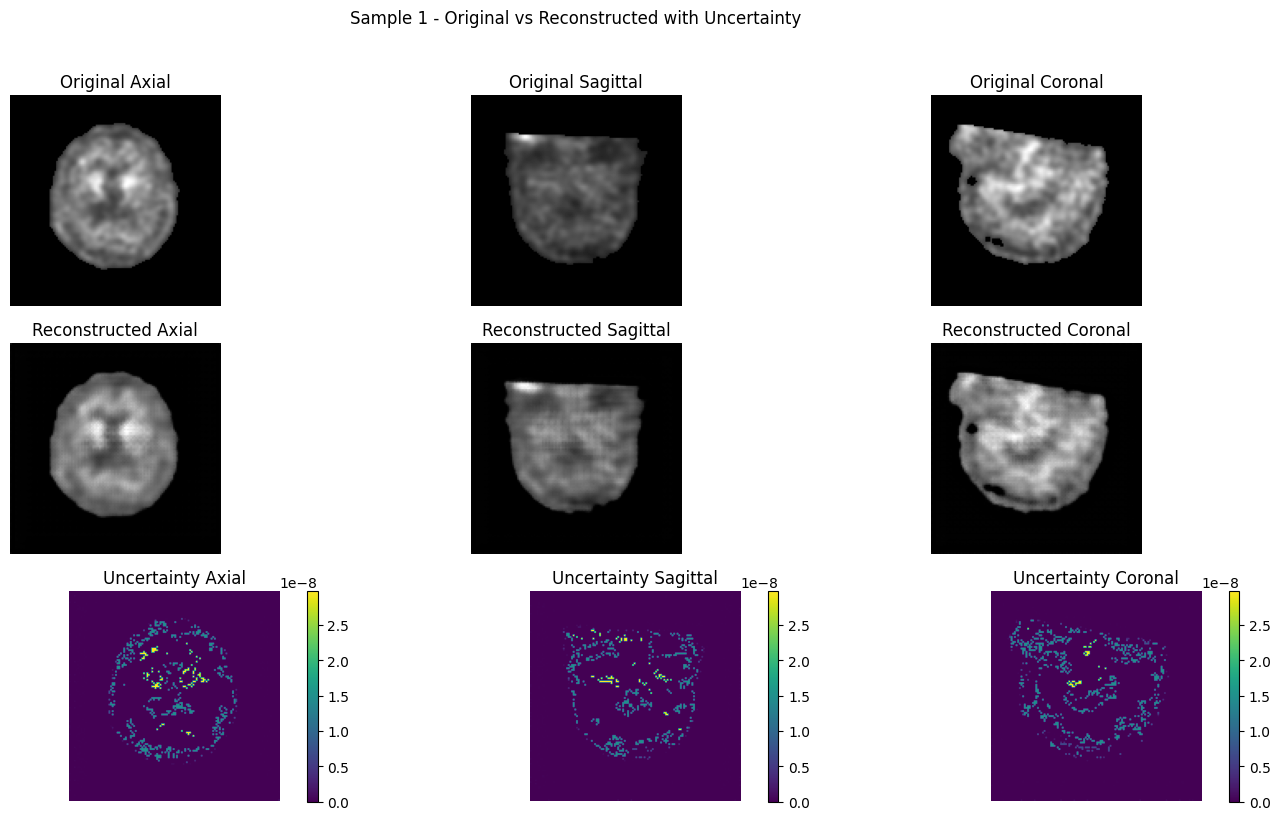

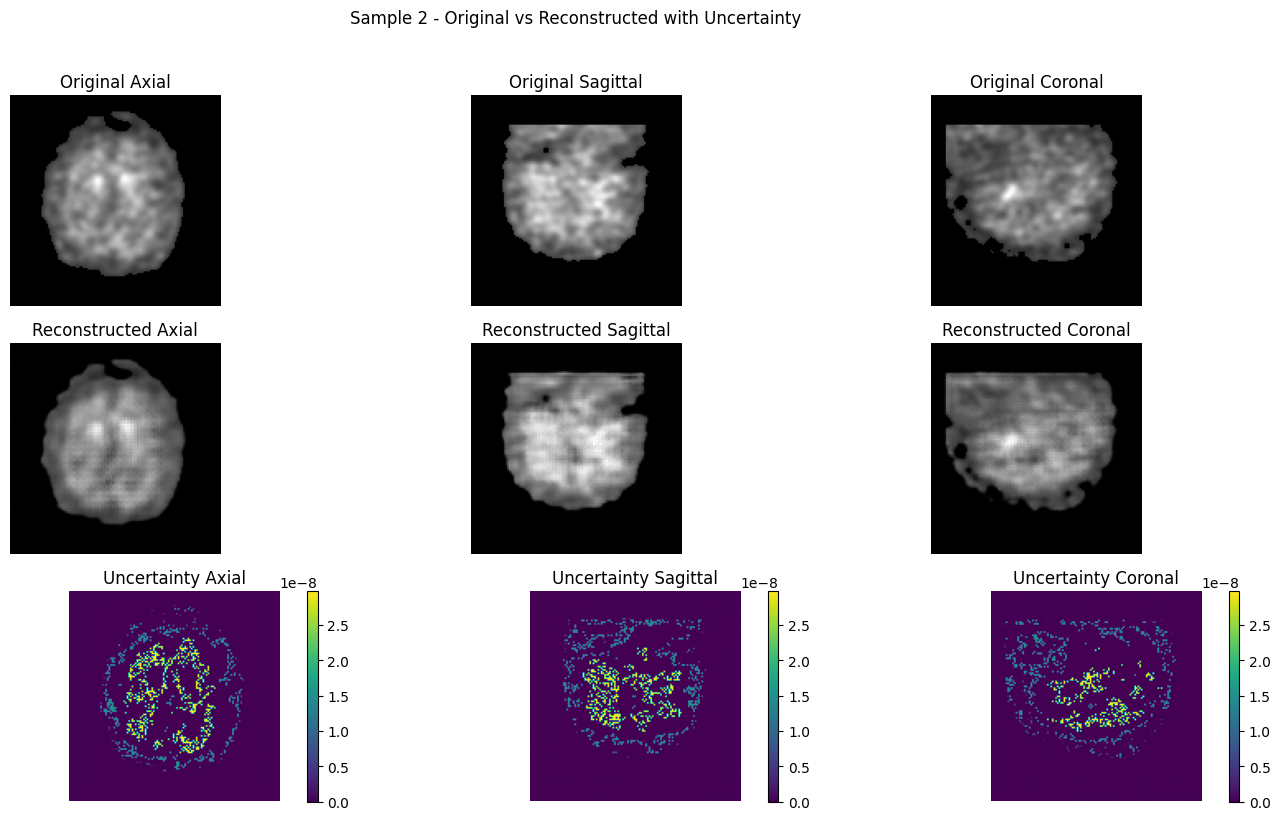


Computing metrics...


Computing metrics:   0%|          | 0/299 [00:00<?, ?it/s]


Overall Metrics:
Average MSE: 0.000141
Average KL Divergence: 0.028011
RMSE: 0.011863

Region-Specific MSE:

Left Striatum:
Mean MSE: 0.000907
Std MSE: 0.005462
Min MSE: 0.000003
Max MSE: 0.114640

Right Striatum:
Mean MSE: 0.000908
Std MSE: 0.005310
Min MSE: 0.000003
Max MSE: 0.119625

Background:
Mean MSE: 0.000027
Std MSE: 0.000000
Min MSE: 0.000027
Max MSE: 0.000028

Analyzing latent space...


TypeError: data type 'category' not understood

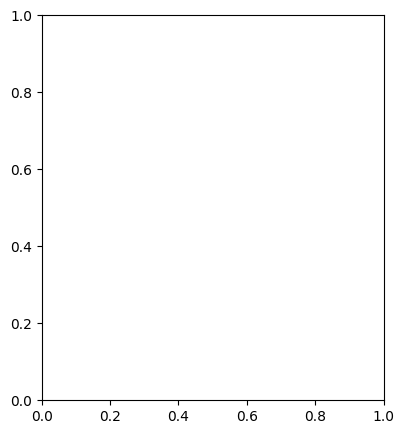

In [ ]:
# Cell 26: Run Evaluation
if __name__ == "__main__":
    # Load trained model
    model, metadata = load_trained_vae('checkpoints')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("Visualizing reconstructions...")
    visualize_reconstructions(model, val_loader)

    print("\nComputing metrics...")
    avg_mse, avg_kl, region_errors = compute_metrics(model, val_loader)

    print("\nAnalyzing latent space...")
    latent_vectors, labels = analyze_latent_space(model, val_loader)

## 3. AE Semi-Supervised

### Model Setup

In [19]:
# Cell 27: Semi-Supervised Model Architecture
# Common imports
import os
import time
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import OrderedDict

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

# Sklearn imports
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
import seaborn as sns

class SemiSupervisedAE(nn.Module):
    """
    Semi-supervised autoencoder with classification branch.
    Optimized for 128³ medical volumes on NVIDIA 4070Ti.
    """
    def __init__(self, latent_dim=256, num_classes=3):
        super().__init__()
        self.encoder = SSEncoder(latent_dim)
        self.decoder = SSDecoder(latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        torch.backends.cudnn.benchmark = True

    def forward(self, x):
        # Encode input
        z, skip_connections = self.encoder(x)

        # Generate reconstruction
        reconstruction = self.decoder(z, skip_connections)

        # Generate classification
        classification = self.classifier(z)

        return reconstruction, classification, z

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))
        ]))

    def forward(self, x):
        return self.block(x)

class SSEncoder(nn.Module):
    """Encoder network with shared features for reconstruction and classification."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128

        # Downsampling path
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )

        # Project to latent space
        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent space
        flat = torch.flatten(d4, start_dim=1)
        z = self.fc(flat)

        return z, (d1, d2, d3, d4)

class SSDecoder(nn.Module):
    """Decoder network for reconstruction."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),   # 16 -> 32
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),    # 32 -> 64
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 64 -> 128
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z, skip_connections):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8, 8)

        # Unpack skip connections
        d1, d2, d3, d4 = skip_connections

        # Upsampling with skip connections
        x = self.up1(x + d4)
        x = self.up2(x + d3)
        x = self.up3(x + d2)
        x = self.up4(x + d1)

        # Final convolution with sigmoid activation
        x = torch.sigmoid(self.final_conv(x))

        return x

In [20]:
# Cell 28: Training Configuration
class SSAEConfig:
    """Configuration for semi-supervised training."""
    def __init__(self):
        # Model parameters
        self.latent_dim = 256
        self.num_classes = 3
        self.learning_rate = 1e-4

        # Loss weights
        self.recon_weight = 1.0
        self.class_weight = 0.5

        # Training parameters
        self.batch_size = 8
        self.epochs = 100
        self.accumulation_steps = 4

        # Early stopping
        self.patience = 10
        self.min_delta = 1e-6

        # Optimization
        self.use_amp = True
        self.num_workers = 4
        self.pin_memory = True

        # Checkpoint configuration
        self.checkpoint_dir = 'checkpoints'
        self.model_name = 'ssae'
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class SSAELoss:
    """Combined loss for semi-supervised training."""
    def __init__(self, recon_weight=1.0, class_weight=0.5):
        self.recon_weight = recon_weight
        self.class_weight = class_weight
        self.recon_criterion = nn.MSELoss()
        self.class_criterion = nn.CrossEntropyLoss()

    def __call__(self, recon, target, class_pred, class_target):
        recon_loss = self.recon_criterion(recon, target)
        class_loss = self.class_criterion(class_pred, class_target)

        total_loss = (self.recon_weight * recon_loss +
                     self.class_weight * class_loss)

        return total_loss, recon_loss, class_loss

In [21]:
# Cell 29: Label Processing
def process_labels(labels):
    """Convert string labels to tensor indices."""
    label_map = {'Control': 0, 'PD': 1, 'SWEDD': 2}
    return torch.tensor([label_map[label] for label in labels])

def create_class_weights(dataloader):
    """Calculate class weights for balanced training."""
    label_counts = torch.zeros(3)
    for batch in dataloader:
        labels = process_labels(batch['label'])
        for label in labels:
            label_counts[label] += 1

    total = label_counts.sum()
    class_weights = total / (3 * label_counts)
    return class_weights



In [22]:
# Cell 30: Checkpoint Handler
class SSAECheckpointHandler:
    """Handles saving and loading of model checkpoints."""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"

    def save(self, model, optimizer, scheduler, epoch, metrics):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'metrics': metrics
        }
        torch.save(checkpoint, self.checkpoint_path)

        metadata = {
            'last_epoch': epoch,
            'metrics': metrics,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer, scheduler):
        if not self.checkpoint_path.exists():
            return None

        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        return checkpoint['epoch'], checkpoint['metrics']

In [23]:
# Cell 31: Training Loop
import torch.cuda.amp as amp
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def train_ssae(model, train_loader, val_loader, config=None):
    """Training loop with memory optimization for NVIDIA 4070Ti."""
    if config is None:
        config = SSAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = SSAELoss(config.recon_weight, config.class_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    scaler = amp.GradScaler(enabled=config.use_amp)
    checkpoint_handler = SSAECheckpointHandler(config.checkpoint_dir, config.model_name)

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    metrics = {
        'train_losses': [], 'val_losses': [],
        'train_recon': [], 'val_recon': [],
        'train_class': [], 'val_class': [],
        'train_acc': [], 'val_acc': []
    }

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch, metrics = checkpoint_data
        print(f"Resuming training from epoch {start_epoch + 1}")

    try:
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            train_loss = train_recon = train_class = 0
            correct_preds = total_preds = 0

            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')

            for i, batch in enumerate(train_pbar):
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)
                    labels = process_labels(batch['label']).to(device)

                    # Forward pass with mixed precision
                    with amp.autocast(enabled=config.use_amp):
                        recon, class_pred, _ = model(volumes)
                        loss, recon_l, class_l = criterion(recon, volumes, class_pred, labels)
                        loss = loss / config.accumulation_steps

                    # Backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (i + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track metrics
                    train_loss += loss.item() * config.accumulation_steps
                    train_recon += recon_l.item()
                    train_class += class_l.item()

                    # Track accuracy
                    pred = class_pred.argmax(dim=1)
                    correct_preds += (pred == labels).sum().item()
                    total_preds += labels.size(0)

                    # Update progress bar
                    train_pbar.set_postfix({
                        'loss': loss.item() * config.accumulation_steps,
                        'recon': recon_l.item(),
                        'class': class_l.item(),
                        'acc': correct_preds/total_preds
                    })

                    # Clean up
                    del volumes, labels, recon, class_pred
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {i}. Cleaning up...")
                        if 'volumes' in locals():
                            del volumes
                        if 'recon' in locals():
                            del recon
                        torch.cuda.empty_cache()
                        continue
                    raise e

            # Validation phase
            model.eval()
            val_loss = val_recon = val_class = 0
            val_correct = val_total = 0
            all_preds = []
            all_labels = []

            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Val]')


            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        labels = process_labels(batch['label']).to(device)

                        recon, class_pred, _ = model(volumes)
                        loss, recon_l, class_l = criterion(recon, volumes, class_pred, labels)

                        val_loss += loss.item()
                        val_recon += recon_l.item()
                        val_class += class_l.item()

                        # Track predictions for metrics
                        pred = class_pred.argmax(dim=1)
                        val_correct += (pred == labels).sum().item()
                        val_total += labels.size(0)

                        all_preds.extend(pred.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                        val_pbar.set_postfix({
                            'loss': loss.item(),
                            'acc': val_correct/val_total
                        })

                        del volumes, labels, recon, class_pred
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'recon' in locals():
                                del recon
                            torch.cuda.empty_cache()
                            continue
                        raise e

            # Calculate epoch metrics
            train_metrics = {
                'loss': train_loss / len(train_loader),
                'recon': train_recon / len(train_loader),
                'class': train_class / len(train_loader),
                'acc': correct_preds / total_preds
            }

            val_metrics = {
                'loss': val_loss / len(val_loader),
                'recon': val_recon / len(val_loader),
                'class': val_class / len(val_loader),
                'acc': val_correct / val_total
            }

            # Update tracking metrics
            metrics['train_losses'].append(train_metrics['loss'])
            metrics['val_losses'].append(val_metrics['loss'])
            metrics['train_recon'].append(train_metrics['recon'])
            metrics['val_recon'].append(val_metrics['recon'])
            metrics['train_class'].append(train_metrics['class'])
            metrics['val_class'].append(val_metrics['class'])
            metrics['train_acc'].append(train_metrics['acc'])
            metrics['val_acc'].append(val_metrics['acc'])

            # Update learning rate
            scheduler.step(val_metrics['loss'])

            # Save checkpoint
            checkpoint_handler.save(model, optimizer, scheduler, epoch, metrics)

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{config.epochs}")
            print("Training Metrics:")
            print(f"Loss: {train_metrics['loss']:.6f}")
            print(f"Recon Loss: {train_metrics['recon']:.6f}")
            print(f"Class Loss: {train_metrics['class']:.6f}")
            print(f"Accuracy: {train_metrics['acc']:.2%}")

            print("\nValidation Metrics:")
            print(f"Loss: {val_metrics['loss']:.6f}")
            print(f"Recon Loss: {val_metrics['recon']:.6f}")
            print(f"Class Loss: {val_metrics['class']:.6f}")
            print(f"Accuracy: {val_metrics['acc']:.2%}")

            # Early stopping check
            if val_metrics['loss'] < best_val_loss - config.min_delta:
                best_val_loss = val_metrics['loss']
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(),
                         os.path.join(config.checkpoint_dir, f'{config.model_name}_best.pth'))
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break

            # Print memory stats
            print("\nGPU Memory Stats:")
            print_gpu_memory_stats()

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plot_training_history(metrics)

    return metrics

def plot_training_history(metrics):
    """Plot training and validation metrics history."""
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot reconstruction loss
    plt.subplot(2, 2, 2)
    plt.plot(metrics['train_recon'], label='Train Recon')
    plt.plot(metrics['val_recon'], label='Val Recon')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot classification loss
    plt.subplot(2, 2, 3)
    plt.plot(metrics['train_class'], label='Train Class')
    plt.plot(metrics['val_class'], label='Val Class')
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(2, 2, 4)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [24]:
# Cell 32: Model Evaluation
def evaluate_model(model, val_loader, config=None):
    """Comprehensive model evaluation including reconstruction and classification metrics."""
    if config is None:
        config = SSAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Initialize metrics
    val_recon_loss = 0
    val_class_loss = 0
    all_preds = []
    all_labels = []
    reconstructions = []
    originals = []

    criterion = SSAELoss(config.recon_weight, config.class_weight)

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            volumes = batch['volume'].to(device)
            labels = process_labels(batch['label']).to(device)

            recon, class_pred, _ = model(volumes)
            _, recon_l, class_l = criterion(recon, volumes, class_pred, labels)

            val_recon_loss += recon_l.item()
            val_class_loss += class_l.item()

            pred = class_pred.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store some examples for visualization
            if len(reconstructions) < 5:
                reconstructions.append(recon.cpu().numpy())
                originals.append(volumes.cpu().numpy())

    # Calculate average losses
    avg_recon_loss = val_recon_loss / len(val_loader)
    avg_class_loss = val_class_loss / len(val_loader)

    # Print classification report
    label_names = ['Control', 'PD', 'SWEDD']
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Visualize reconstructions
    visualize_reconstructions(originals, reconstructions, label_names,
                            [label_names[l] for l in all_labels[:5]])

    return {
        'recon_loss': avg_recon_loss,
        'class_loss': avg_class_loss,
        'predictions': all_preds,
        'true_labels': all_labels
    }

def visualize_reconstructions(originals, reconstructions, label_names, true_labels):
    """Visualize original vs reconstructed volumes."""
    num_samples = len(originals)
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        orig = originals[i][0]
        recon = reconstructions[i][0]

        # Get middle slices
        orig_axial = orig[orig.shape[0]//2, :, :]
        orig_sagittal = orig[:, orig.shape[1]//2, :]
        orig_coronal = orig[:, :, orig.shape[2]//2]

        recon_axial = recon[recon.shape[0]//2, :, :]
        recon_sagittal = recon[:, recon.shape[1]//2, :]
        recon_coronal = recon[:, :, recon.shape[2]//2]

        # Plot original
        plt.subplot(num_samples, 6, i*6 + 1)
        plt.imshow(orig_axial, cmap='gray')
        plt.title(f'Original Axial\n{true_labels[i]}' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 2)
        plt.imshow(orig_sagittal, cmap='gray')
        plt.title('Original Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 3)
        plt.imshow(orig_coronal, cmap='gray')
        plt.title('Original Coronal' if i == 0 else '')
        plt.axis('off')

        # Plot reconstruction
        plt.subplot(num_samples, 6, i*6 + 4)
        plt.imshow(recon_axial, cmap='gray')
        plt.title('Reconstructed Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 5)
        plt.imshow(recon_sagittal, cmap='gray')
        plt.title('Reconstructed Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 6)
        plt.imshow(recon_coronal, cmap='gray')
        plt.title('Reconstructed Coronal' if i == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Training


Found existing checkpoint. Resuming training...
Resuming training from epoch 20


Epoch 20/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 20/100
Training Metrics:
Loss: 0.004083
Recon Loss: 0.000727
Class Loss: 0.006712
Accuracy: 99.87%

Validation Metrics:
Loss: 0.311842
Recon Loss: 0.000587
Class Loss: 0.622510
Accuracy: 90.80%

GPU Memory Stats:
GPU Memory Allocated: 1129.15 MB
GPU Memory Reserved: 1778.00 MB


Epoch 21/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 21/100
Training Metrics:
Loss: 0.014330
Recon Loss: 0.000715
Class Loss: 0.027230
Accuracy: 99.16%

Validation Metrics:
Loss: 0.311094
Recon Loss: 0.000526
Class Loss: 0.621136
Accuracy: 89.63%

GPU Memory Stats:
GPU Memory Allocated: 1129.15 MB
GPU Memory Reserved: 1778.00 MB


Epoch 22/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 22/100
Training Metrics:
Loss: 0.004857
Recon Loss: 0.000654
Class Loss: 0.008406
Accuracy: 99.75%

Validation Metrics:
Loss: 0.280130
Recon Loss: 0.000539
Class Loss: 0.559181
Accuracy: 90.13%

GPU Memory Stats:
GPU Memory Allocated: 1129.15 MB
GPU Memory Reserved: 1776.00 MB


Epoch 23/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 23/100
Training Metrics:
Loss: 0.003816
Recon Loss: 0.000638
Class Loss: 0.006355
Accuracy: 99.83%

Validation Metrics:
Loss: 0.327062
Recon Loss: 0.000514
Class Loss: 0.653096
Accuracy: 89.80%

GPU Memory Stats:
GPU Memory Allocated: 1129.15 MB
GPU Memory Reserved: 1778.00 MB


Epoch 24/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 24/100
Training Metrics:
Loss: 0.003015
Recon Loss: 0.000617
Class Loss: 0.004796
Accuracy: 99.92%

Validation Metrics:
Loss: 0.321170
Recon Loss: 0.000461
Class Loss: 0.641419
Accuracy: 89.46%

GPU Memory Stats:
GPU Memory Allocated: 1129.15 MB
GPU Memory Reserved: 1778.00 MB


Epoch 25/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 25/100
Training Metrics:
Loss: 0.002813
Recon Loss: 0.000591
Class Loss: 0.004445
Accuracy: 99.96%

Validation Metrics:
Loss: 0.328833
Recon Loss: 0.000448
Class Loss: 0.656769
Accuracy: 89.80%

GPU Memory Stats:
GPU Memory Allocated: 1129.15 MB
GPU Memory Reserved: 1778.00 MB


Epoch 26/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]


Training interrupted by user!


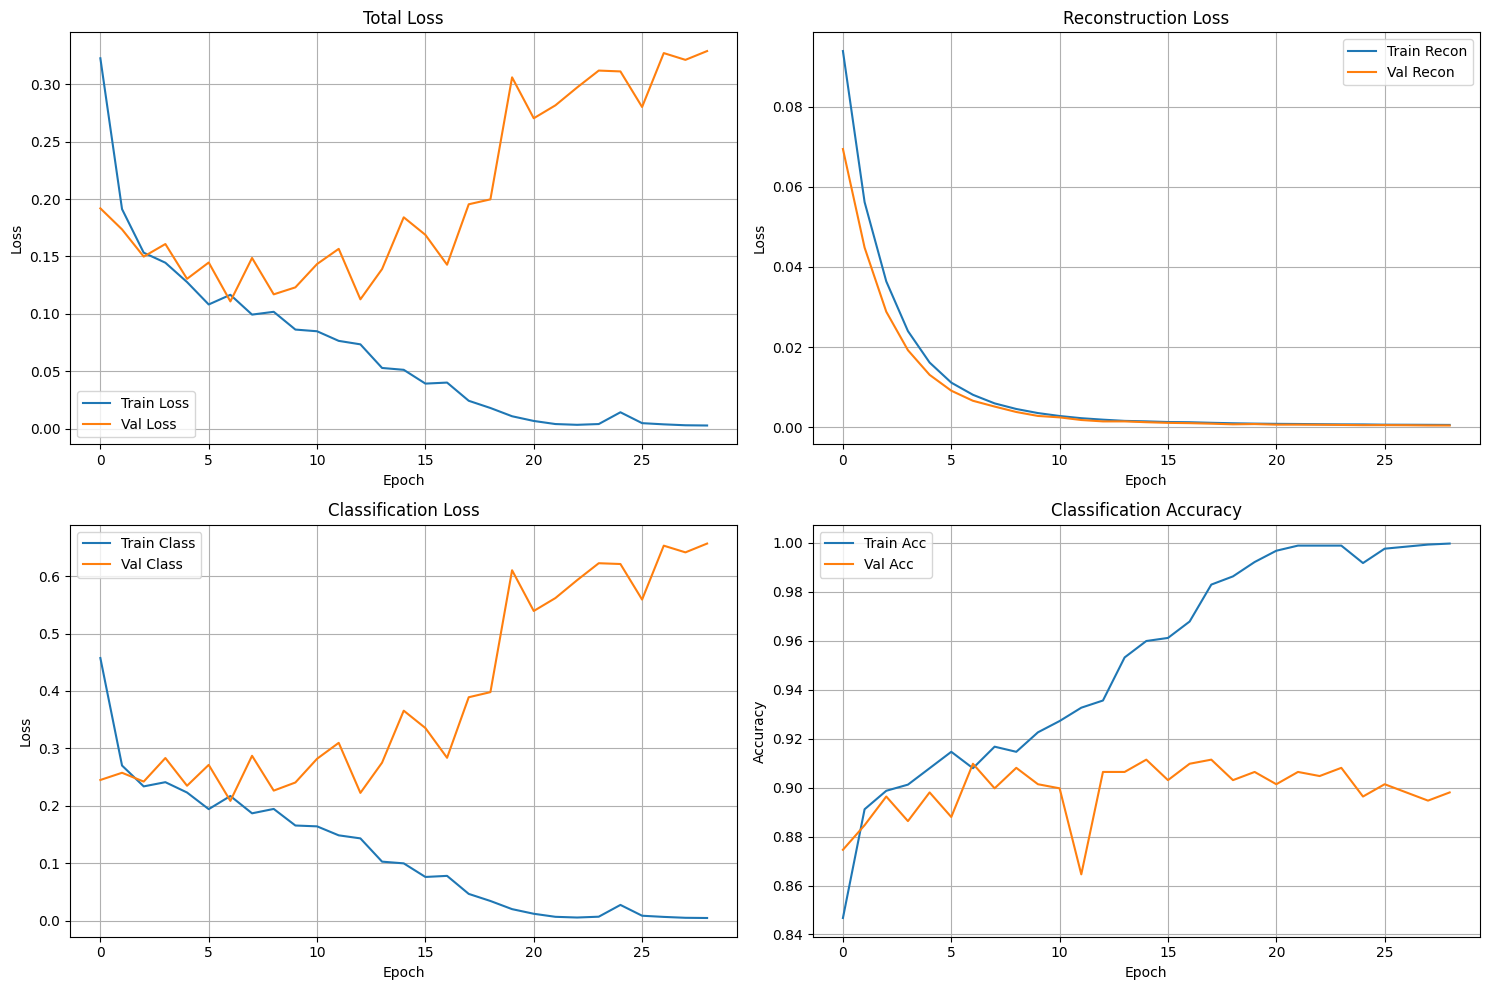


Training completed successfully. Starting evaluation...


Evaluating:   0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
# Cell 33: Smart Training Cell
def initialize_training():
    """Initialize or resume training based on checkpoint existence."""
    config = SSAEConfig()
    model = SemiSupervisedAE(
        latent_dim=config.latent_dim,
        num_classes=config.num_classes
    )

    # Check for existing checkpoint
    checkpoint_path = Path(config.checkpoint_dir) / f"{config.model_name}_checkpoint.pth"
    if checkpoint_path.exists():
        print("\nFound existing checkpoint. Resuming training...")
    else:
        print("\nNo checkpoint found. Starting new training...")

    return model, config

if __name__ == "__main__":
    training_completed = False

    try:
        # Initialize or resume
        model, config = initialize_training()

        # Start or resume training
        metrics = train_ssae(model, train_loader, val_loader, config)

        # Set flag for successful completion
        training_completed = True

    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Progress has been saved to checkpoint.")
        print("Run this cell again to resume training from the last checkpoint.")
    except Exception as e:
        print(f"\nError during execution: {str(e)}")
        import traceback
        traceback.print_exc()

    # Only run evaluation if training completed normally
    if training_completed:
        try:
            print("\nTraining completed successfully. Starting evaluation...")
            evaluation_results = evaluate_model(model, val_loader, config)
            print("\nEvaluation completed. Results saved in 'evaluation_results'")
        except Exception as e:
            print(f"\nError during evaluation: {str(e)}")
            traceback.print_exc()

In [30]:
# Cell 34: Semi-Supervised Model Reconstruction and Evaluation
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

def load_trained_ssae(checkpoint_dir, model_name='ssae'):
    """
    Load trained semi-supervised model and metadata without modifying previous cells.

    Args:
        checkpoint_dir (str): Directory containing checkpoints
        model_name (str): Name of the model checkpoint

    Returns:
        model: Loaded model
        metadata: Training metadata
    """
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"

    # Initialize model with same configuration as training
    model = SemiSupervisedAE(latent_dim=256, num_classes=3)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load metadata if available
    metadata = None
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

    return model, metadata

def compute_slice_metrics(original_slice, reconstructed_slice):
    """
    Compute quality metrics for a single slice.

    Args:
        original_slice: Original image slice
        reconstructed_slice: Reconstructed image slice

    Returns:
        dict: Dictionary containing MSE and SSIM metrics
    """
    mse = np.mean((original_slice - reconstructed_slice) ** 2)
    ssim_score = ssim(original_slice, reconstructed_slice, data_range=1.0)

    return {
        'MSE': mse,
        'SSIM': ssim_score
    }

In [31]:
# Cell 35: Reconstruction Visualization Functions
def extract_orthogonal_slices(volume):
    """
    Extract axial, sagittal, and coronal slices from the middle of the volume.

    Args:
        volume: 3D volume array

    Returns:
        tuple: (axial_slice, sagittal_slice, coronal_slice)
    """
    d, h, w = volume.shape
    axial = volume[d//2, :, :]      # Top-down view
    sagittal = volume[:, h//2, :]    # Side view
    coronal = volume[:, :, w//2]     # Front view

    return axial, sagittal, coronal

def visualize_reconstruction_comparison(original, reconstructed, metrics, title="Sample Reconstruction Comparison"):
    """
    Create side-by-side visualization of original and reconstructed slices.

    Args:
        original: Original volume
        reconstructed: Reconstructed volume
        metrics: Dictionary containing evaluation metrics
        title: Plot title
    """
    # Extract slices
    orig_axial, orig_sagittal, orig_coronal = extract_orthogonal_slices(original)
    recon_axial, recon_sagittal, recon_coronal = extract_orthogonal_slices(reconstructed)

    # Create figure
    fig = plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=16, y=1.05)

    # Plot original slices
    views = ['Axial', 'Sagittal', 'Coronal']
    orig_slices = [orig_axial, orig_sagittal, orig_coronal]
    recon_slices = [recon_axial, recon_sagittal, recon_coronal]

    for idx, (view, orig_slice, recon_slice) in enumerate(zip(views, orig_slices, recon_slices)):
        # Original
        plt.subplot(2, 3, idx + 1)
        plt.imshow(orig_slice, cmap='gray')
        plt.title(f'Original {view}')
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, 3, idx + 4)
        plt.imshow(recon_slice, cmap='gray')
        plt.title(f'Reconstructed {view}\nMSE: {metrics[view]["MSE"]:.4f}\nSSIM: {metrics[view]["SSIM"]:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [32]:
# Cell 36: Evaluation Pipeline
def evaluate_ssae_reconstruction(model, val_loader, samples_per_group=2):
    """
    Evaluate semi-supervised model reconstruction on validation set.

    Args:
        model: Trained semi-supervised model
        val_loader: Validation data loader
        samples_per_group: Number of samples to visualize per patient group
    """
    device = next(model.parameters()).device
    model.eval()

    # Initialize storage for group-wise metrics
    group_metrics = {
        'Control': {'mse': [], 'samples': 0},
        'PD': {'mse': [], 'samples': 0},
        'SWEDD': {'mse': [], 'samples': 0}
    }

    # Track visualized samples per group
    visualized_samples = {
        'Control': 0,
        'PD': 0,
        'SWEDD': 0
    }

    print("Evaluating reconstruction quality...")

    with torch.no_grad():
        for batch in tqdm(val_loader):
            # Check if we have enough samples from each group
            if all(count >= samples_per_group for count in visualized_samples.values()):
                break

            # Move data to GPU
            volumes = batch['volume'].to(device)
            labels = batch['label']  # Original string labels

            # Get reconstructions
            reconstructions, classifications, _ = model(volumes)

            # Process each sample in the batch
            for idx in range(volumes.shape[0]):
                current_group = labels[idx]

                # Skip if we already have enough samples from this group
                if visualized_samples[current_group] >= samples_per_group:
                    continue

                # Get original and reconstructed volumes
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_vol = reconstructions[idx, 0].cpu().numpy()

                # Calculate metrics for each view
                metrics = {}
                for view, (orig_slice, recon_slice) in zip(
                    ['Axial', 'Sagittal', 'Coronal'],
                    zip(*[extract_orthogonal_slices(vol) for vol in [orig_vol, recon_vol]])
                ):
                    metrics[view] = compute_slice_metrics(orig_slice, recon_slice)

                # Visualize comparison
                visualize_reconstruction_comparison(
                    orig_vol,
                    recon_vol,
                    metrics,
                    f"Patient Group: {current_group} - Sample {visualized_samples[current_group] + 1}"
                )

                # Update group metrics
                mse = np.mean((volumes[idx, 0].cpu().numpy() -
                             reconstructions[idx, 0].cpu().numpy()) ** 2)
                group_metrics[current_group]['mse'].append(mse)
                group_metrics[current_group]['samples'] += 1
                visualized_samples[current_group] += 1

            # Clean up GPU memory
            del volumes, reconstructions
            torch.cuda.empty_cache()

    # Print group-wise metrics
    print("\nReconstruction Metrics by Patient Group:")
    for group in group_metrics:
        if group_metrics[group]['samples'] > 0:
            avg_mse = np.mean(group_metrics[group]['mse'])
            print(f"\n{group}:")
            print(f"Number of samples: {group_metrics[group]['samples']}")
            print(f"Average MSE: {avg_mse:.6f}")
            print(f"RMSE: {np.sqrt(avg_mse):.6f}")

    return group_metrics

Loading trained semi-supervised model...

Starting reconstruction evaluation...
Evaluating reconstruction quality...


  0%|          | 0/299 [00:00<?, ?it/s]

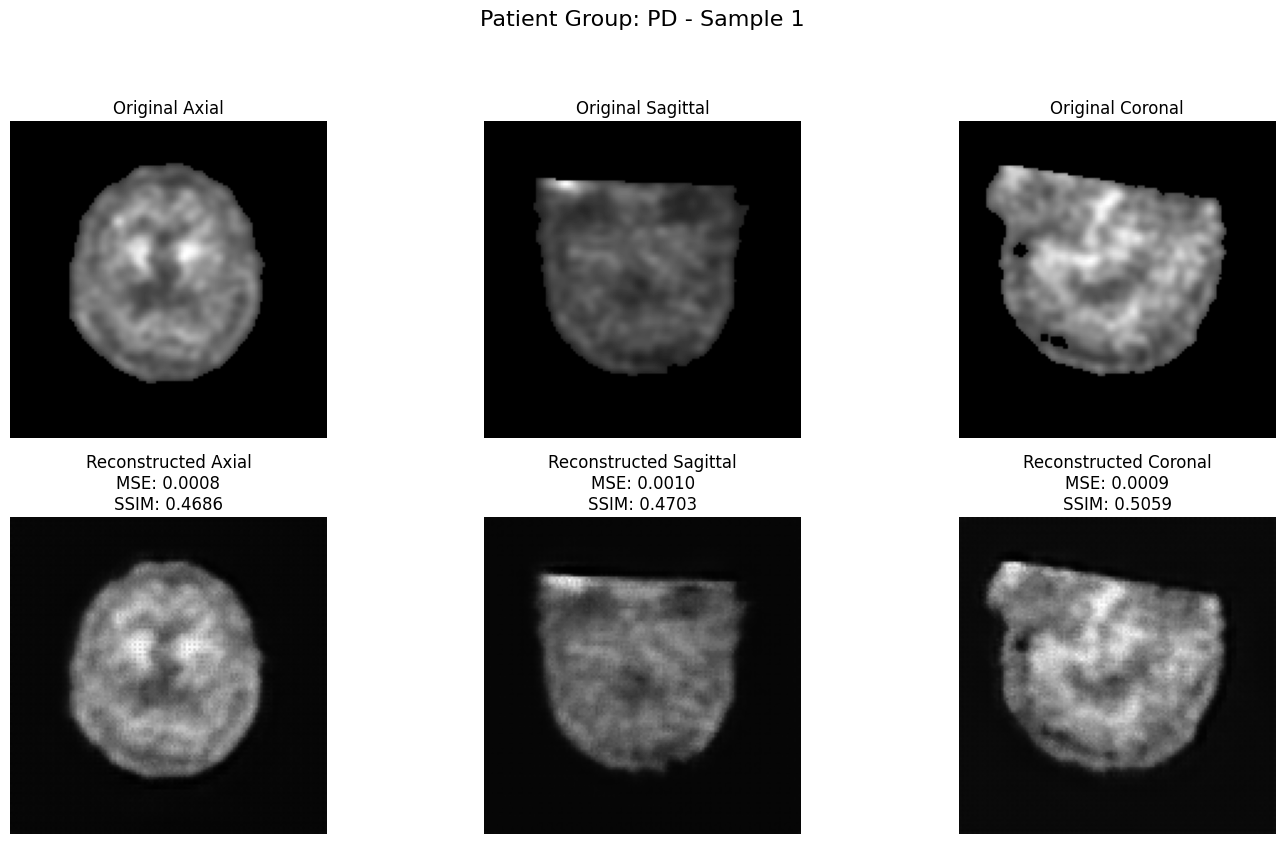

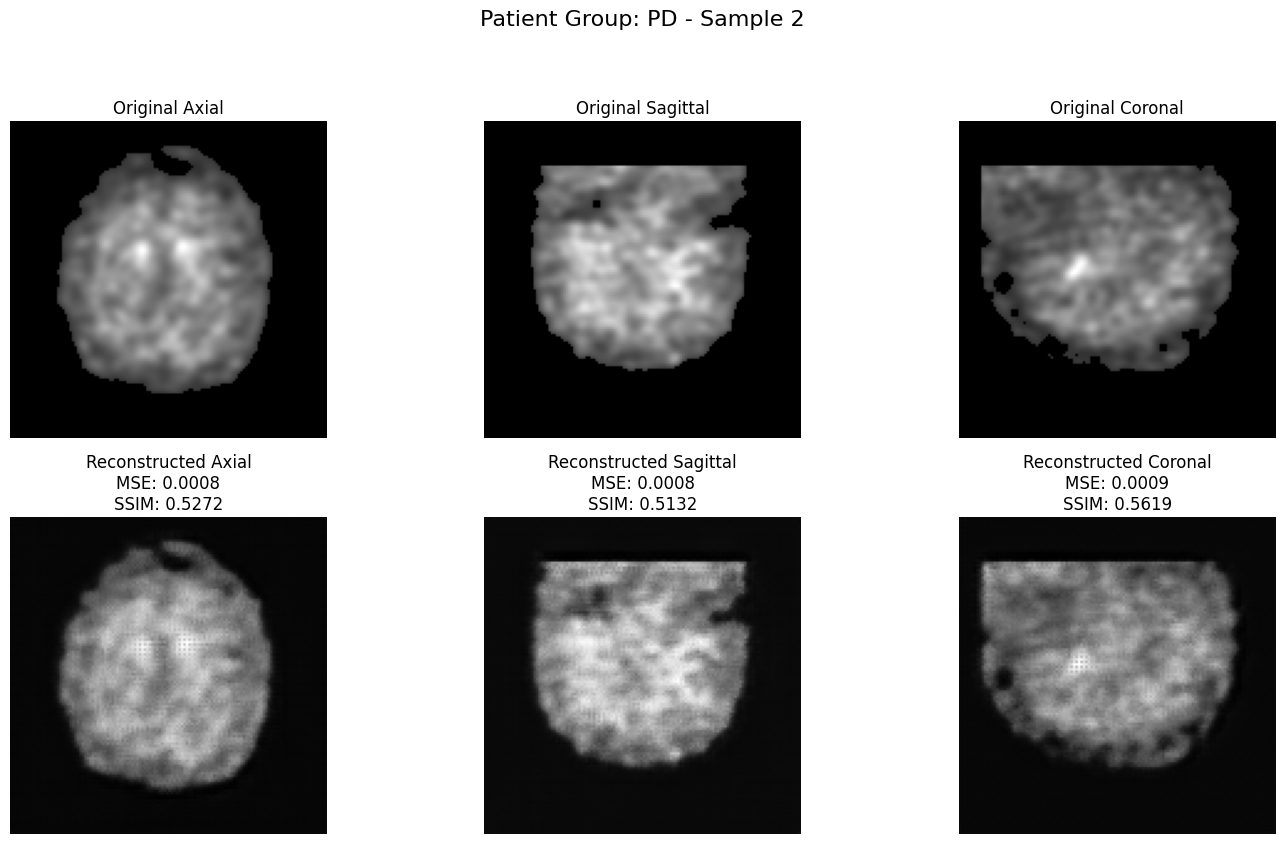

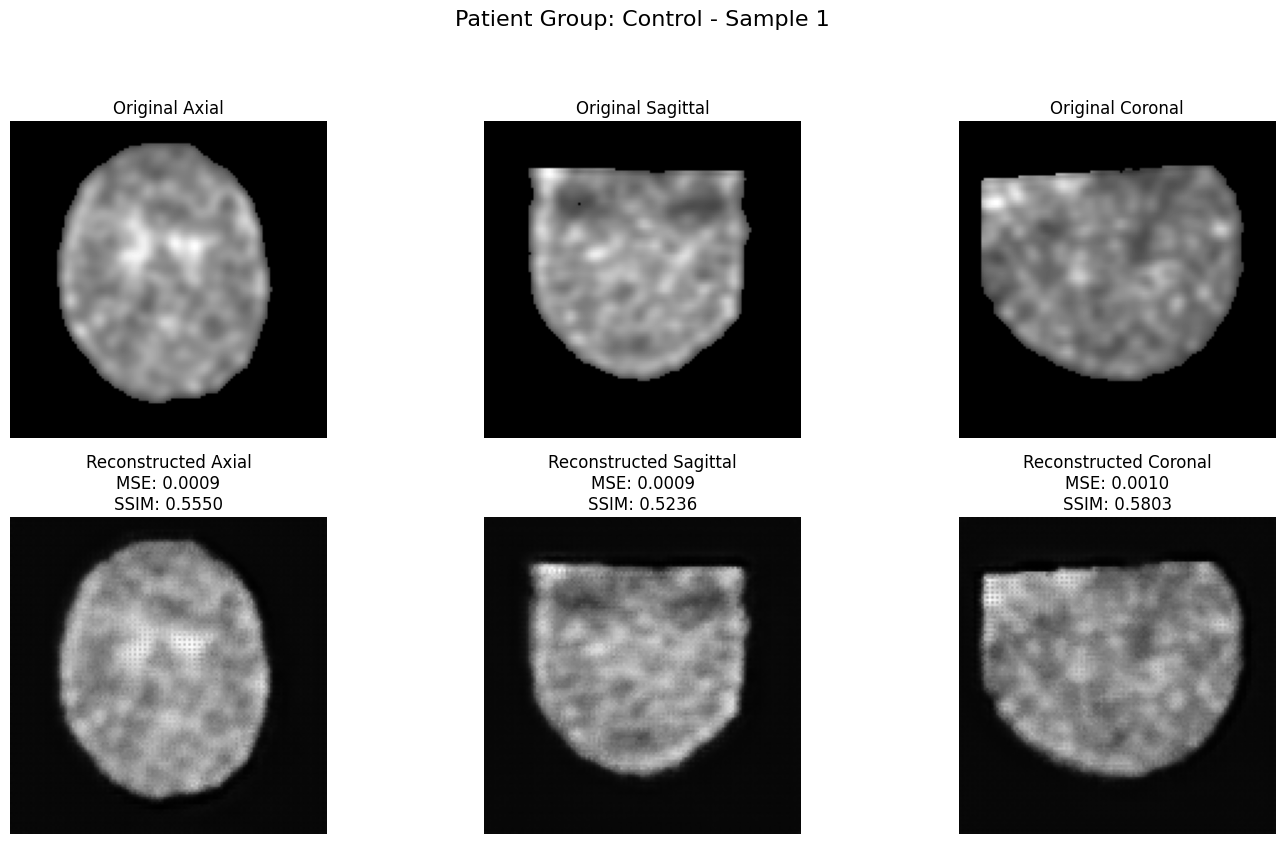

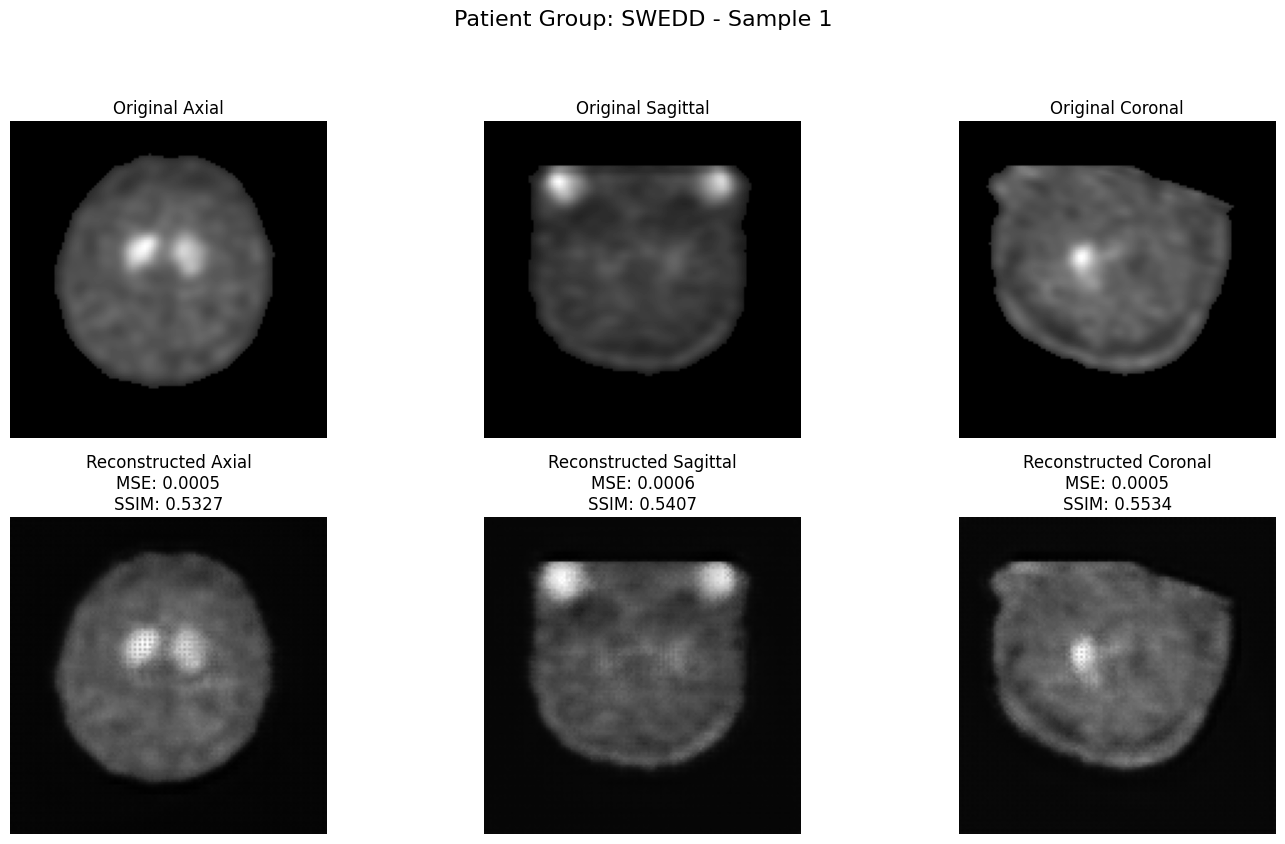

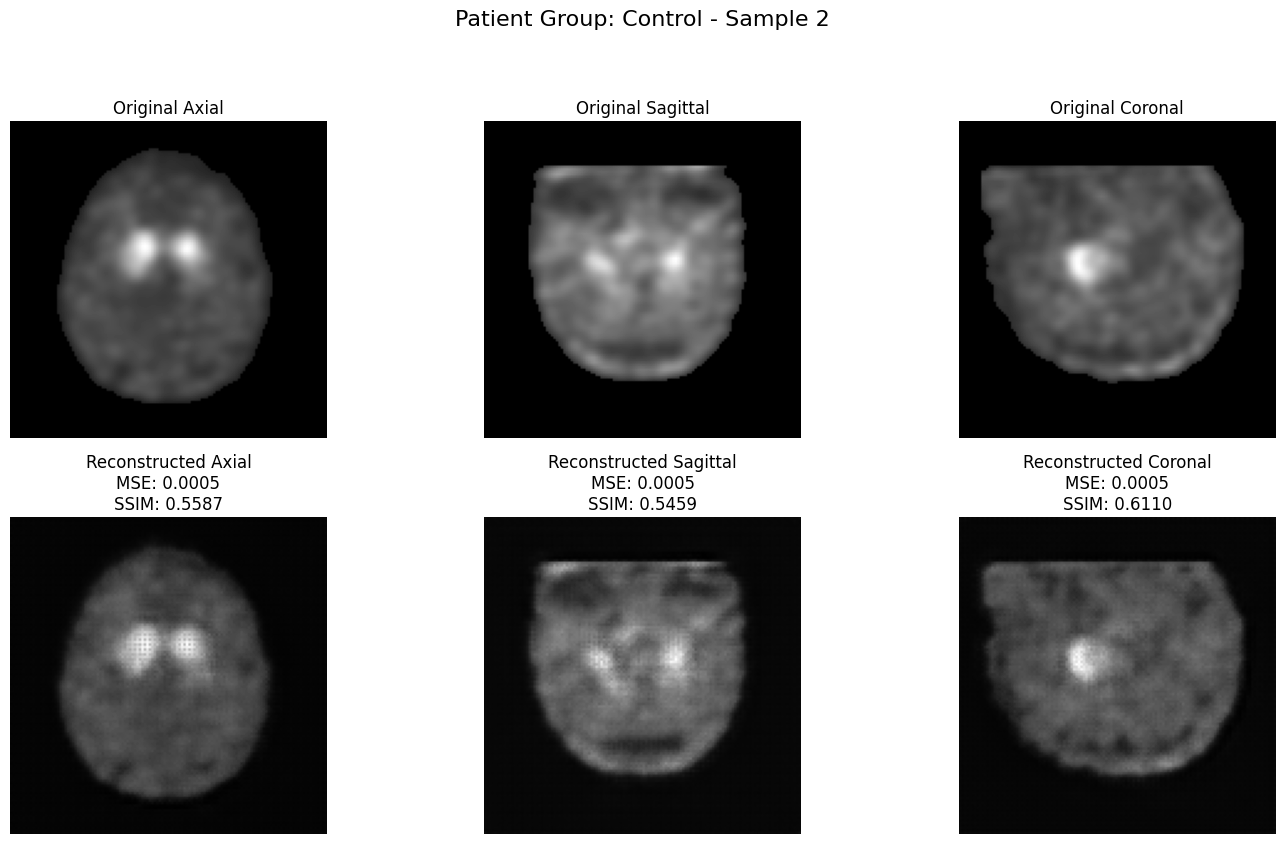

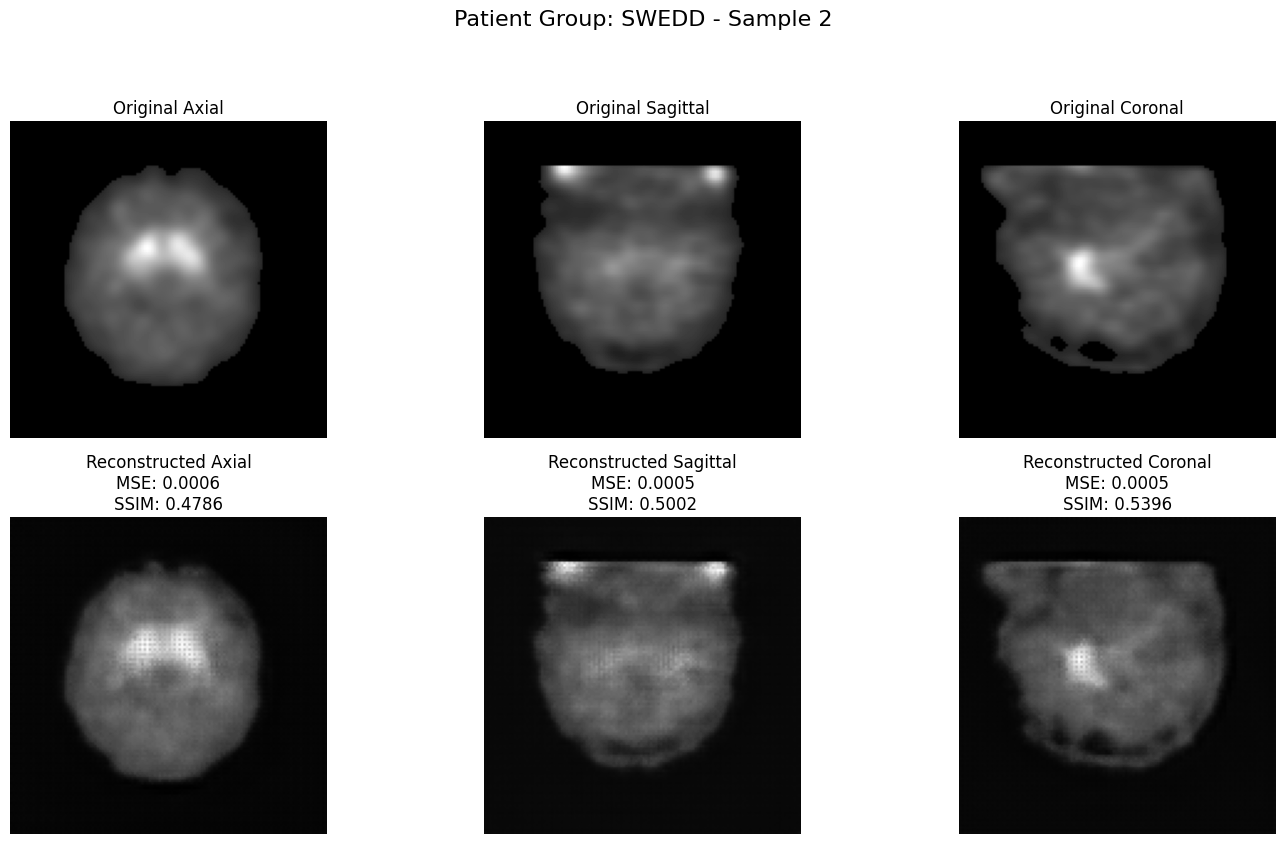


Reconstruction Metrics by Patient Group:

Control:
Number of samples: 2
Average MSE: 0.000697
RMSE: 0.026397

PD:
Number of samples: 2
Average MSE: 0.000731
RMSE: 0.027036

SWEDD:
Number of samples: 2
Average MSE: 0.000555
RMSE: 0.023557


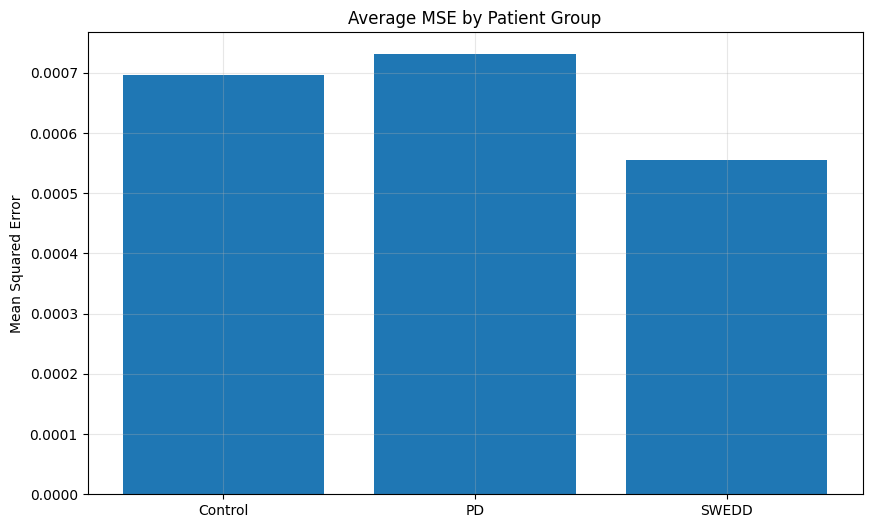


Evaluation completed successfully!


In [ ]:
# Cell 37: Run Evaluation
if __name__ == "__main__":
    try:
        # Load trained model
        print("Loading trained semi-supervised model...")
        model, metadata = load_trained_ssae('checkpoints')
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Run evaluation with samples per group
        print("\nStarting reconstruction evaluation...")
        group_metrics = evaluate_ssae_reconstruction(model, val_loader, samples_per_group=2)

        # Visualize group-wise metrics
        groups = list(group_metrics.keys())
        mse_values = [np.mean(group_metrics[g]['mse']) for g in groups]

        plt.figure(figsize=(10, 6))
        plt.bar(groups, mse_values)
        plt.title('Average MSE by Patient Group')
        plt.ylabel('Mean Squared Error')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Clean up
        torch.cuda.empty_cache()
        print("\nEvaluation completed successfully!")

    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        import traceback
        traceback.print_exc()

## 4. VAE Semi-Supervised

### Model Setup

In [25]:
# Cell 38: Semi-Supervised VAE Model Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class SSVAE(nn.Module):
    """
    Semi-Supervised Variational Autoencoder combining reconstruction,
    latent sampling, and classification objectives.
    Optimized for 128³ medical volumes on NVIDIA 4070Ti.
    """
    def __init__(self, latent_dim=256, num_classes=3):
        super().__init__()
        self.encoder = SSVAEEncoder(latent_dim)
        self.decoder = SSVAEDecoder(latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        torch.backends.cudnn.benchmark = True

    def reparameterize(self, mu, log_var):
        """Reparameterization trick for VAE sampling."""
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x):
        # Encode input
        mu, log_var, skip_connections = self.encoder(x)

        # Sample from latent distribution
        z = self.reparameterize(mu, log_var)

        # Generate reconstruction and classification
        reconstruction = self.decoder(z, skip_connections)
        classification = self.classifier(z)

        return reconstruction, classification, mu, log_var

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))
        ]))

    def forward(self, x):
        return self.block(x)

class SSVAEEncoder(nn.Module):
    """Encoder network with probabilistic latent space."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128

        # Downsampling path
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )

        # Project to latent parameters
        self.flatten_size = 256 * 8 * 8 * 8
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent parameters
        flat = torch.flatten(d4, start_dim=1)
        mu = self.fc_mu(flat)
        log_var = self.fc_var(flat)

        return mu, log_var, (d1, d2, d3, d4)

class SSVAEDecoder(nn.Module):
    """Decoder network with skip connections."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 8 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),   # 16 -> 32
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),    # 32 -> 64
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 64 -> 128
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z, skip_connections):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8, 8)

        # Unpack skip connections
        d1, d2, d3, d4 = skip_connections

        # Upsampling with skip connections
        x = self.up1(x + d4)
        x = self.up2(x + d3)
        x = self.up3(x + d2)
        x = self.up4(x + d1)

        # Final convolution with sigmoid activation
        x = torch.sigmoid(self.final_conv(x))

        return x


In [26]:
# Cell 39: Training Configuration and Loss Functions
import os
import json
import time
from pathlib import Path

class SSVAEConfig:
    """Configuration for SSVAE training."""
    def __init__(self):
        # Model parameters
        self.latent_dim = 256
        self.num_classes = 3
        self.learning_rate = 1e-4

        # Loss weights
        self.recon_weight = 1.0
        self.kl_weight = 0.1
        self.class_weight = 0.5

        # Training parameters
        self.batch_size = 8
        self.epochs = 100
        self.accumulation_steps = 4

        # Early stopping
        self.patience = 10
        self.min_delta = 1e-6

        # Optimization
        self.use_amp = True
        self.num_workers = 4
        self.pin_memory = True

        # Checkpoint configuration
        self.checkpoint_dir = 'checkpoints'
        self.model_name = 'ssvae'
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class SSVAELoss:
    """Combined loss for semi-supervised VAE training."""
    def __init__(self, recon_weight=1.0, kl_weight=0.1, class_weight=0.5):
        self.recon_weight = recon_weight
        self.kl_weight = kl_weight
        self.class_weight = class_weight
        self.recon_criterion = nn.MSELoss()
        self.class_criterion = nn.CrossEntropyLoss()

    def __call__(self, recon, target, class_pred, class_target, mu, log_var):
        # Reconstruction loss
        recon_loss = self.recon_criterion(recon, target)

        # KL divergence
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        # Classification loss
        class_loss = self.class_criterion(class_pred, class_target)

        # Total loss
        total_loss = (self.recon_weight * recon_loss +
                     self.kl_weight * kl_loss +
                     self.class_weight * class_loss)

        return total_loss, recon_loss, kl_loss, class_loss

class SSVAECheckpointHandler:
    """Handles saving and loading of model checkpoints."""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"

    def save(self, model, optimizer, scheduler, epoch, metrics):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'metrics': metrics
        }
        torch.save(checkpoint, self.checkpoint_path)

        metadata = {
            'last_epoch': epoch,
            'metrics': metrics,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer=None, scheduler=None):
        if not self.checkpoint_path.exists():
            return None

        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        return checkpoint['epoch'], checkpoint['metrics']



In [27]:
# Cell 40: Training Loop
import torch
import torch.cuda.amp as amp
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def train_ssvae(model, train_loader, val_loader, config=None):
    """Training loop optimized for NVIDIA RTX 4070 Ti."""
    if config is None:
        config = SSVAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = SSVAELoss(
        config.recon_weight,
        config.kl_weight,
        config.class_weight
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    scaler = amp.GradScaler(enabled=config.use_amp)
    checkpoint_handler = SSVAECheckpointHandler(config.checkpoint_dir, config.model_name)

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    metrics = {
        'train_losses': [], 'val_losses': [],
        'train_recon': [], 'val_recon': [],
        'train_kl': [], 'val_kl': [],
        'train_class': [], 'val_class': [],
        'train_acc': [], 'val_acc': []
    }

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch, metrics = checkpoint_data
        print(f"Resuming training from epoch {start_epoch + 1}")

    try:
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            train_loss = train_recon = train_kl = train_class = 0
            correct_preds = total_preds = 0

            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')

            for i, batch in enumerate(train_pbar):
                volumes = batch['volume'].to(device, non_blocking=True)
                labels = process_labels(batch['label']).to(device)

                # Mixed precision forward pass
                with amp.autocast(enabled=config.use_amp):
                    recon, class_pred, mu, log_var = model(volumes)
                    loss, recon_l, kl_l, class_l = criterion(
                        recon, volumes, class_pred, labels, mu, log_var
                    )
                    loss = loss / config.accumulation_steps

                # Backward pass
                scaler.scale(loss).backward()

                # Gradient accumulation
                if (i + 1) % config.accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                # Track metrics
                train_loss += loss.item() * config.accumulation_steps
                train_recon += recon_l.item()
                train_kl += kl_l.item()
                train_class += class_l.item()

                pred = class_pred.argmax(dim=1)
                correct_preds += (pred == labels).sum().item()
                total_preds += labels.size(0)

                train_pbar.set_postfix({
                    'loss': loss.item() * config.accumulation_steps,
                    'acc': correct_preds/total_preds
                })

            # Validation phase
            model.eval()
            val_loss = val_recon = val_kl = val_class = 0
            val_correct = val_total = 0
            all_preds = []
            all_labels = []

            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Val]')

            with torch.no_grad():
                for batch in val_pbar:
                    volumes = batch['volume'].to(device)
                    labels = process_labels(batch['label']).to(device)

                    recon, class_pred, mu, log_var = model(volumes)
                    loss, recon_l, kl_l, class_l = criterion(
                        recon, volumes, class_pred, labels, mu, log_var
                    )

                    val_loss += loss.item()
                    val_recon += recon_l.item()
                    val_kl += kl_l.item()
                    val_class += class_l.item()

                    pred = class_pred.argmax(dim=1)
                    val_correct += (pred == labels).sum().item()
                    val_total += labels.size(0)

                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    val_pbar.set_postfix({
                        'loss': loss.item(),
                        'acc': val_correct/val_total
                    })

            # Calculate average metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_train_recon = train_recon / len(train_loader)
            avg_train_kl = train_kl / len(train_loader)
            avg_train_class = train_class / len(train_loader)
            train_acc = correct_preds / total_preds

            avg_val_loss = val_loss / len(val_loader)
            avg_val_recon = val_recon / len(val_loader)
            avg_val_kl = val_kl / len(val_loader)
            avg_val_class = val_class / len(val_loader)
            val_acc = val_correct / val_total

            # Update tracking metrics
            metrics['train_losses'].append(avg_train_loss)
            metrics['val_losses'].append(avg_val_loss)
            metrics['train_recon'].append(avg_train_recon)
            metrics['val_recon'].append(avg_val_recon)
            metrics['train_kl'].append(avg_train_kl)
            metrics['val_kl'].append(avg_val_kl)
            metrics['train_class'].append(avg_train_class)
            metrics['val_class'].append(avg_val_class)
            metrics['train_acc'].append(train_acc)
            metrics['val_acc'].append(val_acc)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save checkpoint
            checkpoint_handler.save(model, optimizer, scheduler, epoch, metrics)

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{config.epochs}")
            print("Training Metrics:")
            print(f"Loss: {avg_train_loss:.6f}")
            print(f"Recon Loss: {avg_train_recon:.6f}")
            print(f"KL Loss: {avg_train_kl:.6f}")
            print(f"Class Loss: {avg_train_class:.6f}")
            print(f"Accuracy: {train_acc:.2%}")

            print("\nValidation Metrics:")
            print(f"Loss: {avg_val_loss:.6f}")
            print(f"Recon Loss: {avg_val_recon:.6f}")
            print(f"KL Loss: {avg_val_kl:.6f}")
            print(f"Class Loss: {avg_val_class:.6f}")
            print(f"Accuracy: {val_acc:.2%}")

            # Print classification report for validation set
            label_names = ['Control', 'PD', 'SWEDD']
            print("\nClassification Report:")
            print(classification_report(all_labels, all_preds, target_names=label_names))

            # Early stopping check
            if avg_val_loss < best_val_loss - config.min_delta:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(),
                         os.path.join(config.checkpoint_dir, f'{config.model_name}_best.pth'))
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break

            # Print memory stats
            print(f"\nGPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plot_training_history(metrics)

    return metrics

def plot_training_history(metrics):
    """Plot training and validation metrics history."""
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot reconstruction loss
    plt.subplot(2, 2, 2)
    plt.plot(metrics['train_recon'], label='Train Recon')
    plt.plot(metrics['val_recon'], label='Val Recon')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot KL divergence
    plt.subplot(2, 2, 3)
    plt.plot(metrics['train_kl'], label='Train KL')
    plt.plot(metrics['val_kl'], label='Val KL')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot classification accuracy
    plt.subplot(2, 2, 4)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def process_labels(labels):
    """Convert string labels to tensor indices."""
    label_map = {'Control': 0, 'PD': 1, 'SWEDD': 2}
    return torch.tensor([label_map[label] for label in labels])


In [28]:
# Cell 41: Model Evaluation
def evaluate_ssvae(model, val_loader, config=None):
    """Comprehensive model evaluation including reconstruction and classification metrics."""
    if config is None:
        config = SSVAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Initialize metrics
    val_recon_loss = 0
    val_kl_loss = 0
    val_class_loss = 0
    all_preds = []
    all_labels = []
    reconstructions = []
    originals = []
    latent_vectors = []

    criterion = SSVAELoss(
        config.recon_weight,
        config.kl_weight,
        config.class_weight
    )

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            volumes = batch['volume'].to(device)
            labels = process_labels(batch['label']).to(device)

            recon, class_pred, mu, log_var = model(volumes)
            loss, recon_l, kl_l, class_l = criterion(
                recon, volumes, class_pred, labels, mu, log_var
            )

            val_recon_loss += recon_l.item()
            val_kl_loss += kl_l.item()
            val_class_loss += class_l.item()

            pred = class_pred.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store latent vectors for visualization
            latent_vectors.append(mu.cpu().numpy())

            # Store some examples for visualization
            if len(reconstructions) < 5:
                reconstructions.append(recon.cpu().numpy())
                originals.append(volumes.cpu().numpy())

    # Calculate average losses
    avg_recon_loss = val_recon_loss / len(val_loader)
    avg_kl_loss = val_kl_loss / len(val_loader)
    avg_class_loss = val_class_loss / len(val_loader)

    # Print classification report
    label_names = ['Control', 'PD', 'SWEDD']
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Visualize reconstructions
    visualize_reconstructions(originals, reconstructions, label_names,
                            [label_names[l] for l in all_labels[:5]])

    # Visualize latent space
    latent_vectors = np.concatenate(latent_vectors)
    visualize_latent_space(latent_vectors, all_labels, label_names)

    return {
        'recon_loss': avg_recon_loss,
        'kl_loss': avg_kl_loss,
        'class_loss': avg_class_loss,
        'predictions': all_preds,
        'true_labels': all_labels,
        'latent_vectors': latent_vectors
    }

def visualize_reconstructions(originals, reconstructions, label_names, true_labels):
    """Visualize original vs reconstructed volumes."""
    num_samples = len(originals)
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        orig = originals[i][0]
        recon = reconstructions[i][0]

        # Get middle slices
        orig_axial = orig[orig.shape[0]//2, :, :]
        orig_sagittal = orig[:, orig.shape[1]//2, :]
        orig_coronal = orig[:, :, orig.shape[2]//2]

        recon_axial = recon[recon.shape[0]//2, :, :]
        recon_sagittal = recon[:, recon.shape[1]//2, :]
        recon_coronal = recon[:, :, recon.shape[2]//2]

        # Plot original
        plt.subplot(num_samples, 6, i*6 + 1)
        plt.imshow(orig_axial, cmap='gray')
        plt.title(f'Original Axial\n{true_labels[i]}' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 2)
        plt.imshow(orig_sagittal, cmap='gray')
        plt.title('Original Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 3)
        plt.imshow(orig_coronal, cmap='gray')
        plt.title('Original Coronal' if i == 0 else '')
        plt.axis('off')

        # Plot reconstruction
        plt.subplot(num_samples, 6, i*6 + 4)
        plt.imshow(recon_axial, cmap='gray')
        plt.title('Reconstructed Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 5)
        plt.imshow(recon_sagittal, cmap='gray')
        plt.title('Reconstructed Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 6, i*6 + 6)
        plt.imshow(recon_coronal, cmap='gray')
        plt.title('Reconstructed Coronal' if i == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_latent_space(latent_vectors, labels, label_names):
    """Visualize latent space using dimensionality reduction."""
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vecs = tsne.fit_transform(latent_vectors)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(np.unique(labels)):
        mask = labels == label
        plt.scatter(reduced_vecs[mask, 0], reduced_vecs[mask, 1],
                   label=label_names[i], alpha=0.6)

    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Also visualize using PCA for comparison
    pca = PCA(n_components=2)
    pca_vecs = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    for i, label in enumerate(np.unique(labels)):
        mask = labels == label
        plt.scatter(pca_vecs[mask, 0], pca_vecs[mask, 1],
                   label=label_names[i], alpha=0.6)

    plt.title('PCA Visualization of Latent Space')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.legend()
    plt.grid(True)
    plt.show()


### Training

Initializing training process...

Found existing checkpoint. Resuming training...

Starting training process...
Resuming training from epoch 20


Epoch 20/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 20/100
Training Metrics:
Loss: 0.014976
Recon Loss: 0.000773
KL Loss: 0.082441
Class Loss: 0.011918
Accuracy: 99.83%

Validation Metrics:
Loss: 0.143488
Recon Loss: 0.000603
KL Loss: 0.065524
Class Loss: 0.272666
Accuracy: 91.97%

Classification Report:
              precision    recall  f1-score   support

     Control       0.61      0.80      0.69        59
          PD       0.99      0.96      0.97       512
       SWEDD       0.52      0.44      0.48        27

    accuracy                           0.92       598
   macro avg       0.71      0.73      0.71       598
weighted avg       0.93      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 21/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 21/100
Training Metrics:
Loss: 0.012118
Recon Loss: 0.000716
KL Loss: 0.072684
Class Loss: 0.008268
Accuracy: 99.83%

Validation Metrics:
Loss: 0.130831
Recon Loss: 0.000571
KL Loss: 0.051747
Class Loss: 0.250172
Accuracy: 92.31%

Classification Report:
              precision    recall  f1-score   support

     Control       0.61      0.73      0.67        59
          PD       0.99      0.97      0.98       512
       SWEDD       0.54      0.52      0.53        27

    accuracy                           0.92       598
   macro avg       0.71      0.74      0.72       598
weighted avg       0.93      0.92      0.93       598


GPU Memory: 1.75 GB


Epoch 22/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 22/100
Training Metrics:
Loss: 0.011211
Recon Loss: 0.000637
KL Loss: 0.066865
Class Loss: 0.007775
Accuracy: 99.92%

Validation Metrics:
Loss: 0.135442
Recon Loss: 0.000586
KL Loss: 0.049037
Class Loss: 0.259903
Accuracy: 92.31%

Classification Report:
              precision    recall  f1-score   support

     Control       0.60      0.80      0.69        59
          PD       0.98      0.96      0.97       512
       SWEDD       0.73      0.41      0.52        27

    accuracy                           0.92       598
   macro avg       0.77      0.72      0.73       598
weighted avg       0.93      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 23/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 23/100
Training Metrics:
Loss: 0.010455
Recon Loss: 0.000592
KL Loss: 0.063416
Class Loss: 0.007041
Accuracy: 99.92%

Validation Metrics:
Loss: 0.136663
Recon Loss: 0.000509
KL Loss: 0.049477
Class Loss: 0.262413
Accuracy: 91.81%

Classification Report:
              precision    recall  f1-score   support

     Control       0.59      0.73      0.65        59
          PD       0.98      0.96      0.97       512
       SWEDD       0.55      0.44      0.49        27

    accuracy                           0.92       598
   macro avg       0.71      0.71      0.70       598
weighted avg       0.92      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 24/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 24/100
Training Metrics:
Loss: 0.010092
Recon Loss: 0.000564
KL Loss: 0.060943
Class Loss: 0.006868
Accuracy: 99.87%

Validation Metrics:
Loss: 0.137178
Recon Loss: 0.000524
KL Loss: 0.052629
Class Loss: 0.262783
Accuracy: 91.64%

Classification Report:
              precision    recall  f1-score   support

     Control       0.59      0.69      0.64        59
          PD       0.98      0.97      0.97       512
       SWEDD       0.57      0.44      0.50        27

    accuracy                           0.92       598
   macro avg       0.71      0.70      0.70       598
weighted avg       0.92      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 25/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 25/100
Training Metrics:
Loss: 0.010067
Recon Loss: 0.000532
KL Loss: 0.064088
Class Loss: 0.006252
Accuracy: 99.92%

Validation Metrics:
Loss: 0.144828
Recon Loss: 0.000809
KL Loss: 0.047815
Class Loss: 0.278474
Accuracy: 92.81%

Classification Report:
              precision    recall  f1-score   support

     Control       0.60      0.85      0.70        59
          PD       0.99      0.96      0.98       512
       SWEDD       0.79      0.41      0.54        27

    accuracy                           0.93       598
   macro avg       0.79      0.74      0.74       598
weighted avg       0.94      0.93      0.93       598


GPU Memory: 1.75 GB


Epoch 26/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 26/100
Training Metrics:
Loss: 0.009161
Recon Loss: 0.000502
KL Loss: 0.057871
Class Loss: 0.005744
Accuracy: 99.96%

Validation Metrics:
Loss: 0.150847
Recon Loss: 0.000482
KL Loss: 0.054958
Class Loss: 0.289738
Accuracy: 92.31%

Classification Report:
              precision    recall  f1-score   support

     Control       0.61      0.81      0.70        59
          PD       0.98      0.96      0.97       512
       SWEDD       0.61      0.41      0.49        27

    accuracy                           0.92       598
   macro avg       0.73      0.73      0.72       598
weighted avg       0.93      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 27/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 27/100
Training Metrics:
Loss: 0.009352
Recon Loss: 0.000482
KL Loss: 0.056890
Class Loss: 0.006362
Accuracy: 99.92%

Validation Metrics:
Loss: 0.139691
Recon Loss: 0.000505
KL Loss: 0.040436
Class Loss: 0.270286
Accuracy: 92.47%

Classification Report:
              precision    recall  f1-score   support

     Control       0.60      0.80      0.69        59
          PD       0.98      0.97      0.97       512
       SWEDD       0.83      0.37      0.51        27

    accuracy                           0.92       598
   macro avg       0.80      0.71      0.72       598
weighted avg       0.93      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 28/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 28/100
Training Metrics:
Loss: 0.009788
Recon Loss: 0.000456
KL Loss: 0.055650
Class Loss: 0.007535
Accuracy: 99.83%

Validation Metrics:
Loss: 0.143180
Recon Loss: 0.000538
KL Loss: 0.043278
Class Loss: 0.276628
Accuracy: 92.47%

Classification Report:
              precision    recall  f1-score   support

     Control       0.61      0.81      0.70        59
          PD       0.98      0.96      0.97       512
       SWEDD       0.73      0.41      0.52        27

    accuracy                           0.92       598
   macro avg       0.77      0.73      0.73       598
weighted avg       0.93      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 29/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 29/100
Training Metrics:
Loss: 0.009090
Recon Loss: 0.000431
KL Loss: 0.054700
Class Loss: 0.006377
Accuracy: 99.83%

Validation Metrics:
Loss: 0.152209
Recon Loss: 0.000421
KL Loss: 0.049074
Class Loss: 0.293762
Accuracy: 91.97%

Classification Report:
              precision    recall  f1-score   support

     Control       0.60      0.73      0.66        59
          PD       0.97      0.97      0.97       512
       SWEDD       0.67      0.37      0.48        27

    accuracy                           0.92       598
   macro avg       0.75      0.69      0.70       598
weighted avg       0.92      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 30/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 30/100
Training Metrics:
Loss: 0.008393
Recon Loss: 0.000421
KL Loss: 0.051927
Class Loss: 0.005559
Accuracy: 99.92%

Validation Metrics:
Loss: 0.152950
Recon Loss: 0.000470
KL Loss: 0.048088
Class Loss: 0.295342
Accuracy: 92.31%

Classification Report:
              precision    recall  f1-score   support

     Control       0.60      0.80      0.69        59
          PD       0.99      0.96      0.97       512
       SWEDD       0.60      0.44      0.51        27

    accuracy                           0.92       598
   macro avg       0.73      0.73      0.72       598
weighted avg       0.93      0.92      0.92       598


GPU Memory: 1.75 GB


Epoch 31/100 [Train]:   0%|          | 0/1194 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/299 [00:00<?, ?it/s]


Epoch 31/100
Training Metrics:
Loss: 0.008466
Recon Loss: 0.000406
KL Loss: 0.053037
Class Loss: 0.005514
Accuracy: 99.87%

Validation Metrics:
Loss: 0.153893
Recon Loss: 0.000414
KL Loss: 0.049392
Class Loss: 0.297079
Accuracy: 92.31%

Classification Report:
              precision    recall  f1-score   support

     Control       0.62      0.76      0.68        59
          PD       0.98      0.97      0.97       512
       SWEDD       0.58      0.41      0.48        27

    accuracy                           0.92       598
   macro avg       0.73      0.71      0.71       598
weighted avg       0.93      0.92      0.92       598


Early stopping triggered at epoch 31


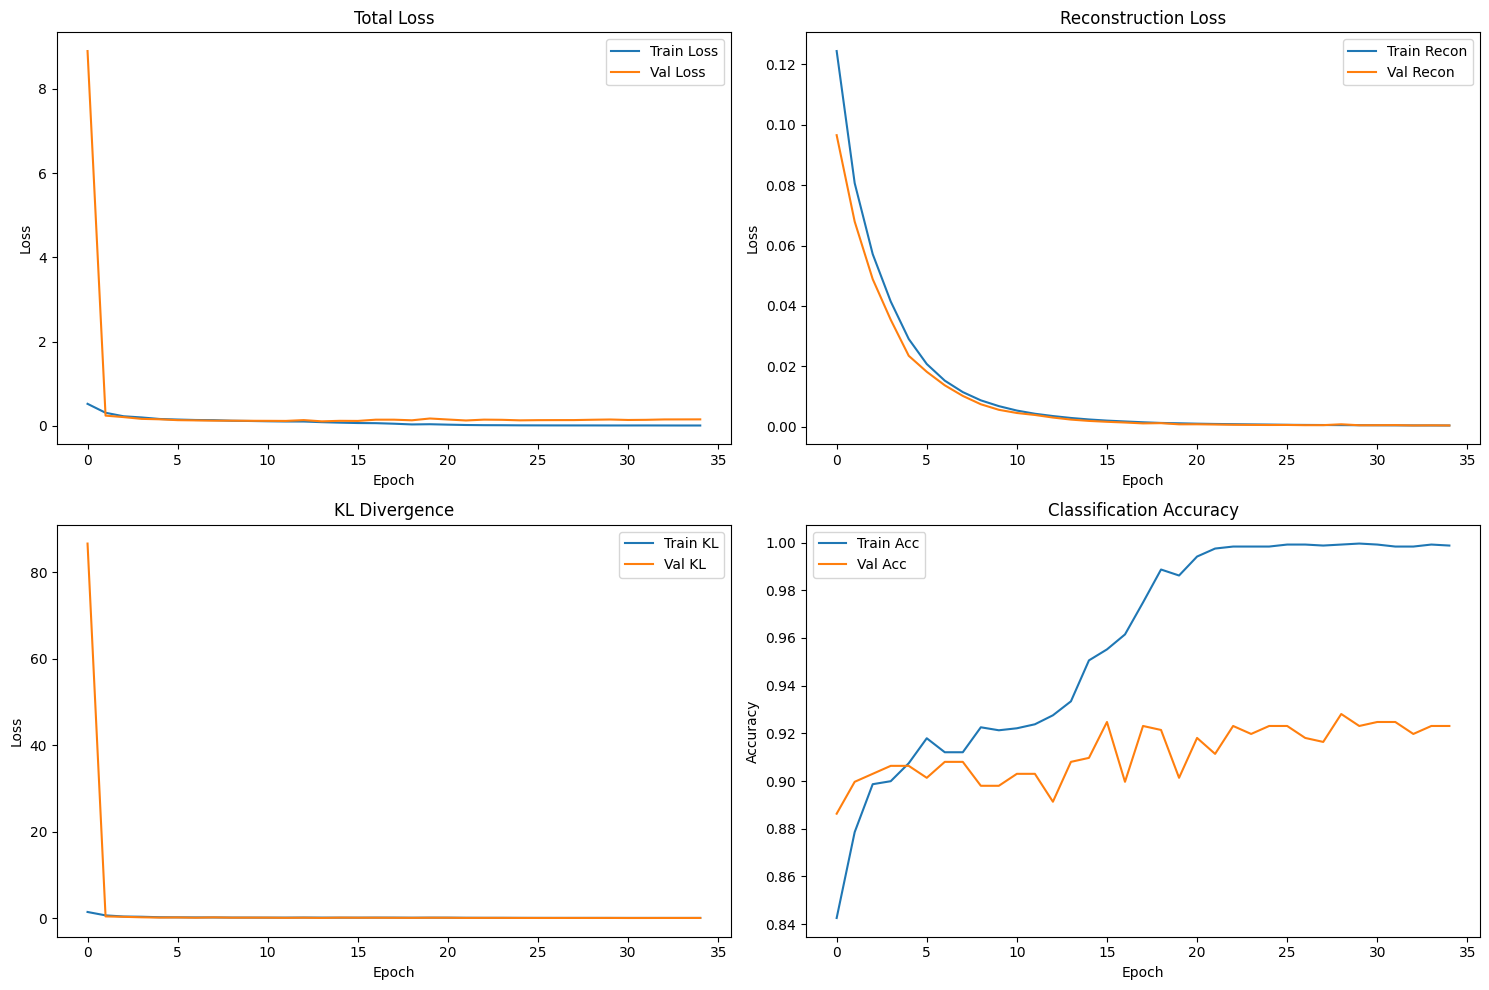


Training completed. Starting evaluation...


Evaluating:   0%|          | 0/299 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

     Control       0.62      0.76      0.68        59
          PD       0.98      0.97      0.97       512
       SWEDD       0.58      0.41      0.48        27

    accuracy                           0.92       598
   macro avg       0.73      0.71      0.71       598
weighted avg       0.93      0.92      0.92       598



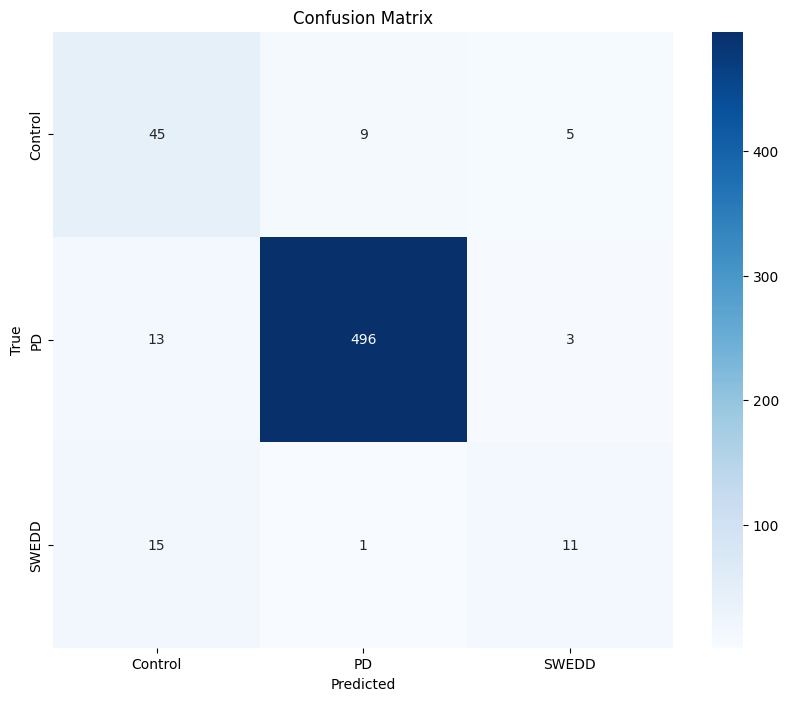


Error during execution: Invalid shape (128, 128, 128) for image data


Traceback (most recent call last):
  File "C:\Users\alexc\AppData\Local\Temp\ipykernel_9364\797232657.py", line 35, in <module>
    evaluation_results = evaluate_ssvae(model, val_loader, config)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alexc\AppData\Local\Temp\ipykernel_9364\1626962497.py", line 75, in evaluate_ssvae
    visualize_reconstructions(originals, reconstructions, label_names,
  File "C:\Users\alexc\AppData\Local\Temp\ipykernel_9364\1626962497.py", line 111, in visualize_reconstructions
    plt.imshow(orig_axial, cmap='gray')
  File "c:\Users\alexc\GitHubRepos\ParkinsonThesis\.venv\Lib\site-packages\matplotlib\pyplot.py", line 3562, in imshow
    __ret = gca().imshow(
            ^^^^^^^^^^^^^
  File "c:\Users\alexc\GitHubRepos\ParkinsonThesis\.venv\Lib\site-packages\matplotlib\__init__.py", line 1473, in inner
    return func(
           ^^^^^
  File "c:\Users\alexc\GitHubRepos\ParkinsonThesis\.venv\Lib\site-packages\matplotlib\axes

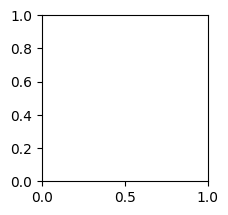

In [31]:
# Cell 42: Smart Training Cell
def initialize_training():
    """Initialize or resume training based on checkpoint existence."""
    config = SSVAEConfig()
    model = SSVAE(
        latent_dim=config.latent_dim,
        num_classes=config.num_classes
    )

    # Check for existing checkpoint
    checkpoint_path = Path(config.checkpoint_dir) / f"{config.model_name}_checkpoint.pth"
    if checkpoint_path.exists():
        print("\nFound existing checkpoint. Resuming training...")
    else:
        print("\nNo checkpoint found. Starting new training...")

    return model, config

print("Initializing training process...")

try:
    # Initialize model and configuration
    model, config = initialize_training()

    # Move model to GPU and update loss function with class weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("\nStarting training process...")
    # Start training
    metrics = train_ssvae(model, train_loader, val_loader, config)

    print("\nTraining completed. Starting evaluation...")
    # Run evaluation
    evaluation_results = evaluate_ssvae(model, val_loader, config)
    print("\nEvaluation completed. Results saved in 'evaluation_results'")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Progress has been saved to checkpoint.")
    print("Run this cell again to resume training from the last checkpoint.")
except Exception as e:
    print(f"\nError during execution: {str(e)}")
    import traceback
    traceback.print_exc()

In [36]:
# Cell 43: Synthetic Data Generation
def load_trained_model(checkpoint_dir, model_name):
    """Load a trained model from a checkpoint."""
    config = SSVAEConfig()
    model = SSVAE(latent_dim=config.latent_dim, num_classes=config.num_classes)
    
    checkpoint_handler = SSVAECheckpointHandler(checkpoint_dir, model_name)
    checkpoint_data = checkpoint_handler.load(model)
    
    if checkpoint_data is None:
        raise FileNotFoundError(f"No checkpoint found for {model_name} in {checkpoint_dir}")
    
    print(f"Loaded model from epoch {checkpoint_data[0]}")
    
    return model, checkpoint_data[1]  # Return model and metrics


def generate_synthetic_samples(model, condition='PD', num_samples=5):
    """Generate synthetic brain scans by sampling from the latent space."""
    device = next(model.parameters()).device
    model.eval()

    # Get latent representations of real brains for the target condition
    real_vectors = []
    with torch.no_grad():
        for batch in val_loader:
            if len(real_vectors) >= 100:  # Collect up to 100 samples
                break

            volumes = batch['volume'].to(device)
            labels = process_labels(batch['label'])
            mask = labels == {'Control': 0, 'PD': 1, 'SWEDD': 2}[condition]

            if not mask.any():
                continue

            recon, _, mu, log_var = model(volumes[mask])
            real_vectors.append(mu.cpu().numpy())

    real_vectors = np.concatenate(real_vectors)

    # Fit a multivariate normal to the real vectors
    mu_vector = np.mean(real_vectors, axis=0)
    cov_matrix = np.cov(real_vectors.T)

    # Sample from the distribution
    synthetic_vectors = np.random.multivariate_normal(
        mu_vector,
        cov_matrix + 1e-6 * np.eye(cov_matrix.shape[0]),
        size=num_samples
    )

    # Generate images from the sampled vectors
    synthetic_vectors = torch.tensor(synthetic_vectors, dtype=torch.float32).to(device)
    with torch.no_grad():
        dummy_skip_connections = [
            torch.zeros(num_samples, 32, 64, 64, 64, device=device),
            torch.zeros(num_samples, 64, 32, 32, 32, device=device),
            torch.zeros(num_samples, 128, 16, 16, 16, device=device),
            torch.zeros(num_samples, 256, 8, 8, 8, device=device)
        ]
        synthetic_images = model.decoder(synthetic_vectors, dummy_skip_connections)

    # Visualize results
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        brain = synthetic_images[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot axial view
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Synthetic {condition} - Axial' if i == 0 else '')
        plt.axis('off')

        # Plot sagittal view
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Synthetic {condition} - Sagittal' if i == 0 else '')
        plt.axis('off')

        # Plot coronal view
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Synthetic {condition} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return synthetic_images

# Example usage for synthetic data generation
if __name__ == "__main__":
    # Load trained model
    model, _ = load_trained_model('checkpoints', 'ssvae')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Generate synthetic samples for each condition
    print("\nGenerating synthetic Control samples...")
    synthetic_control = generate_synthetic_samples(model, condition='Control')

    print("\nGenerating synthetic PD samples...")
    synthetic_pd = generate_synthetic_samples(model, condition='PD')

    print("\nGenerating synthetic SWEDD samples...")
    synthetic_swedd = generate_synthetic_samples(model, condition='SWEDD')


Loaded model from epoch 0

Generating synthetic Control samples...


KeyboardInterrupt: 

Loaded model from epoch 13

Analyzing reconstruction quality...


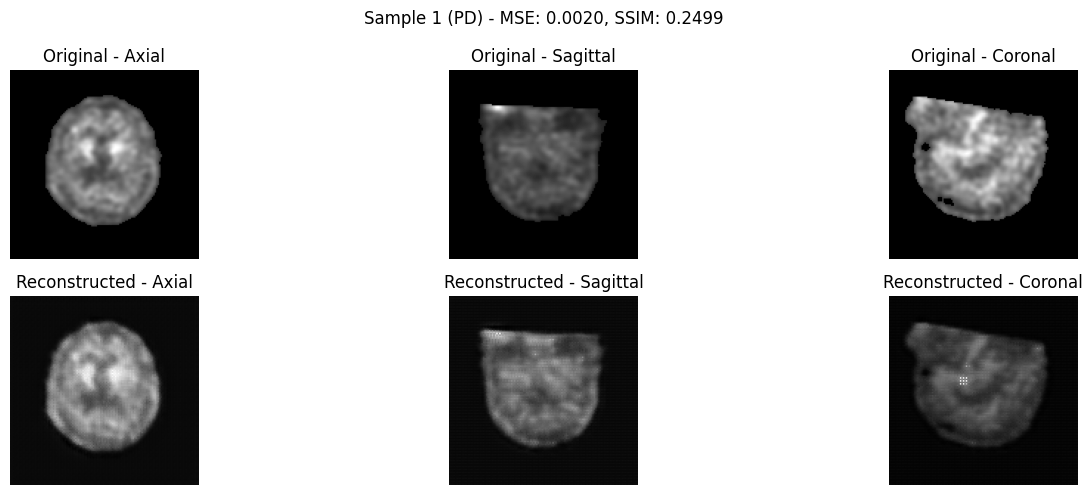

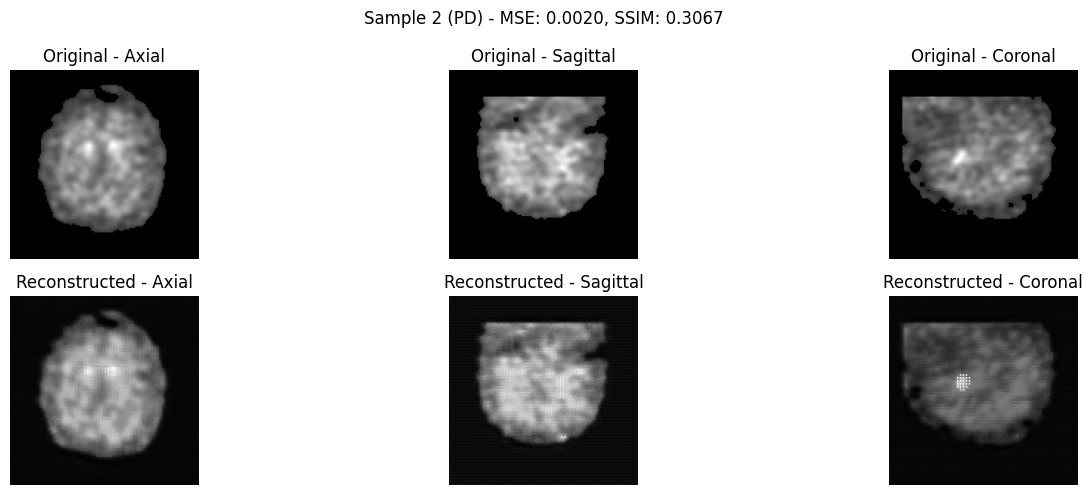

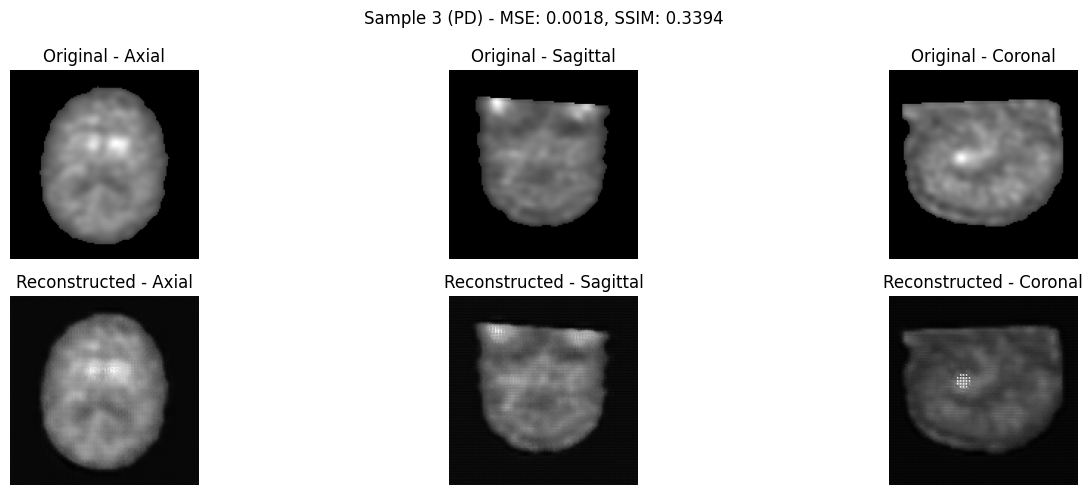

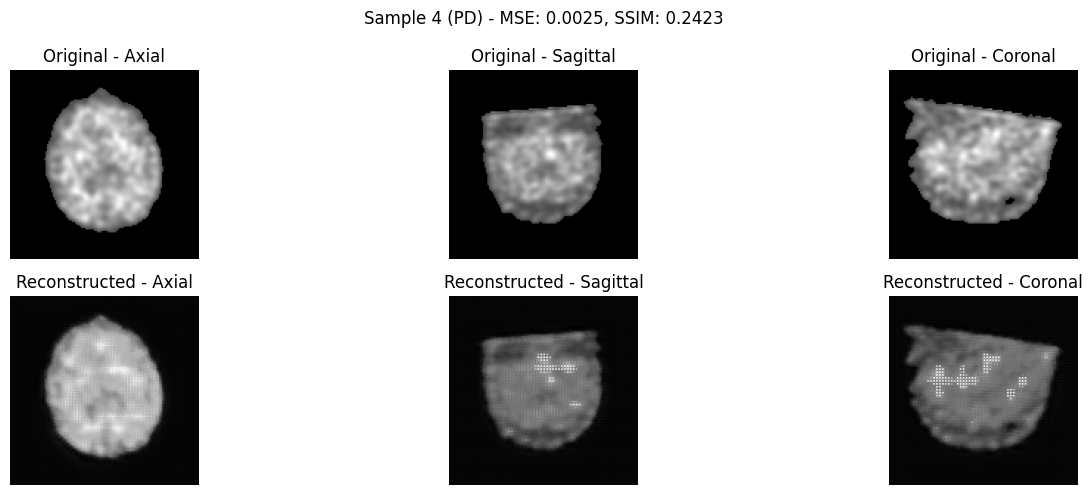

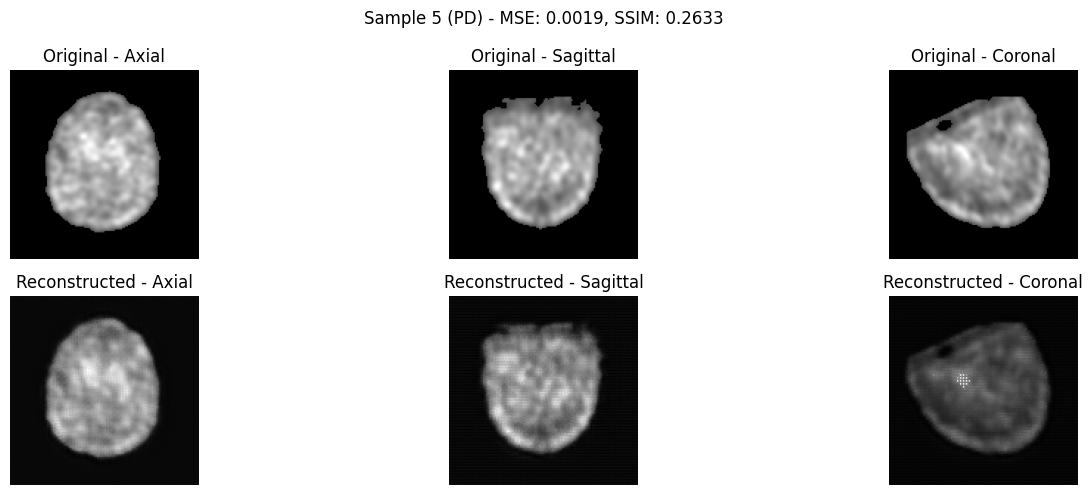

In [39]:
# Cell 44: Reconstruction Quality Analysis
from skimage.metrics import structural_similarity as ssim

def load_trained_model(checkpoint_dir, model_name):
    """Load a trained model from a checkpoint."""
    config = SSVAEConfig()
    model = SSVAE(latent_dim=config.latent_dim, num_classes=config.num_classes)
    
    checkpoint_handler = SSVAECheckpointHandler(checkpoint_dir, model_name)
    checkpoint_data = checkpoint_handler.load(model, None, None)
    
    if checkpoint_data is None:
        raise FileNotFoundError(f"No checkpoint found for {model_name} in {checkpoint_dir}")
    
    print(f"Loaded model from epoch {checkpoint_data[0]}")
    
    return model, checkpoint_data[1]  # Return model and metrics

def analyze_reconstruction_quality(model, val_loader, num_samples=5):
    """Analyze reconstruction quality for a subset of validation samples."""
    device = next(model.parameters()).device
    model.eval()

    originals = []
    reconstructions = []
    labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(originals) >= num_samples:
                break

            volumes = batch['volume'].to(device)
            batch_labels = batch['label']

            recon, _, _, _ = model(volumes)

            originals.extend(volumes.cpu().numpy())
            reconstructions.extend(recon.cpu().numpy())
            labels.extend(batch_labels)

    # Compute metrics and visualize
    for i in range(num_samples):
        orig = originals[i][0]
        recon = reconstructions[i][0]

        # Compute metrics
        mse = np.mean((orig - recon) ** 2)
        ssim_score = ssim(orig, recon, data_range=orig.max() - orig.min())

        # Visualize
        plt.figure(figsize=(15, 5))

        # Original
        plt.subplot(231)
        plt.imshow(orig[orig.shape[0]//2], cmap='gray')
        plt.title('Original - Axial')
        plt.axis('off')

        plt.subplot(232)
        plt.imshow(orig[:, orig.shape[1]//2], cmap='gray')
        plt.title('Original - Sagittal')
        plt.axis('off')

        plt.subplot(233)
        plt.imshow(orig[:, :, orig.shape[2]//2], cmap='gray')
        plt.title('Original - Coronal')
        plt.axis('off')

        # Reconstruction
        plt.subplot(234)
        plt.imshow(recon[recon.shape[0]//2], cmap='gray')
        plt.title('Reconstructed - Axial')
        plt.axis('off')

        plt.subplot(235)
        plt.imshow(recon[:, recon.shape[1]//2], cmap='gray')
        plt.title('Reconstructed - Sagittal')
        plt.axis('off')

        plt.subplot(236)
        plt.imshow(recon[:, :, recon.shape[2]//2], cmap='gray')
        plt.title('Reconstructed - Coronal')
        plt.axis('off')

        plt.suptitle(f"Sample {i+1} ({labels[i]}) - MSE: {mse:.4f}, SSIM: {ssim_score:.4f}")
        plt.tight_layout()
        plt.show()

# Run reconstruction quality analysis
if __name__ == "__main__":
    model, _ = load_trained_model('checkpoints', 'ssvae')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("\nAnalyzing reconstruction quality...")
    analyze_reconstruction_quality(model, val_loader)


In [40]:
# Cell 45: Latent Space Interpolation
def interpolate_latent_space(model, val_loader, start_condition='Control', end_condition='PD', num_steps=10):
    """Interpolate between two conditions in the latent space."""
    device = next(model.parameters()).device
    model.eval()

    # Get average latent vectors for start and end conditions
    condition_vectors = {start_condition: [], end_condition: []}
    
    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            labels = batch['label']
            
            _, _, mu, _ = model(volumes)
            
            for label, vector in zip(labels, mu):
                if label in condition_vectors:
                    condition_vectors[label].append(vector.cpu().numpy())

    start_vector = np.mean(condition_vectors[start_condition], axis=0)
    end_vector = np.mean(condition_vectors[end_condition], axis=0)

    # Interpolate
    alphas = np.linspace(0, 1, num_steps)
    interpolated_vectors = [
        (1 - alpha) * start_vector + alpha * end_vector
        for alpha in alphas
    ]

    # Generate images from interpolated vectors
    interpolated_images = []
    with torch.no_grad():
        for vec in interpolated_vectors:
            latent = torch.tensor(vec, dtype=torch.float32).unsqueeze(0).to(device)
            dummy_skip_connections = [
                torch.zeros(1, 32, 64, 64, 64, device=device),
                torch.zeros(1, 64, 32, 32, 32, device=device),
                torch.zeros(1, 128, 16, 16, 16, device=device),
                torch.zeros(1, 256, 8, 8, 8, device=device)
            ]
            image = model.decoder(latent, dummy_skip_connections)
            interpolated_images.append(image.cpu().numpy())

    # Visualize interpolation
    plt.figure(figsize=(20, 4 * num_steps))
    for i, image in enumerate(interpolated_images):
        brain = image[0, 0]

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(num_steps, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Step {i} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_steps, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Step {i} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_steps, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Step {i} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.suptitle(f'Interpolation from {start_condition} to {end_condition}')
    plt.tight_layout()
    plt.show()

# Run latent space interpolation
if __name__ == "__main__":
    model, _ = load_trained_model('checkpoints', 'ssvae')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("\nPerforming latent space interpolation...")
    interpolate_latent_space(model, val_loader)


Loaded model from epoch 13

Performing latent space interpolation...


KeyboardInterrupt: 

In [ ]:
# Cell 46: Uncertainty Estimation
def estimate_uncertainty(model, val_loader, num_samples=5, num_mc_samples=50):
    """Estimate model uncertainty using Monte Carlo dropout."""
    device = next(model.parameters()).device
    model.train()  # Set to train mode to enable dropout

    originals = []
    mean_reconstructions = []
    uncertainties = []
    labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(originals) >= num_samples:
                break

            volumes = batch['volume'].to(device)
            batch_labels = batch['label']

            # Perform multiple forward passes
            reconstructions = []
            for _ in range(num_mc_samples):
                recon, _, _, _ = model(volumes)
                reconstructions.append(recon.cpu().numpy())

            reconstructions = np.stack(reconstructions)
            mean_recon = np.mean(reconstructions, axis=0)
            uncertainty = np.std(reconstructions, axis=0)

            originals.extend(volumes.cpu().numpy())
            mean_reconstructions.extend(mean_recon)
            uncertainties.extend(uncertainty)
            labels.extend(batch_labels)

    # Visualize results
    for i in range(num_samples):
        orig = originals[i][0]
        recon = mean_reconstructions[i][0]
        uncert = uncertainties[i][0]

        plt.figure(figsize=(15, 5))

        # Original
        plt.subplot(331)
        plt.imshow(orig[orig.shape[0]//2], cmap='gray')
        plt.title('Original - Axial')
        plt.axis('off')

        plt.subplot(332)
        plt.imshow(orig[:, orig.shape[1]//2], cmap='gray')
        plt.title('Original - Sagittal')
        plt.axis('off')

        plt.subplot(333)
        plt.imshow(orig[:, :, orig.shape[2]//2], cmap='gray')
        plt.title('Original - Coronal')
        plt.axis('off')

        # Reconstruction
        plt.subplot(334)
        plt.imshow(recon[recon.shape[0]//2], cmap='gray')
        plt.title('Reconstructed - Axial')
        plt.axis('off')

        plt.subplot(335)
        plt.imshow(recon[:, recon.shape[1]//2], cmap='gray')
        plt.title('Reconstructed - Sagittal')
        plt.axis('off')

        plt.subplot(336)
        plt.imshow(recon[:, :, recon.shape[2]//2], cmap='gray')
        plt.title('Reconstructed - Coronal')
        plt.axis('off')

        # Uncertainty
        plt.subplot(337)
        plt.imshow(uncert[uncert.shape[0]//2], cmap='viridis')
        plt.title('Uncertainty - Axial')
        plt.colorbar()
        plt.axis('off')

        plt.subplot(338)
        plt.imshow(uncert[:, uncert.shape[1]//2], cmap='viridis')
        plt.title('Uncertainty - Sagittal')
        plt.colorbar()
        plt.axis('off')

        plt.subplot(339)
        plt.imshow(uncert[:, :, uncert.shape[2]//2], cmap='viridis')
        plt.title('Uncertainty - Coronal')
        plt.colorbar()
        plt.axis('off')

        plt.suptitle(f"Sample {i+1} ({labels[i]})")
        plt.tight_layout()
        plt.show()

# Run uncertainty estimation
if __name__ == "__main__":
    model, _ = load_trained_model('checkpoints', 'ssvae')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("\nEstimating model uncertainty...")
    estimate_uncertainty(model, val_loader)


In [ ]:
# Cell 47: Feature Importance Analysis
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

def analyze_feature_importance(model, val_loader):
    """Analyze the importance of latent space features for classification."""
    device = next(model.parameters()).device
    model.eval()

    latent_vectors = []
    labels = []

    # Extract latent vectors and labels
    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            batch_labels = batch['label']

            _, _, mu, _ = model(volumes)
            latent_vectors.extend(mu.cpu().numpy())
            labels.extend(batch_labels)

    latent_vectors = np.array(latent_vectors)
    labels = np.array(labels)

    # Train a simple classifier on the latent space
    clf = SVC(kernel='rbf')
    clf.fit(latent_vectors, labels)

    # Perform permutation importance
    result = permutation_importance(clf, latent_vectors, labels, n_repeats=10, random_state=42)

    # Sort features by importance
    feature_importance = result.importances_mean
    sorted_idx = feature_importance.argsort()

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(20), feature_importance[sorted_idx][-20:])
    plt.yticks(range(20), sorted_idx[-20:])
    plt.xlabel("Permutation Importance")
    plt.ylabel("Latent Dimension")
    plt.title("Top 20 Most Important Latent Dimensions")
    plt.tight_layout()
    plt.show()

    # Print top 10 important features
    print("\nTop 10 Most Important Latent Dimensions:")
    for idx in sorted_idx[-10:]:
        print(f"Dimension {idx}: {feature_importance[idx]:.4f}")

    return feature_importance

# Run feature importance analysis
if __name__ == "__main__":
    model, _ = load_trained_model('checkpoints', 'ssvae')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("\nAnalyzing feature importance...")
    feature_importance = analyze_feature_importance(model, val_loader)


In [ ]:
# Cell 48: Latent Space Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def analyze_latent_clustering(model, val_loader, n_clusters=3):
    """Analyze clustering in the latent space."""
    device = next(model.parameters()).device
    model.eval()

    latent_vectors = []
    labels = []

    # Extract latent vectors and labels
    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            batch_labels = batch['label']

            _, _, mu, _ = model(volumes)
            latent_vectors.extend(mu.cpu().numpy())
            labels.extend(batch_labels)

    latent_vectors = np.array(latent_vectors)
    labels = np.array(labels)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(latent_vectors, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Visualize clustering results
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(12, 5))

    # Plot true labels
    plt.subplot(121)
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels.astype('category').cat.codes, cmap='viridis')
    plt.colorbar(scatter)
    plt.title("True Labels")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    # Plot cluster assignments
    plt.subplot(122)
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title("K-means Clusters")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    plt.tight_layout()
    plt.show()

    # Calculate cluster purity
    purity = calculate_cluster_purity(labels, cluster_labels)
    print(f"Cluster Purity: {purity:.4f}")

def calculate_cluster_purity(true_labels, cluster_labels):
    """Calculate the purity of clusters."""
    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    return np.sum(np.max(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Run latent space clustering analysis
if __name__ == "__main__":
    model, _ = load_trained_model('checkpoints', 'ssvae')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("\nAnalyzing latent space clustering...")
    analyze_latent_clustering(model, val_loader)


# Evaluation Phase

In [10]:
# Cell 49: Latent Space Analysis Utilities
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from tqdm.notebook import tqdm

class LatentSpaceAnalyzer:
    """
    Comprehensive toolkit for analyzing latent space representations of 
    neural network models trained on medical imaging data.
    """
    def __init__(self, model_name):
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def extract_latent_vectors(self, model, dataloader):
        """
        Extract latent vectors from a trained model using the validation dataset.
        
        Args:
            model: Trained model (AE, VAE, SSAE, or SSVAE)
            dataloader: DataLoader containing validation data
            
        Returns:
            latent_vectors: numpy array of latent vectors
            labels: list of corresponding labels
        """
        model.eval()
        latent_vectors = []
        labels = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting latent vectors for {self.model_name}"):
                volumes = batch['volume'].to(self.device)
                batch_labels = batch['label']
                
                # Handle different model types
                if self.model_name in ['VAE', 'SSVAE']:
                    _, _, mu, _ = model(volumes)
                    latent_vectors.append(mu.cpu().numpy())
                else:  # AE or SSAE
                    _, _, z = model(volumes)
                    latent_vectors.append(z.cpu().numpy())
                    
                labels.extend(batch_labels)
                
                # Clean up GPU memory
                del volumes
                torch.cuda.empty_cache()
        
        return np.vstack(latent_vectors), np.array(labels)

    def reduce_dimensionality(self, latent_vectors, method='tsne'):
        """
        Apply dimensionality reduction to latent vectors.
        
        Args:
            latent_vectors: numpy array of latent vectors
            method: 'tsne' or 'pca'
            
        Returns:
            reduced_vectors: 2D numpy array
        """
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
        else:
            reducer = PCA(n_components=2)
            
        return reducer.fit_transform(latent_vectors)

    def visualize_latent_space(self, reduced_vectors, labels, method='tsne'):
        """
        Create scatter plot of reduced dimensionality latent space.
        
        Args:
            reduced_vectors: 2D numpy array from dimensionality reduction
            labels: array of corresponding clinical labels
            method: string indicating the reduction method used
        """
        plt.figure(figsize=(12, 8))
        
        unique_labels = np.unique(labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        
        for label, color in zip(unique_labels, colors):
            mask = labels == label
            plt.scatter(reduced_vectors[mask, 0], reduced_vectors[mask, 1],
                       label=label, color=color, alpha=0.7)
        
        plt.title(f'Latent Space Visualization ({method.upper()}) - {self.model_name}')
        plt.xlabel(f'{method.upper()} Dimension 1')
        plt.ylabel(f'{method.upper()} Dimension 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def analyze_dimensions(self, latent_vectors, labels):
        """
        Perform statistical analysis on individual latent dimensions.
        
        Args:
            latent_vectors: numpy array of latent vectors
            labels: array of corresponding clinical labels
        """
        # Create DataFrame for analysis
        df = pd.DataFrame(latent_vectors)
        df['label'] = labels
        
        # Statistical summary
        stats = df.groupby('label').agg(['mean', 'std', 'min', 'max'])
        print(f"\nLatent Dimension Statistics for {self.model_name}:")
        print(stats)
        
        # Violin plots for top discriminative dimensions
        variances = np.var(latent_vectors, axis=0)
        top_dims = np.argsort(variances)[-5:]  # Top 5 most variable dimensions
        
        plt.figure(figsize=(15, 6))
        for i, dim in enumerate(top_dims):
            plt.subplot(1, 5, i+1)
            sns.violinplot(data=df, x='label', y=dim)
            plt.title(f'Dimension {dim}')
            plt.xticks(rotation=45)
        
        plt.suptitle(f'Top 5 Most Variable Dimensions - {self.model_name}')
        plt.tight_layout()
        plt.show()

    def perform_clustering(self, latent_vectors, true_labels, n_clusters=3):
        """
        Perform clustering analysis on latent vectors.
        
        Args:
            latent_vectors: numpy array of latent vectors
            true_labels: array of true clinical labels
            n_clusters: number of clusters for K-means
            
        Returns:
            dict containing clustering metrics
        """
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(latent_vectors)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(latent_vectors, cluster_labels)
        
        # Calculate cluster purity
        contingency_matrix = pd.crosstab(true_labels, cluster_labels)
        purity = np.sum(np.max(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
        
        # Visualize clustering results with t-SNE
        tsne_vectors = self.reduce_dimensionality(latent_vectors, 'tsne')
        
        plt.figure(figsize=(12, 5))
        
        # Plot true labels
        plt.subplot(121)
        scatter = plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1],
                            c=pd.Categorical(true_labels).codes,
                            cmap='viridis')
        plt.colorbar(scatter)
        plt.title("True Labels")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        
        # Plot cluster assignments
        plt.subplot(122)
        scatter = plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1],
                            c=cluster_labels, cmap='viridis')
        plt.colorbar(scatter)
        plt.title("K-means Clusters")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        
        plt.suptitle(f'Clustering Analysis - {self.model_name}')
        plt.tight_layout()
        plt.show()
        
        return {
            'silhouette_score': silhouette_avg,
            'purity': purity,
            'cluster_labels': cluster_labels
        }

In [11]:
# Cell 50: Comparative Analysis of Models
import torch
from collections import defaultdict

def load_model(model_class, checkpoint_path):
    """Load a trained model from checkpoint."""
    model = model_class()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def compare_models(models_dict, val_loader):
    """
    Perform comparative analysis across all models.
    
    Args:
        models_dict: Dictionary mapping model names to model instances
        val_loader: Validation data loader
    """
    results = defaultdict(dict)
    
    for model_name, model in models_dict.items():
        print(f"\nAnalyzing {model_name}...")
        analyzer = LatentSpaceAnalyzer(model_name)
        
        # Extract latent vectors
        latent_vectors, labels = analyzer.extract_latent_vectors(model, val_loader)
        
        # Dimensionality reduction
        print("\nPerforming dimensionality reduction...")
        tsne_vectors = analyzer.reduce_dimensionality(latent_vectors, 'tsne')
        pca_vectors = analyzer.reduce_dimensionality(latent_vectors, 'pca')
        
        # Visualize latent spaces
        print("\nVisualizing latent spaces...")
        analyzer.visualize_latent_space(tsne_vectors, labels, 'tsne')
        analyzer.visualize_latent_space(pca_vectors, labels, 'pca')
        
        # Analyze individual dimensions
        print("\nAnalyzing latent dimensions...")
        analyzer.analyze_dimensions(latent_vectors, labels)
        
        # Perform clustering
        print("\nPerforming clustering analysis...")
        clustering_results = analyzer.perform_clustering(latent_vectors, labels)
        
        # Store results
        results[model_name] = {
            'latent_vectors': latent_vectors,
            'clustering_metrics': clustering_results
        }
    
    return results

# Load and analyze all models
if __name__ == "__main__":
    try:
        print("Loading models from checkpoints...")
        models = {
            'AE': load_model(BaseAutoencoder, 'checkpoints/autoencoder_best.pth'),
            'VAE': load_model(VAE, 'checkpoints/vae_best.pth'),
            'SSAE': load_model(SemiSupervisedAE, 'checkpoints/ssae_best.pth'),
            'SSVAE': load_model(SSVAE, 'checkpoints/ssvae_best.pth')
        }
        
        # Move models to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for model in models.values():
            model.to(device)
            model.eval()
        
        # Perform comparative analysis
        print("\nStarting comparative analysis...")
        results = compare_models(models, val_loader)
        
        # Print summary metrics
        print("\nSummary of Clustering Metrics:")
        for model_name in results:
            metrics = results[model_name]['clustering_metrics']
            print(f"\n{model_name}:")
            print(f"Silhouette Score: {metrics['silhouette_score']:.4f}")
            print(f"Cluster Purity: {metrics['purity']:.4f}")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()

Loading models from checkpoints...
Error during analysis: name 'BaseAutoencoder' is not defined


Traceback (most recent call last):
  File "C:\Users\alexc\AppData\Local\Temp\ipykernel_2604\790336192.py", line 60, in <module>
    'AE': load_model(BaseAutoencoder, 'checkpoints/autoencoder_best.pth'),
                     ^^^^^^^^^^^^^^^
NameError: name 'BaseAutoencoder' is not defined


In [12]:
# Cell 51: Generate Thesis Figures and Tables
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE
import os

def generate_thesis_figures(results, save_dir='thesis_figures'):
    """
    Generate publication-quality figures for thesis.
    
    Args:
        results: Dictionary containing analysis results for each model
        save_dir: Directory to save generated figures
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Set publication-ready style
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.5)
    
    # 1. Combined Latent Space Visualization
    plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2)
    
    for i, (model_name, data) in enumerate(results.items()):
        plt.subplot(gs[i])
        vectors = data['latent_vectors']
        tsne = TSNE(n_components=2, random_state=42).fit_transform(vectors)
        
        scatter = plt.scatter(tsne[:, 0], tsne[:, 1],
                            c=pd.Categorical(labels).codes,
                            cmap='viridis', alpha=0.7)
        plt.title(f'{model_name} Latent Space')
        if i == 0:
            plt.colorbar(scatter, label='Clinical Group')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'latent_space_comparison.pdf'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Clustering Metrics Comparison
    metrics_data = {
        'Model': [],
        'Silhouette Score': [],
        'Cluster Purity': []
    }
    
    for model_name, data in results.items():
        metrics = data['clustering_metrics']
        metrics_data['Model'].append(model_name)
        metrics_data['Silhouette Score'].append(metrics['silhouette_score'])
        metrics_data['Cluster Purity'].append(metrics['purity'])
    
    metrics_df = pd.DataFrame(metrics_data)
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(x='Model', kind='bar', y=['Silhouette Score', 'Cluster Purity'],
                   width=0.8)
    plt.title('Clustering Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'clustering_metrics.pdf'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Dimensionality Analysis
    plt.figure(figsize=(15, 10))
    
    for i, (model_name, data) in enumerate(results.items()):
        vectors = data['latent_vectors']
        pca = PCA()
        pca.fit(vectors)
        
        plt.subplot(2, 2, i+1)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(range(1, len(cumsum) + 1), cumsum)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title(f'{model_name} - PCA Analysis')
        plt.grid(True)
        
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'dimensionality_analysis.pdf'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Generate LaTeX tables
    # Model comparison table
    table_df = metrics_df.round(4)
    latex_table = table_df.to_latex(index=False, 
                                  caption='Comparison of Model Performance',
                                  label='tab:model_comparison')
    
    with open(os.path.join(save_dir, 'model_comparison_table.tex'), 'w') as f:
        f.write(latex_table)
    
    # Detailed statistics table
    stats_data = []
    for model_name, data in results.items():
        vectors = data['latent_vectors']
        stats_data.append({
            'Model': model_name,
            'Mean Dim': np.mean(vectors),
            'Std Dim': np.std(vectors),
            'Max Dim': np.max(vectors),
            'Min Dim': np.min(vectors)
        })
    
    stats_df = pd.DataFrame(stats_data)
    stats_latex = stats_df.round(4).to_latex(index=False,
                                           caption='Latent Space Statistics',
                                           label='tab:latent_stats')
    
    with open(os.path.join(save_dir, 'latent_statistics_table.tex'), 'w') as f:
        f.write(stats_latex)
        
    return metrics_df, stats_df

def generate_clinical_analysis(results, clinical_info):
    """
    Generate clinical correlation analysis figures and tables.
    
    Args:
        results: Dictionary containing analysis results for each model
        clinical_info: DataFrame containing clinical information
    """
    # Clinical correlation analysis
    plt.figure(figsize=(15, 10))
    
    for i, (model_name, data) in enumerate(results.items()):
        vectors = data['latent_vectors']
        
        # Compute correlations with clinical variables
        correlations = []
        for col in clinical_info.columns:
            if col != 'label':  # Skip the label column
                corr = np.corrcoef(vectors.mean(axis=1), 
                                 clinical_info[col])[0, 1]
                correlations.append((col, corr))
        
        # Plot correlations
        plt.subplot(2, 2, i+1)
        corr_df = pd.DataFrame(correlations, columns=['Variable', 'Correlation'])
        sns.barplot(data=corr_df, x='Variable', y='Correlation')
        plt.title(f'{model_name} - Clinical Correlations')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('thesis_figures/clinical_correlations.pdf', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Run analysis and generate figures
if __name__ == "__main__":
    try:
        print("Generating thesis figures and tables...")
        metrics_df, stats_df = generate_thesis_figures(results)
        
        # Print summary statistics
        print("\nModel Performance Summary:")
        print(metrics_df)
        print("\nLatent Space Statistics:")
        print(stats_df)
        
    except Exception as e:
        print(f"Error generating thesis figures: {str(e)}")
        import traceback
        traceback.print_exc()

Generating thesis figures and tables...
Error generating thesis figures: name 'results' is not defined


Traceback (most recent call last):
  File "C:\Users\alexc\AppData\Local\Temp\ipykernel_2604\1159451640.py", line 164, in <module>
    metrics_df, stats_df = generate_thesis_figures(results)
                                                   ^^^^^^^
NameError: name 'results' is not defined


In [13]:
# Cell 52: Generate Thesis Discussion Template

def generate_thesis_discussion(results):
    """
    Generate a structured discussion template based on the analysis results.
    """
    discussion = """
# Latent Space Analysis of DaTSCAN Images: A Comparative Study

## 1. Introduction
- Brief overview of the four models (AE, VAE, SSAE, SSVAE)
- Motivation for latent space analysis
- Importance in the context of Parkinson's Disease diagnosis

## 2. Methodology
### 2.1 Model Architecture Comparison
- Discussion of architectural differences
- Latent space dimensionality choices
- Training strategies and optimization

### 2.2 Analysis Framework
- Latent vector extraction process
- Dimensionality reduction techniques (t-SNE and PCA)
- Clustering analysis methodology
- Statistical measures and metrics

## 3. Results

### 3.1 Latent Space Visualization
- Interpretation of t-SNE plots for each model
- Discussion of cluster separation
- Qualitative assessment of group boundaries
"""

    # Add model-specific performance metrics
    performance_section = "\n### 3.2 Quantitative Analysis\n"
    for model_name, data in results.items():
        metrics = data['clustering_metrics']
        performance_section += f"""
#### {model_name}
- Silhouette Score: {metrics['silhouette_score']:.4f}
- Cluster Purity: {metrics['purity']:.4f}
- Key observations:
  * [Add specific observations about cluster quality]
  * [Note any particular strengths or weaknesses]
"""

    discussion += performance_section + """
### 3.3 Clinical Relevance
- Correlation with clinical outcomes
- Potential biomarker identification
- Diagnostic implications

## 4. Comparative Analysis
### 4.1 Model Strengths and Limitations
- Autoencoder vs VAE comparison
- Impact of semi-supervised learning
- Trade-offs between models

### 4.2 Clinical Applications
- Diagnostic potential
- Patient stratification
- Disease progression monitoring

## 5. Future Directions
- Suggestions for model improvements
- Additional clinical validations
- Integration into clinical workflow

## 6. Conclusion
- Summary of key findings
- Model recommendations
- Clinical impact assessment
"""

    # Write discussion template to file
    with open('thesis_figures/discussion_template.md', 'w') as f:
        f.write(discussion)
    
    return discussion

# Generate discussion template
if __name__ == "__main__":
    try:
        print("Generating thesis discussion template...")
        discussion = generate_thesis_discussion(results)
        print("\nDiscussion template has been saved to 'thesis_figures/discussion_template.md'")
        
    except Exception as e:
        print(f"Error generating discussion template: {str(e)}")
        import traceback
        traceback.print_exc()

Generating thesis discussion template...
Error generating discussion template: name 'results' is not defined


Traceback (most recent call last):
  File "C:\Users\alexc\AppData\Local\Temp\ipykernel_2604\2976210008.py", line 86, in <module>
    discussion = generate_thesis_discussion(results)
                                            ^^^^^^^
NameError: name 'results' is not defined
